In [1]:
import numpy as np
import networkx as nx

#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
%config InlineBackend.figure_format = 'retina'

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader # (testset, batch_size=4,shuffle=False, num_workers=4)
from torch.optim.lr_scheduler import ReduceLROnPlateau as RLRP
from torch.nn.parallel import DistributedDataParallel, DataParallel
from torch.nn.init import xavier_normal
from torch.nn.parameter import Parameter
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import sys
from datetime import datetime
from functools import reduce
import os
import os.path
import pandas as pd
import pickle
import importlib
from collections import Counter
from copy import deepcopy
from collections import OrderedDict

import nkmodel as nk
import ppo.core as core
from ppo.ppo import PPOBuffer
from utils.utils import max_mean_clustering_network, real_network
import envs
import json
import scipy
from itertools import product
from functools import reduce
from scipy.stats import rankdata, multivariate_normal

In [2]:
conversion_dict1 = {'FollowBest' : 'BI',
                    'FollowBest_indv': 'BI-I',
                    'FollowBest_prob': 'BI-P',
                    'FollowBest_random': 'BI-R',
                    'FollowMajor': 'CF', 
                    'FollowMajor_indv': 'CF-I',
                    'FollowMajor_prob': 'CF-P',
                    'FollowMajor_random': 'CF-R',
                    'IndvLearning': 'PI-I',
                    'IndvProb': 'PI-P',
                    'IndvRandom': 'PI-R',
                    'RandomCopy': 'RI'
                   }

conversion_dict2 = dict((v,k) for k,v in conversion_dict1.items())

In [77]:
def load_model(exp_name, epoch):

    #rel_path = f'data/runs/ds_complete_indv_raw_random_SIR_N10K3NN3_new_rand/{exp_name}/{exp_name}_s42/'
    rel_path = f'data/runs/{exp_name}/{exp_name}_s42/'

    with open(rel_path + "config.json") as json_file:
        json_data = json.load(json_file)
    env_kwargs = json_data['env_kwargs']
    env_name = json_data['env_name']
    env_kwargs['graph'] = nx.complete_graph

    #rel_path = f'data/runs/ds_complete_indv_raw_random_SIR_N10K3NN3_new_rand/{exp_name}/{exp_name}_s42/'
    rel_path = f'data/runs/{exp_name}/{exp_name}_s42/'

    with open(rel_path + "config.json") as json_file:
        json_data = json.load(json_file)
    env_kwargs = json_data['env_kwargs']
    env_name = json_data['env_name']
    env_kwargs['graph'] = max_mean_clustering_network if json_data['env_kwargs']['graph_type'] == 'maxmc' else nx.complete_graph
    ac_kwargs = json_data['ac_kwargs']
    ac_kwargs['activation'] = nn.Tanh()
    arch = json_data['arch']
    trj_len = json_data['trj_len']
    gamma = json_data['gamma']
    lam = json_data['lam']
    epochs = json_data['epochs']
    seed = json_data['seed']
    ensemble_num = env_kwargs['E']
    agent_num = env_kwargs['M']
    env_scheduler_kwargs = {
            'local_rank': 0,
            'exp_name': exp_name,
            'E': env_kwargs['E'],
            'N': env_kwargs['N'],
            'K': env_kwargs['K'],
            'exp': env_kwargs['exp'],
            'NGPU': 1, #'data_dir': 'D:\\OneDrive\\연구\\ML\\MyProject\\SocialNet\\SocialNet\\data\\runs\\ds_complete_indv_raw_random_SIR_N10K3NN3_new_rand'
        'data_dir': 'D:\\OneDrive\\연구\\ML\\MyProject\\SocialNet\\SocialNet\\data\\runs'
    }
    env_kwargs['env_scheduler'] = envs.__dict__['random_env_scheduler'](**env_scheduler_kwargs)
    json_data['corr_type'] = 'TT'
    env_kwargs['corr_type'] = 'TT'
    if len(env_kwargs['reward_type']) < 9:
        print('modify')
        env_kwargs['reward_type'] = env_kwargs['reward_type'] + '_full'
    torch.manual_seed(seed)
    np.random.seed(seed)
    env = envs.__dict__[env_name](**env_kwargs)
    action_type = env_kwargs['action_type']
    extra_type = env_kwargs['extra_type']
    extra_num = len(extra_type)
    # Instantiate environment
    if action_type == 'total':
        obs_dim = (env.neighbor_num + 1, env.N + extra_num)  # (3+1, 15+2)
        act_dim = env.action_space.n
        dim_len = env.N
    elif action_type == 'split':
        obs_dim = (env.neighbor_num + 1, 1 + extra_num)
        act_dim = (2,)
        dim_len = env.N
        
    checkpoint = torch.load(rel_path+f'pyt_save/model{epoch}.pth')
    ac = core.ActorCritic(obs_dim, act_dim, arch, **ac_kwargs)
    ac.pi.load_state_dict(checkpoint['pi'])
    ac.v.load_state_dict(checkpoint['v'])

    Parallel = DataParallel
    parallel_args = {
        'device_ids': list(range(1)),
        'output_device': 0
    } 

    ac.pi = Parallel(ac.pi, **parallel_args)
    ac.v = Parallel(ac.v, **parallel_args)
    ac.eval()
    return ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs
    ac_kwargs = json_data['ac_kwargs']
    ac_kwargs['activation'] = nn.Tanh()
    arch = json_data['arch']
    trj_len = json_data['trj_len']
    gamma = json_data['gamma']
    lam = json_data['lam']
    epochs = json_data['epochs']
    seed = json_data['seed']
    ensemble_num = env_kwargs['E']
    agent_num = env_kwargs['M']
    env_scheduler_kwargs = {
            'local_rank': 0,
            'exp_name': exp_name,
            'E': env_kwargs['E'],
            'N': env_kwargs['N'],
            'K': env_kwargs['K'],
            'exp': env_kwargs['exp'],
            'NGPU': 1, #'data_dir': 'D:\\OneDrive\\연구\\ML\\MyProject\\SocialNet\\SocialNet\\data\\runs\\ds_complete_indv_raw_random_SIR_N10K3NN3_new_rand'
        'data_dir': 'D:\\OneDrive\\연구\\ML\\MyProject\\SocialNet\\SocialNet\\data\\runs'
    }
    env_kwargs['env_scheduler'] = envs.__dict__['random_env_scheduler'](**env_scheduler_kwargs)
    json_data['corr_type'] = 'TT'
    env_kwargs['corr_type'] = 'TT'
    if len(env_kwargs['reward_type']) < 9:
        print('modify')
        env_kwargs['reward_type'] = env_kwargs['reward_type'] + '_full'
    torch.manual_seed(seed)
    np.random.seed(seed)
    env = envs.__dict__[env_name](**env_kwargs)
    action_type = env_kwargs['action_type']
    extra_type = env_kwargs['extra_type']
    extra_num = len(extra_type)
    # Instantiate environment
    if action_type == 'total':
        obs_dim = (env.neighbor_num + 1, env.N + extra_num)  # (3+1, 15+2)
        act_dim = env.action_space.n
        dim_len = env.N
    elif action_type == 'split':
        obs_dim = (env.neighbor_num + 1, 1 + extra_num)
        act_dim = (2,)
        dim_len = env.N
        
    checkpoint = torch.load(rel_path+f'pyt_save/model{epoch}.pth')
    ac = core.ActorCritic(obs_dim, act_dim, arch, **ac_kwargs)
    ac.pi.load_state_dict(checkpoint['pi'])
    ac.v.load_state_dict(checkpoint['v'])

    Parallel = DataParallel
    parallel_args = {
        'device_ids': list(range(1)),
        'output_device': 0
    } 

    ac.pi = Parallel(ac.pi, **parallel_args)
    ac.v = Parallel(ac.v, **parallel_args)
    ac.eval()
    return ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs

def ema(data, alpha = 0.99):
    ema_data = np.zeros_like(data)
    ema_data[0] = data[0]
    for i in range(len(ema_data)-1):
        ema_data[i+1] = alpha * ema_data[i] + (1 - alpha) * data[i+1]
    return ema_data

In [5]:
import timeit

def coord_triplet(s):
    x = []  # np.zeros((int(s*(s+1)*(s+2)/6), 3))

    for i in range(s):
        for j in range(i, s):
            for k in range(j, s):
                x.append([i, j, k])
                
                
    return np.array(x)

def fixed_point(ac):
    data = np.array([[[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 1], 
                  [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 100, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 100, 0]]])

    a, v, logp, pi = ac.step(torch.as_tensor(data, dtype=torch.float32, device='cuda'), return_pi=True)
    x = pi.probs[..., 1].detach().cpu().numpy()
    return np.round(x)[0].astype(np.int)

def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def make_cube(s, sp_dist, cp_dist, hp_dist):
    x = np.ones((s, s, s, 3))
    c = 0
    for i in range(s):
        for j in range(i, s):  # i+1
            for k in range(j, s):  # j+1
                x[i, j, k] = [sp_dist[c], cp_dist[c], hp_dist[c]]
                c+=1
    return x

def assign_facecolors(pi_list, sp, cp, hp, sp_show, cp_show, hp_show, max_s):
    N = pi_list.shape[-1]
    sp_dist = (np.sum((pi_list - sp)**2, axis=-1)**0.5)/np.sqrt(N)
    cp_dist = (np.sum((pi_list -cp)**2, axis=-1)**0.5)/np.sqrt(N)
    hp_dist = (np.sum((pi_list - hp)**2, axis=-1)**0.5)/np.sqrt(N)
    
    facecolors = np.zeros((max_s, max_s, max_s, 4)) # R, G, B, alpha
    mc = make_cube(max_s, sp_dist, cp_dist, hp_dist)
    if sp_show:
        facecolors[..., 0] = (1 - mc[:, :, :, 0])**2   # Red : sp_dist
    if cp_show:
        facecolors[..., 1] = (1 - mc[:, :, :, 1])**2   # Blue : np_dist
    if hp_show:
        facecolors[..., 2] = (1 - mc[:, :, :, 2])**2   # Blue : hp_dist
    #facecolors[..., -1] = (np.maximum((1 - np.min(mc, axis=-1)), 0.5)-0.5)*2
    facecolors[..., -1] = (1 - np.min(mc[..., [sp_show, cp_show, hp_show]], axis=-1))**2 * 0.3 # maximum opacity : 0.8 * 0.8 
    return facecolors, sp_dist, cp_dist, hp_dist

def make_cube_freq(s, sp_dist, cp_dist, hp_dist):
    x = np.ones((s, s, s, 3))
    c = 0
    for i in range(s):
        for j in range(i, s):  # i+1
            for k in range(j, s):  # j+1
                if i==j and j<k:
                    x[i, j, k] = [sp_dist[c], cp_dist[c], hp_dist[c]]
                    c+=1
    return x

def assign_facecolors_freq(pi_list, sp, cp, hp, sp_show, cp_show, hp_show, max_s):
    N = pi_list.shape[-1]
    sp_dist = (np.sum((pi_list - sp)**2, axis=-1)**0.5)/np.sqrt(N)
    cp_dist = (np.sum((pi_list -cp)**2, axis=-1)**0.5)/np.sqrt(N)
    hp_dist = (np.sum((pi_list - hp)**2, axis=-1)**0.5)/np.sqrt(N)
    
    facecolors = np.zeros((max_s, max_s, max_s, 4)) # R, G, B, alpha
    mc = make_cube_freq(max_s, sp_dist, cp_dist, hp_dist)
    if sp_show:
        facecolors[..., 0] = (1 - mc[:, :, :, 0])**2   # Red : sp_dist
    if cp_show:
        facecolors[..., 1] = (1 - mc[:, :, :, 1])**2   # Blue : np_dist
    if hp_show:
        facecolors[..., 2] = (1 - mc[:, :, :, 2])**2   # Blue : hp_dist
    #facecolors[..., -1] = (np.maximum((1 - np.min(mc, axis=-1)), 0.5)-0.5)*2
    facecolors[..., -1] = (1 - np.min(mc[..., [sp_show, cp_show, hp_show]], axis=-1))**2 * 0.3 # maximum opacity : 0.8 * 0.8 
    return facecolors, sp_dist, cp_dist, hp_dist

def plot_cube(facecolors, stride, angle=320, name = '', save=True):
    IMG_DIM = len(facecolors)
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    #print(filled.shape)
    #print(np.indices(np.array(filled.shape) + 1).shape)
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(4, 4), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=IMG_DIM*stride)
    ax.set_ylim(top=IMG_DIM*stride)
    ax.set_zlim(top=IMG_DIM*stride)
    
    #ax.set_xlabel(r'$p_3$', fontsize=18)
    #ax.set_ylabel(r'$p_2$', fontsize=18)
    #ax.set_zlabel(r'$p_1$', fontsize=18)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    #ax.set_xticks([0, 50, 100])
    #ax.set_yticks([0, 50, 100])
    #ax.set_zticks([0, 50, 100])
    #ax.tick_params(axis = 'x', labelsize=12)
    #ax.tick_params(axis = 'y', labelsize=12)
    #ax.tick_params(axis = 'z', labelsize=12)
    
    ax.voxels(x/2*stride, y/2 * stride, z/2 * stride, filled, facecolors=facecolors, shade=False)
    
    if save:
        plt.savefig(f'./result/cube_figure/cube_{name}.png', transparent=True, dpi=300)
        plt.close()
        
template_a1 = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1], 
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0],
          [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0]])

template_a2 = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1], 
          [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0],
            [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0]])

template_a3 = np.array([[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1], 
          [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0]])

template_a4 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 1],
                     [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0],
                     [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0],
                     [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0]])

template_a5 = np.array([[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0],
                     [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0]])

template_a6 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 1],
                     [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0],
                     [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0]])

template_a7 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 1],
                     [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0],
                     [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0],
                     [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0]])

template_b1 = np.array([[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, -1, 1],
                     [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0]])


template3 = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1], 
          [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, -1, 0],
            [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, -1, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0]])

template4 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 1],
                      [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, -1, 0],
                      [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, -1, 0],
                      [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0]])


# Fig.1

## Fig.1a

In [ ]:
%matplotlib notebook
#%matplotlib inline
# Generate torus mesh

fig = plt.figure(figsize = (6, 6))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.gca(projection = '3d')

def gauss2d(mu, sigma):
    w, h = 100, 100
    std = [np.sqrt(sigma[0]), np.sqrt(sigma[1])]
    #x = np.linspace(mu[0] - 3 * std[0], mu[0] + 3 * std[0], w)
    #y = np.linspace(mu[1] - 3 * std[1], mu[1] + 3 * std[1], h)
    x = np.linspace(-5, 5, w)
    y = np.linspace(-5, 5, h)
    x, y = np.meshgrid(x, y)

    x_ = x.flatten()
    y_ = y.flatten()
    xy = np.vstack((x_, y_)).T

    normal_rv = multivariate_normal(mu, sigma)
    z = normal_rv.pdf(xy)
    return x, y, z.reshape(w, h, order='F').T

X, Y, z1 = gauss2d(mu = np.array([0, 0]), sigma = np.array([3, 3]))
for i in range(30):
    _, _, z = gauss2d(mu = np.array([np.random.uniform(-5, 5), np.random.uniform(-5, 5)]), 
                      sigma = np.array([np.random.uniform(0.2, 1.5), np.random.uniform(0.2, 1.5)]))
    z1 += z
    
surf = ax.plot_surface(X, Y, z1, cmap="YlGn", vmin=-0.1, vmax=0.9, linewidth=5, antialiased=False, rcount=200, ccount=200, alpha=0.8)
#traj = traj[-50:]
#traj_noise = traj_noise[-50:]
#ax.plot3D(traj[:, 0], traj[:, 1], traj[:, 2], marker='o', ms=2, linewidth=1, color='r')
#ax.plot3D(traj_noise[:, 0], traj_noise[:, 1], traj_noise[:, 2], marker='o', ms=1, linewidth=2, color='b')
#ax.set_xlim3d(-1, 1)
#ax.set_ylim3d(-1, 1)
#ax.set_zlim3d(-1, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_axis_off()
plt.show()
#plt.savefig('rugged.svg', transparent=True, dpi=300)

In [ ]:
plt.savefig('rugged2.png', transparent=True, dpi=300)

# Fig.2

## Fig.2a

In [ ]:
# self score, SIRF
max_s = 100
s_list = [50]
%matplotlib inline

graph_type = 'complete'
#exp_name = 'SIRF_TT_gene_ent_EC0.003_N15K7NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98'
exp_name = 'test_test'
epoch = 3891
label = ''
rescale = False
extra_type = 'SIRF'
offset = 4
ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs = load_model(exp_name, epoch)
neighbor_num = env_kwargs['neighbor_num']

template = template_a1
template = np.c_[template, np.array([[-1, 0], [-1, 1 / neighbor_num], [-1, 1 / neighbor_num], [-1, 1 / neighbor_num]])]

for s in s_list:
    print(s)
    tc = coord_triplet(max_s+1)
    data = np.repeat(template.reshape(1, 4, 19), len(tc), axis=0).astype(np.float)
    tc = np.c_[np.ones(tc.shape[0])*s, tc]
    if rescale:
        data[:, :, -offset] = tc
    else:
        data[:, :, -offset] = tc / 100.
        
    score_rank = rankdata(tc, axis=-1, method='min') / (neighbor_num + 1)
    data[:, :, -2] = score_rank
    pi_list = []
    ent = 0
    for i in range((data.shape[0]//10000)+1):
        a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
        x = pi.probs[..., 1].detach().cpu().numpy()
        ent += pi.entropy().sum()
        pi_list.append(x)
        #print(x, pi.entropy().sum())
    pi_list = np.concatenate(pi_list, axis=0)
    ent /= data.shape[0] * 15
    print(ent)
    sp = template[0][:-offset]
    cp = template[-2][:-offset]
    hp = template[-1][:-offset]
    facecolors, sp_dist, cp_dist, hp_dist = assign_facecolors(pi_list, sp, cp, hp, True, True, True, max_s+1)
    stride = 5
    assert max_s%stride == 0
    #facecolors = facecolors[::stride, ::stride, ::stride]
    #plot_cube(facecolors, stride = stride, angle=-75, name = f'{graph_type}_e{epoch}_s{s}_{label}', save=False)
    #plt.savefig(f'./Fig2b_5.svg', transparent=True, dpi=300)

In [ ]:
fig = plt.figure(figsize=(3.5, 4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(pi_list, aspect='auto', cmap='viridis', origin='lower')

ax.set_xticks([])

ax.set_xticks([1, 5, 9, 13])
ax.set_xticklabels(['Self', 'Best', 'Second', 'Third'], fontsize=14)

ax.set_yticks([])
#ax.set_yticks([0, 83140, 176851])
#ax.set_yticklabels(['(50, 0, \n0, 0)', '(50, 20, \n20, 20)', '(50, 100, \n100, 100)',], fontsize=14)
#ax.set_yticklabels(['', '', ''])

#ax.set_ylabel('Average Mean Payoff', fontsize=18)

#ax.tick_params(axis = 'both', labelsize=14)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('Fig2b.svg', transparent=True, dpi=300)

## Fig.2c

In [ ]:
# Frequency test
max_s = 100
s_list = [50]
%matplotlib inline
# complete_L200 2025
# complete_L200_2 2269
# complete_L300 2593
# maxmc_L100 4483
# maxmc_L200 3761
graph_type = 'complete'
exp_name = 'SIRF_TT_gene_ent_EC0.003_N15K3NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98'
epoch = 900
label = ''
rescale = False
extra_type = 'SIRF'
offset = 4
ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs = load_model(exp_name, epoch)
neighbor_num = env_kwargs['neighbor_num']

template_f1 = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, 0], 
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0, -1, 2 / neighbor_num],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0, -1, 2 / neighbor_num],
          [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, 1 / neighbor_num]])

template_f2 = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, 0], 
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, 1 / neighbor_num],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0, -1, 1 / neighbor_num],
          [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, 1 / neighbor_num]])

template = template_f1

for s in s_list:
    tc = coord_triplet(max_s+1)
    mask = [True if ((tc[i][1]<tc[i][2]) and (tc[i][0]==tc[i][1])) else False for i in range(len(tc))]
    tc = tc[mask]
    data = np.repeat(template.reshape(1, 4, 19), len(tc), axis=0).astype(np.float)
    tc = np.c_[np.ones(tc.shape[0])*s, tc]
    if rescale:
        data[:, :, -offset] = tc
    else:
        data[:, :, -offset] = tc / 100.
        
    score_rank = rankdata(tc, axis=-1, method='min') / (neighbor_num + 1)
    data[:, :, -2] = score_rank
    pi_list = []
    ent = 0
    for i in range((data.shape[0]//10000)+1):
        a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
        x = pi.probs[..., 1].detach().cpu().numpy()
        ent += pi.entropy().sum()
        pi_list.append(x)
        #print(x, pi.entropy().sum())
    pi_list = np.concatenate(pi_list, axis=0)
    sp = template[0][:-offset]
    cp = template[-2][:-offset]
    hp = template[-1][:-offset]
    facecolors, sp_dist, cp_dist, hp_dist = assign_facecolors_freq(pi_list, sp, cp, hp, True, True, True, max_s+1)
    stride = 5
    assert max_s%stride == 0
    #facecolors = facecolors[::stride, ::stride, ::stride]
    #plot_cube(facecolors, stride = stride, angle=-75, name = f'{graph_type}_e{epoch}_s{s}_{label}', save=False)

In [ ]:
pi_list.shape

In [ ]:
fig = plt.figure(figsize=(3.5, 4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(pi_list, aspect='auto', cmap='viridis', origin='lower')

ax.set_xticks([])

ax.set_xticks([1, 5, 13])
ax.set_xticklabels(['Self', 'Best', 'Major'], fontsize=14)


#ax.set_yticklabels(['(50, 0, \n0, 0)', '(50, 20, \n20, 20)', '(50, 100, \n100, 100)',], fontsize=14)
ax.set_yticks([])

#ax.set_ylabel('Average Mean Payoff', fontsize=18)

#ax.tick_params(axis = 'both', labelsize=14)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
cbar.ax.tick_params(labelsize=14)

#cbar.ax.set_xticklabels(['0.3', '0.4', '0.5', '0.6'])

plt.tight_layout()
#plt.savefig('Fig2c.svg', transparent=True, dpi=300)

# Fig.3

In [30]:
with open(f'./result/baseline_complete_N15K7NN3_tot.pkl', 'rb') as f:
    baseline_complete_dict = pickle.load(f)
with open('./result/inspection_dict/inspection_dict_SIRF_TT_gene_ent_EC0.003_N15K7NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98_cp_E5400_E550.pkl', 'rb') as f:
    inspection_complete_dict = pickle.load(f)

In [35]:
complete_dict = {}
complete_sem_dict = {}
for key in baseline_complete_dict.keys():
    if key != 'keys':
        result = []
        np.mean(baseline_complete_dict[key]['scr_buf'])
        complete_dict[conversion_dict1[key]] = [np.mean(baseline_complete_dict[key]['scr_buf']*100), 
                                                     np.mean(baseline_complete_dict[key]['scr_buf'][..., -1])*100]
        complete_sem_dict[conversion_dict1[key]] = [np.std(np.mean(baseline_complete_dict[key]['scr_buf'], axis=(-2, -1)))/np.sqrt(5000)*100, 
                                                     np.std(np.mean(baseline_complete_dict[key]['scr_buf'][..., -1], axis=-1))/np.sqrt(5000)*100]

In [36]:
Ret_list = []
FinalScore_list = []

for i in range(len(inspection_complete_dict['scr_buf_list'])):
    Ret_list.append(inspection_complete_dict['scr_buf_list'][i])
    FinalScore_list.append(inspection_complete_dict['scr_buf_list'][i][:, :, -1])
    
Ret_list = np.array(Ret_list)
FinalScore_list = np.array(FinalScore_list)

In [37]:
complete_dict['RL'] = [np.mean(Ret_list)*100, 
                       np.mean(FinalScore_list)*100]
complete_sem_dict['RL'] = [np.std(np.mean(Ret_list, axis=(-2, -1)))/np.sqrt(5000)*100, 
                           np.std(np.mean(FinalScore_list, axis=-1))/np.sqrt(5000)*100]

In [38]:
complete_dict

{'BI': [33.323574, 33.55870246887207],
 'BI-I': [57.76423, 58.644795417785645],
 'BI-R': [77.53795, 89.71867561340332],
 'BI-P': [66.56193, 71.01125121116638],
 'CF': [4.67564, 4.7403499484062195],
 'CF-I': [66.21046, 80.0983726978302],
 'CF-R': [48.022266, 70.71776986122131],
 'CF-P': [61.064575, 80.91681599617004],
 'PI-I': [34.498917, 37.83098757266998],
 'PI-R': [31.585983, 40.16308784484863],
 'PI-P': [35.30049, 44.63910460472107],
 'RI': [33.002563, 33.55870246887207],
 'RL': [82.72990584373474, 92.10947751998901]}

## Fig.3a

In [40]:
data = pd.read_csv('./result/progress/progress_default.txt', sep = "\t")
y1 = ema(data['AvgRet'].values, 0.99) * 100
y1_max = ema(data['MaxRet'].values, 0.999)
y1_min = ema(data['MinRet'].values, 0.999)
y2 = ema(data['Entropy'].values, 0.99)

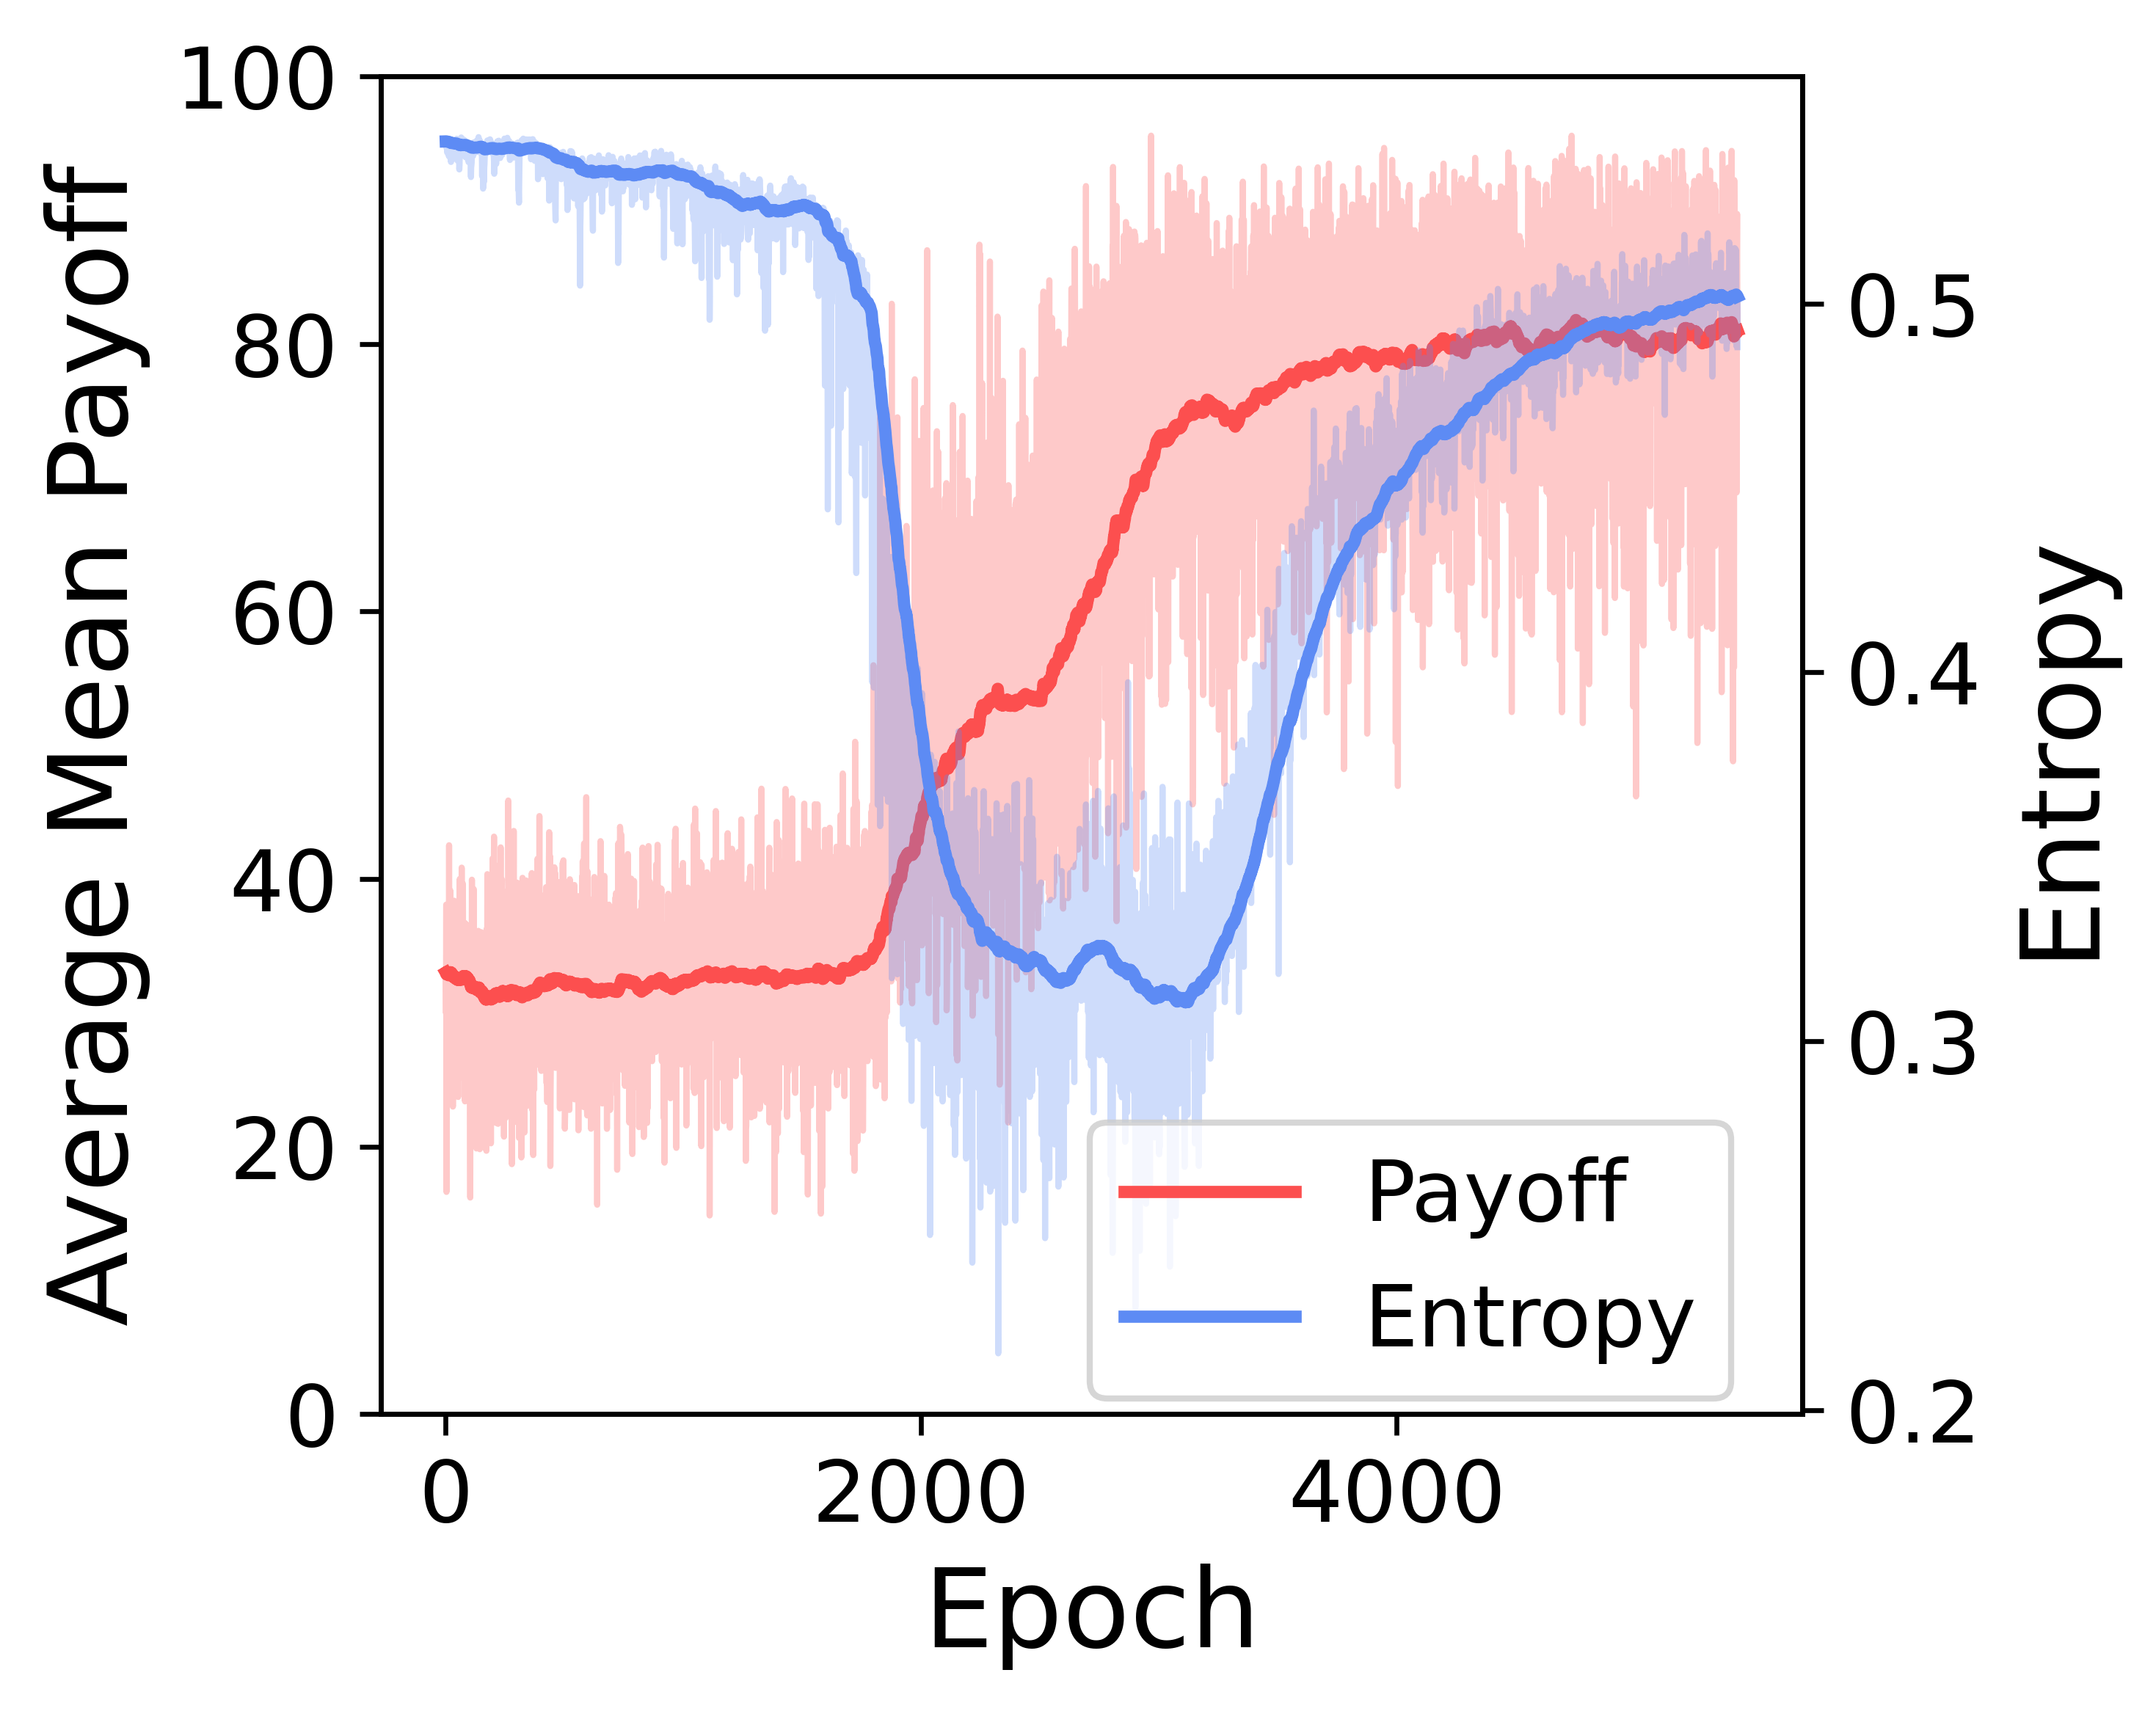

In [43]:
fig = plt.figure(figsize=(5, 4), dpi=300)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx() 
ax1.plot(y1, lw=2, c='#FC4F4F', label='Payoff')
#ax1.plot(y1_max, lw=2, ls=(0, (5, 5)), c='#FC4F4F', alpha=0.5)
#ax1.plot(y1_min, lw=2, ls=(0, (5, 5)), c='#FC4F4F', alpha=0.5)
ax1.plot(data['AvgRet'].values*100, lw=1, alpha=0.3, c='#FC4F4F')
ax2.plot(y2, lw=2, c='#5D8BF4', label='Entropy')
ax2.plot(data['Entropy'].values, lw=1, alpha=0.3, c='#5D8BF4')

ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('Average Mean Payoff', fontsize=18)
ax1.set_ylim(0, 100)
ax2.set_ylabel('Entropy', fontsize=18)

ax1.tick_params(axis = 'both', labelsize=14)
ax2.tick_params(axis = 'both', labelsize=14)

fig.legend(loc="upper right", bbox_to_anchor=(0.98, 0.25), bbox_transform=ax1.transAxes, fontsize=14)
plt.tight_layout()
plt.savefig('Fig3a.svg', transparent=True, dpi=300)

## Fig.3b

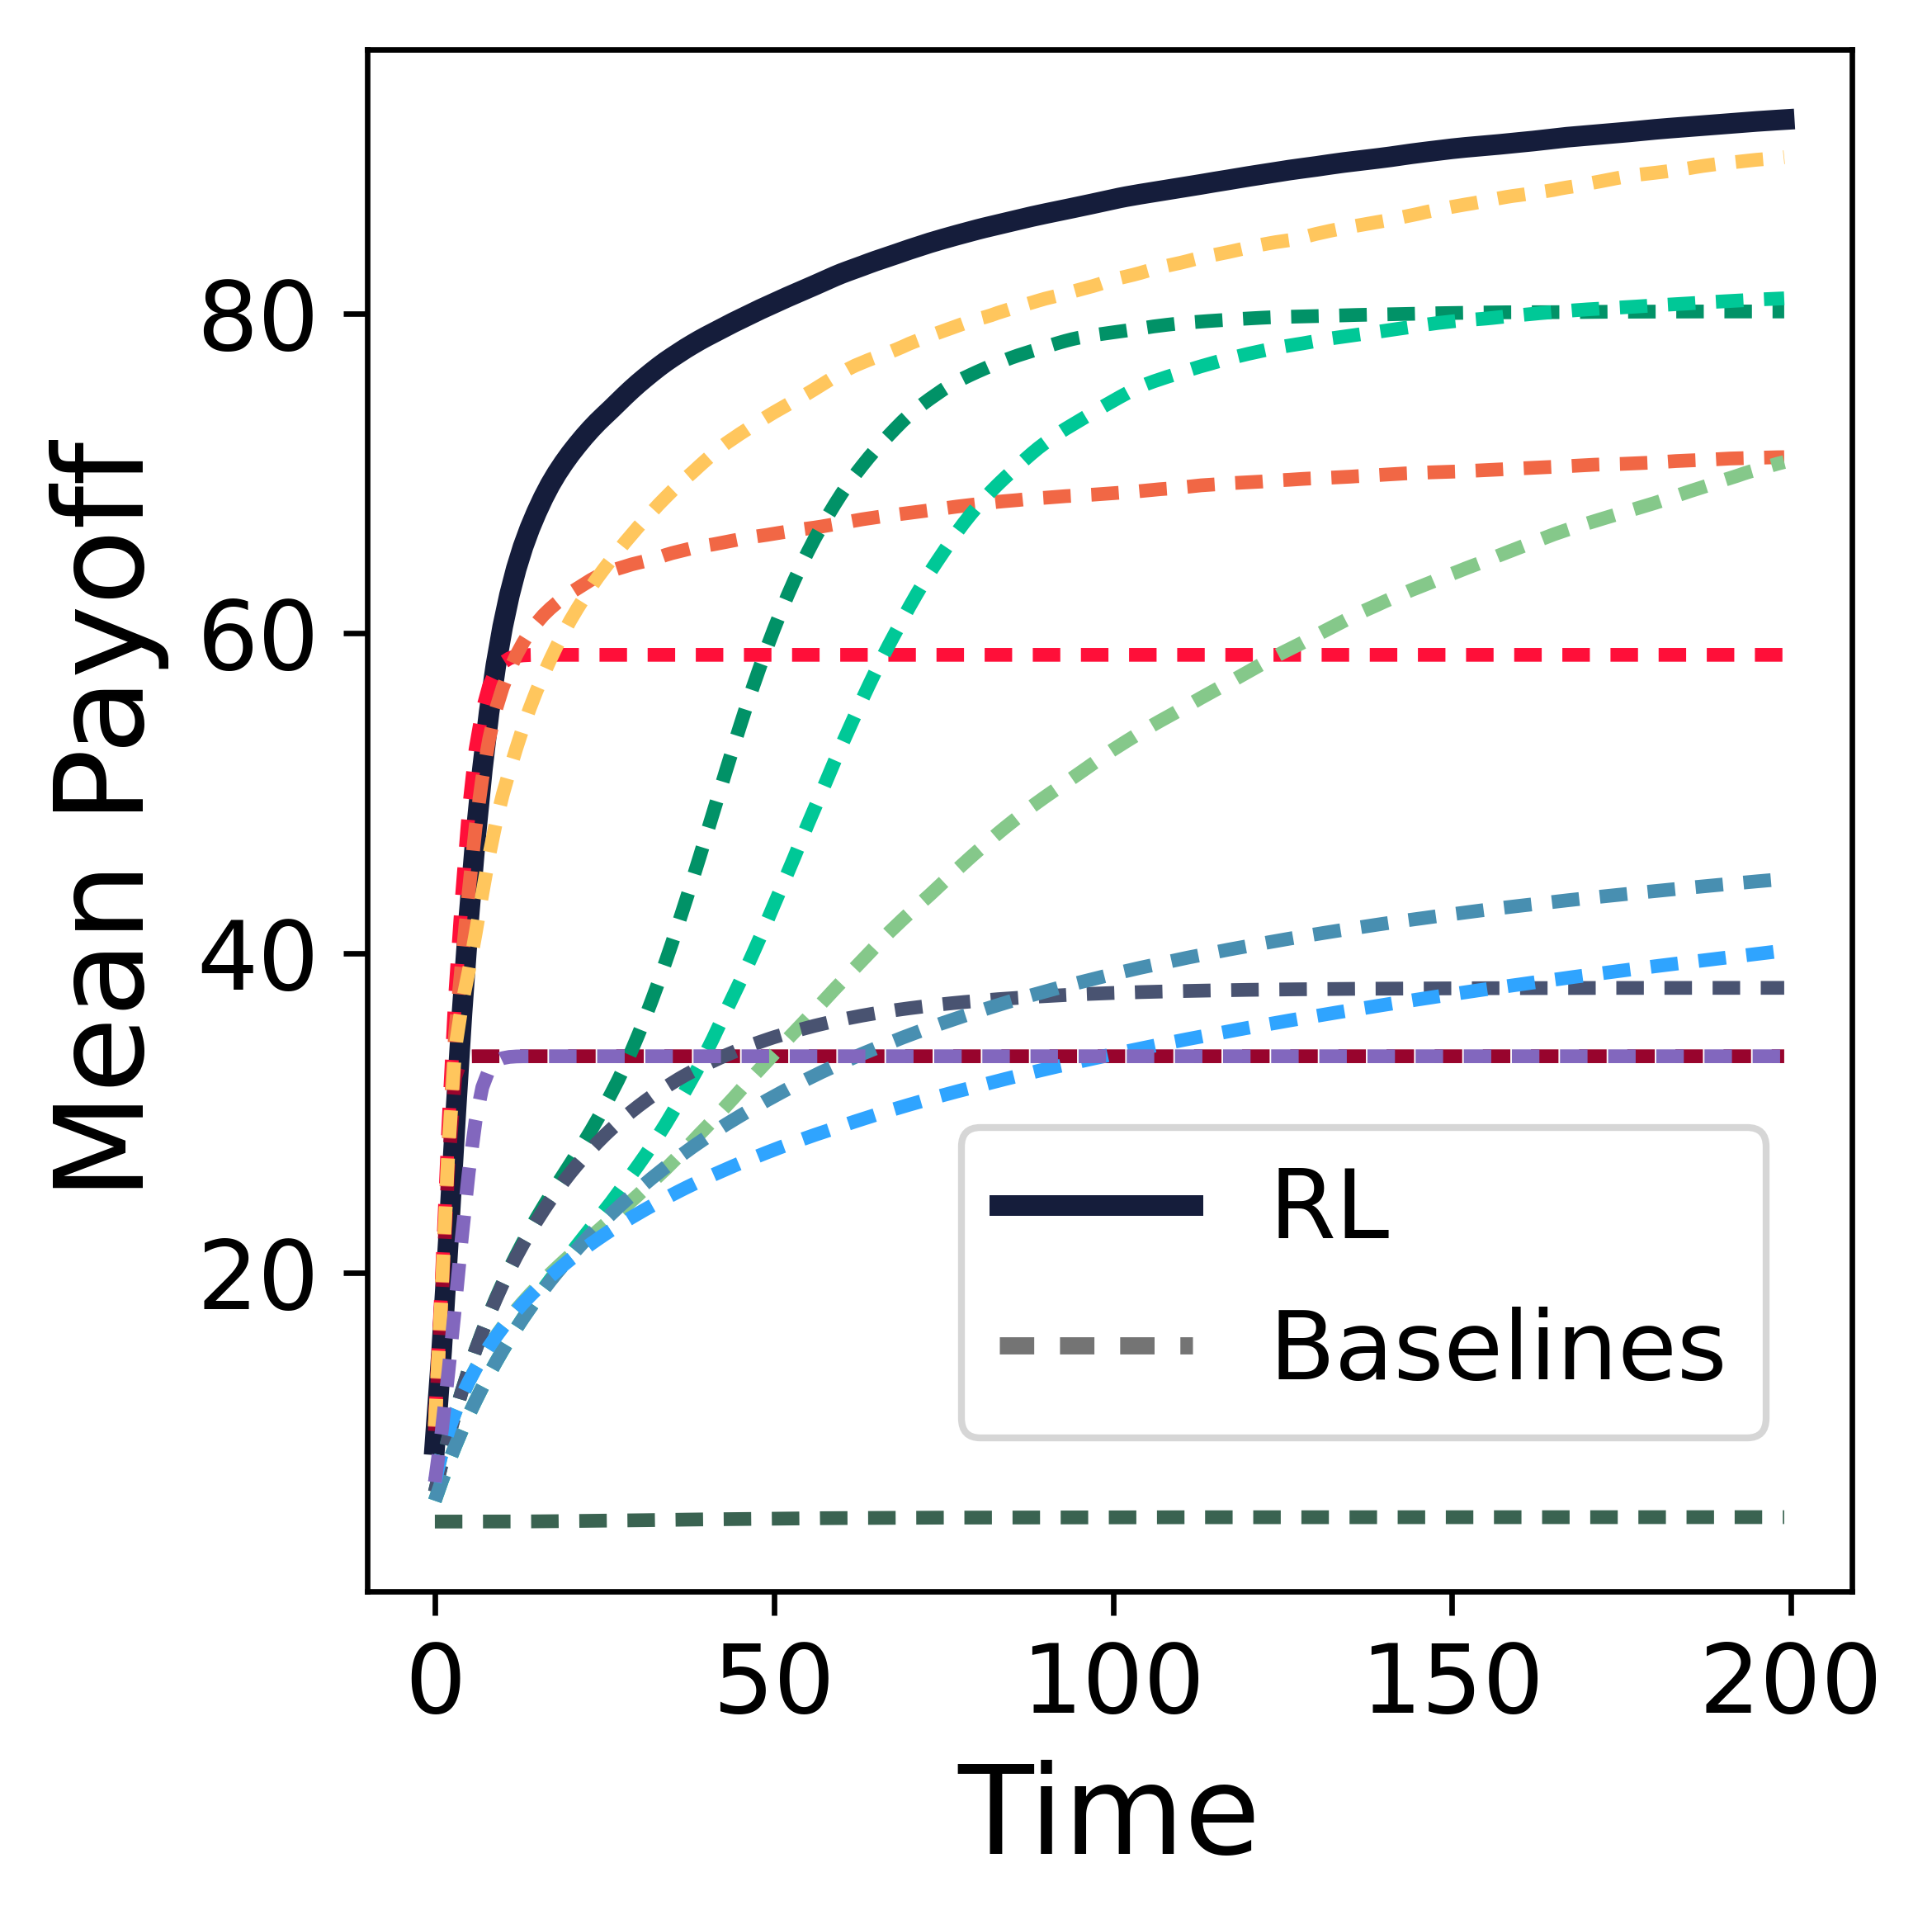

In [50]:
# Figure drawing
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(111)
color_list = ['#151D3B', 
              '#98042D', '#FF0F39', '#F16745', '#FFC65D',  
              '#3A6351', '#019267', '#00C897', '#85C88A',  
              '#495371', '#488FB1', '#2FA4FF',  
              '#8267BE', '#747474'] 
counter=0
order_dict = ['RL', 'BI', 'BI-I', 'BI-P', 'BI-R', 'CF', 'CF-I', 'CF-P', 'CF-R',  'PI-I', 'PI-P', 'PI-R', 'RI']
for baseline_name in order_dict:
    if baseline_name == 'RL':
        x = np.array([inspection_complete_dict['scr_buf_list'][i]*100 for i in range(len(inspection_complete_dict['scr_buf_list']))])
        ls = '-'
        lw = 3
    else:
        x = baseline_complete_dict[conversion_dict2[baseline_name]]['scr_buf']*100
        ls = (0, (2, 1.5))
        lw = 2
    avg_pf = np.mean(x, axis=tuple(range(0, len(x.shape) - 1)))
    std_pf = np.std(x, axis=tuple(range(0, len(x.shape) - 1)))
    ax.plot(np.arange(x.shape[-1]), avg_pf, c=color_list[counter], label=baseline_name, ls=ls, lw=lw)
    #ax.fill_between(np.arange(x.shape[-1]), avg_pf-std_pf, avg_pf+std_pf, facecolor=color_list[counter], alpha=0.2)
    counter+=1

ax.plot(np.arange(0), np.arange(0), ls=(0, (2, 1.5)), lw=2.5, c=color_list[counter], label='Baselines')
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Mean Payoff', fontsize=18)
ax.tick_params(axis = 'both', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
order = [0, -1]
#ax.legend(loc='lower right', fontsize=11, ncol=2)
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=(0.4, 0.1), fontsize=14, ncol=1)
plt.tight_layout()
plt.savefig('Fig3b.svg', transparent=True, dpi=300)

## Fig.3c

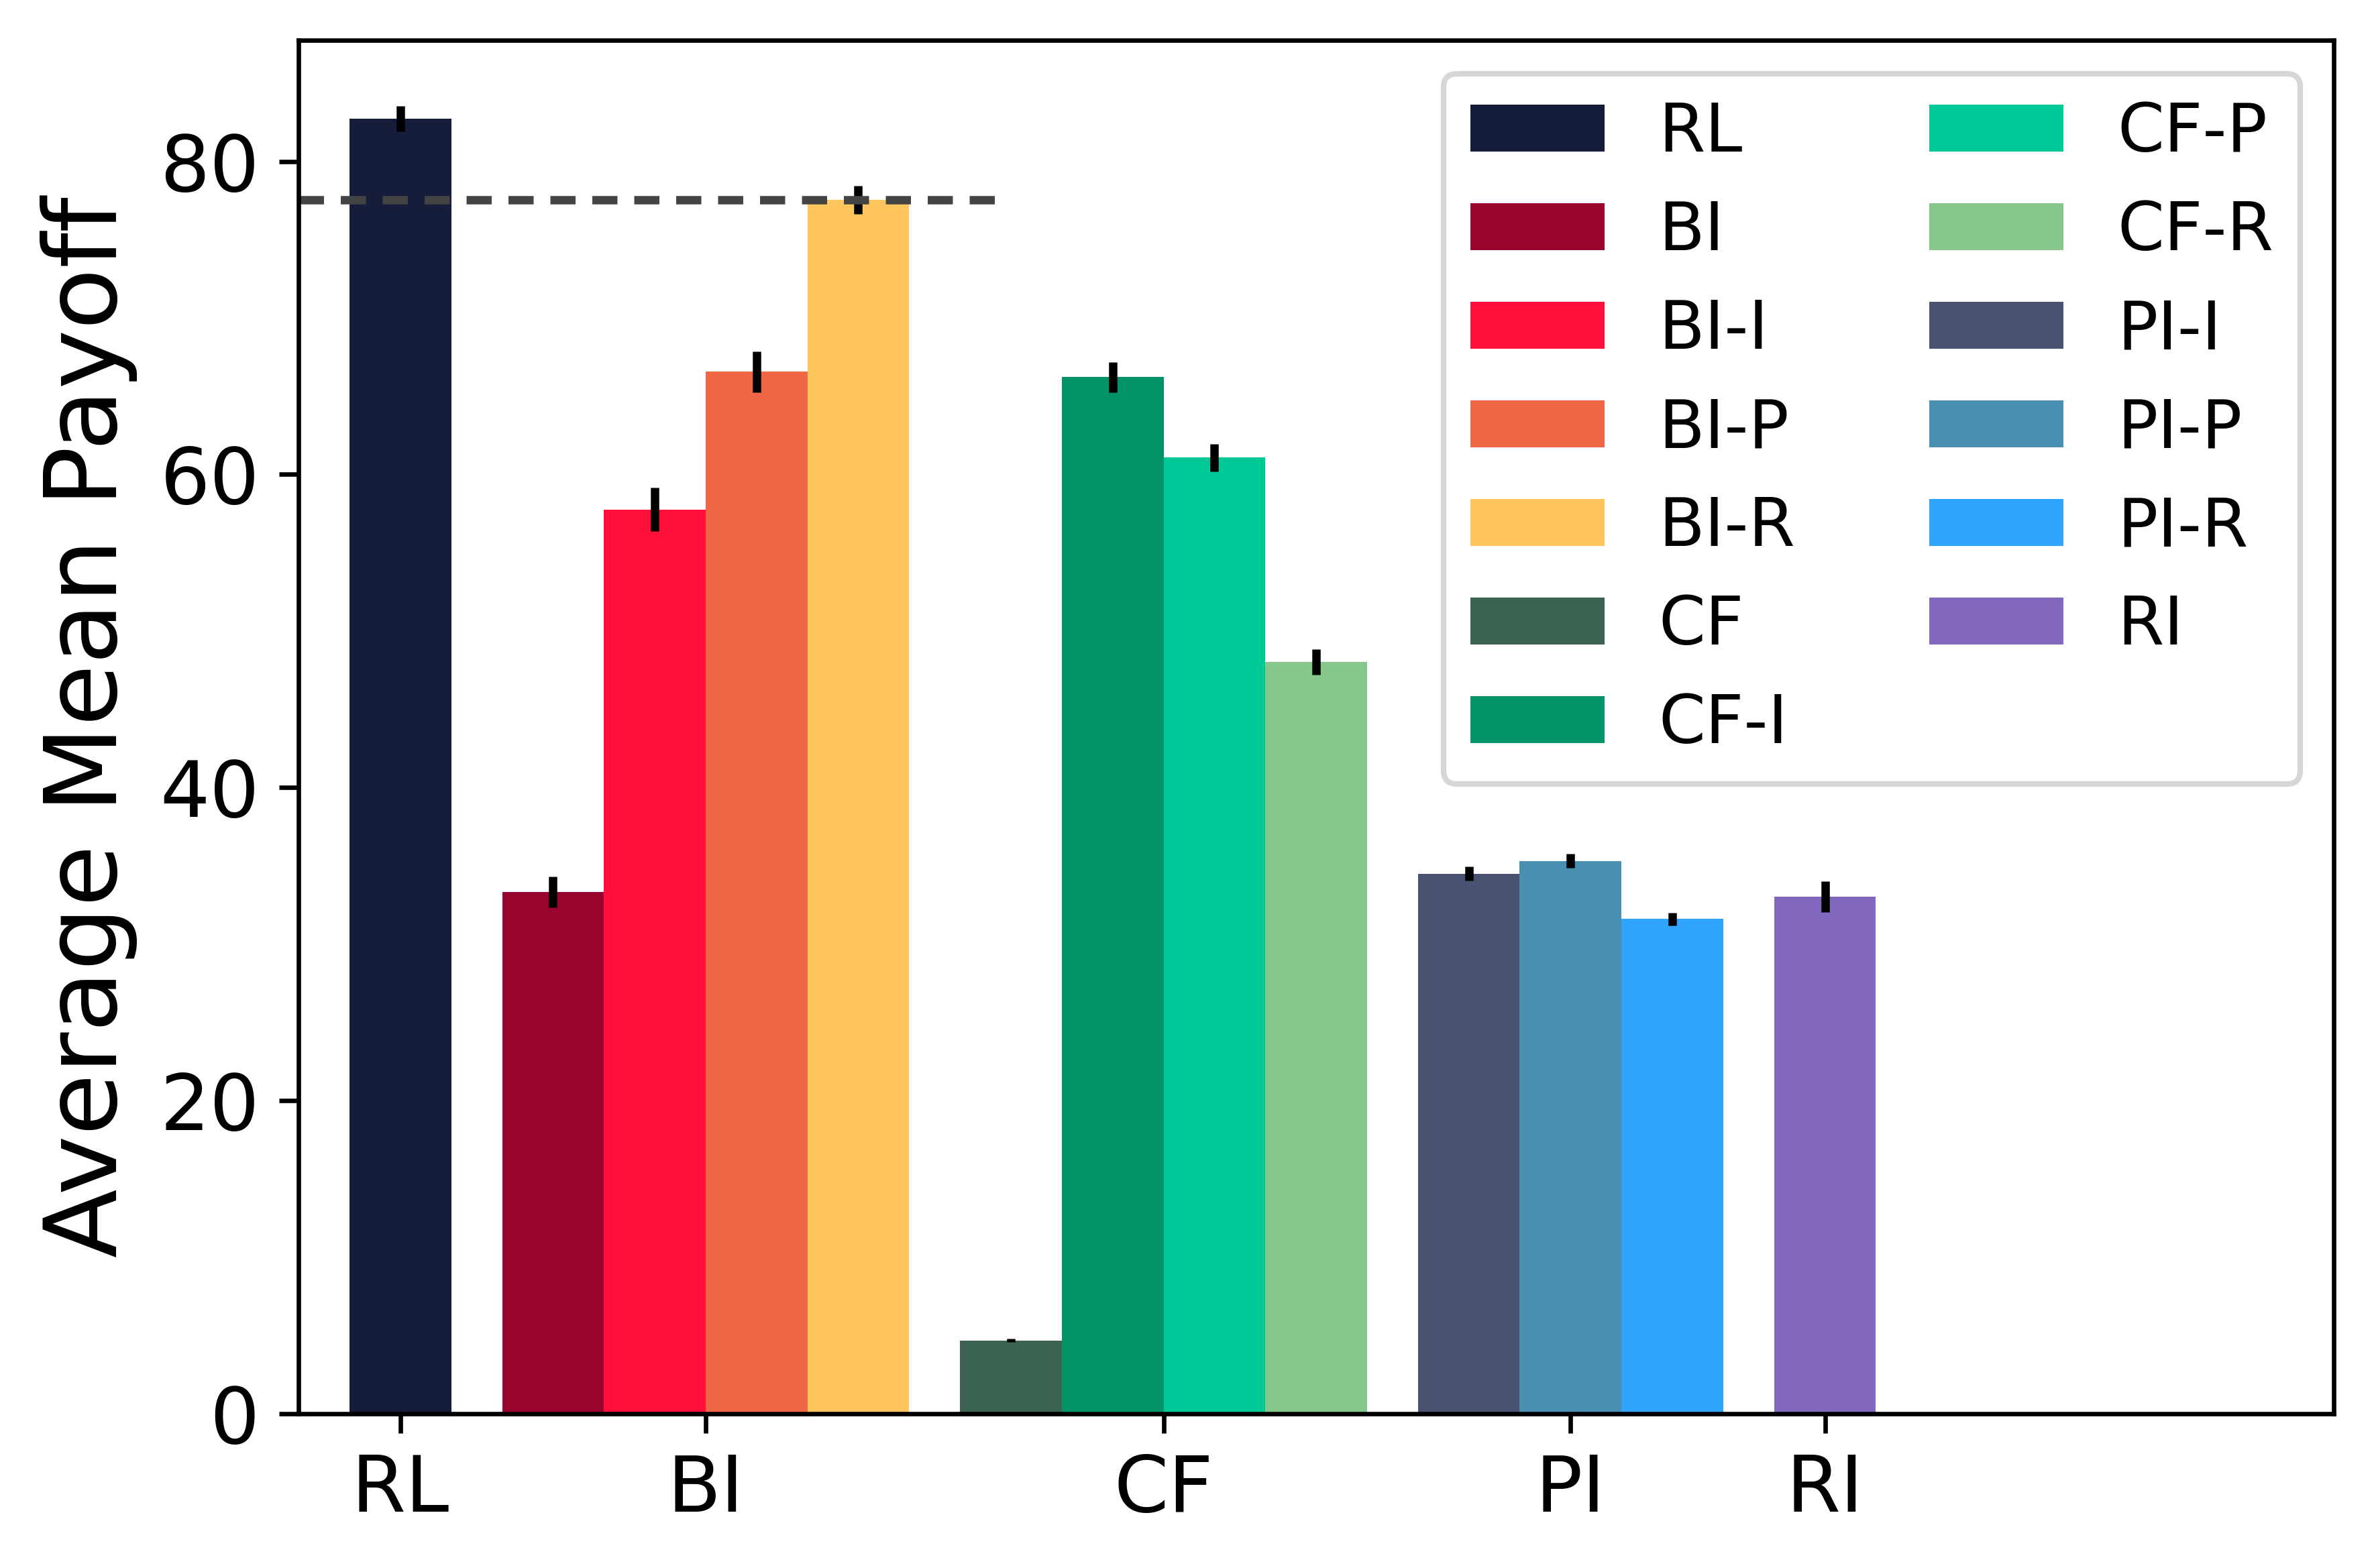

In [52]:
%matplotlib inline
fig = plt.figure(figsize=(6,4), dpi=300)
ax = fig.add_subplot(111)

labels = ['Average', 'Final']
color_list = ['#151D3B', 
              '#98042D', '#FF0F39', '#F16745', '#FFC65D',  
              '#3A6351', '#019267', '#00C897', '#85C88A',  
              '#495371', '#488FB1', '#2FA4FF',  
              '#8267BE', '#747474']
f = 0  # 0 : mean, 1 : final
width = 0.1
length = len(complete_dict)

if length%2: 
    start = -(length//2)*width
else: 
    start = -((length//2)-0.5)*width
offset = [start + i * width for i in range(length)]

offset[0] -= width/2

for i in range(5):
    offset[i] -= width/2

for i in range(9, length):
    offset[i] += width/2
    
offset[-1] += width/2

order_dict = ['RL', 'BI', 'BI-I', 'BI-P', 'BI-R', 'CF', 'CF-I', 'CF-P', 'CF-R',  'PI-I', 'PI-P', 'PI-R', 'RI']

for i, key in enumerate(order_dict):
    ax.bar(offset[i], complete_dict[key][f], width, label=key, color = color_list[i], yerr = 5 * np.array(complete_sem_dict[key])[f])

ax.set_ylabel('Average Mean Payoff', fontsize=18)
ax.set_xticks([-width * 7, -width * 4, width / 2, width * 4.5, width * 7])
ax.set_xticklabels(['RL', 'BI', 'CF', 'PI', 'RI'], fontsize=14)
ax.set_yticks([0, 20, 40, 60, 80])
ax.set_yticklabels(['0', '20', '40', '60', '80'], fontsize=14)
#ax.set_xlim(-1, 2)
#ax.legend(loc='lower right', ncol=3, fontsize=10)
ax.set_xlim(-0.8, 1.2)
ax.legend(loc='upper right', ncol=2, fontsize=12)
best_baseline = 'BI-R'
ax.hlines(complete_dict[best_baseline][f], offset[0]-width, offset[5], ls=(0, (3, 2)), color='#444444', lw=1.5)

plt.tight_layout()
plt.savefig('Fig3c.svg', transparent=True, dpi=300)

## Fig.3d

In [ ]:
# self score, SIRF
max_s = 100
s_list = [50]
%matplotlib inline

graph_type = 'complete'
exp_name = 'SIRF_TT_gene_ent_EC0.003_N15K7NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98'
#exp_name = 'test_test'
epoch = 4500
label = ''
rescale = False
extra_type = 'SIRF'
offset = 4
ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs = load_model(exp_name, epoch)
neighbor_num = env_kwargs['neighbor_num']

template = template_a1
template = np.c_[template, np.array([[-1, 0], [-1, 1 / neighbor_num], [-1, 1 / neighbor_num], [-1, 1 / neighbor_num]])]

for s in s_list:
    print(s)
    tc = coord_triplet(max_s+1)
    data = np.repeat(template.reshape(1, 4, 19), len(tc), axis=0).astype(np.float)
    tc = np.c_[np.ones(tc.shape[0])*s, tc]
    if rescale:
        data[:, :, -offset] = tc
    else:
        data[:, :, -offset] = tc / 100.
        
    score_rank = rankdata(tc, axis=-1, method='min') / (neighbor_num + 1)
    data[:, :, -2] = score_rank
    pi_list = []
    ent = 0
    for i in range((data.shape[0]//10000)+1):
        a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
        x = pi.probs[..., 1].detach().cpu().numpy()
        ent += pi.entropy().sum()
        pi_list.append(x)
        #print(x, pi.entropy().sum())
    pi_list = np.concatenate(pi_list, axis=0)
    ent /= data.shape[0] * 15
    print(ent)
    sp = template[0][:-offset]
    cp = template[-2][:-offset]
    hp = template[-1][:-offset]
    facecolors, sp_dist, cp_dist, hp_dist = assign_facecolors(pi_list, sp, cp, hp, True, True, True, max_s+1)
    stride = 5
    assert max_s%stride == 0
    facecolors = facecolors[::stride, ::stride, ::stride]
    #plot_cube(facecolors, stride = stride, angle=-75, name = f'{graph_type}_e{epoch}_s{s}_{label}', save=False)
    #plt.savefig(f'./Fig2d_4.svg', transparent=True, dpi=300)

In [ ]:
# small version

fig = plt.figure(figsize=(3.5, 4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(pi_list, aspect='auto', vmin=0, vmax=0.8, cmap='viridis', origin='lower')
#im = ax.imshow(pi_list, aspect='auto', vmin=0, vmax=1, cmap='plasma')

ax.set_xticks([])
ax.set_yticks([])
#plt.axis('off')
plt.tight_layout()
plt.savefig('Fig3d_4a.svg', transparent=True, dpi=300)

In [ ]:
# Frequency test
max_s = 100
s_list = [50]
%matplotlib inline
# complete_L200 2025
# complete_L200_2 2269
# complete_L300 2593
# maxmc_L100 4483
# maxmc_L200 3761
graph_type = 'complete'
#exp_name = 'SIRF_TT_gene_ent_EC0.003_N15K3NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98'
#epoch = 900
label = ''
rescale = False
extra_type = 'SIRF'
offset = 4
ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs = load_model(exp_name, epoch)
neighbor_num = env_kwargs['neighbor_num']

template_f1 = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, 0], 
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0, -1, 2 / neighbor_num],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0, -1, 2 / neighbor_num],
          [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, 1 / neighbor_num]])

template_f2 = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, 0], 
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, 1 / neighbor_num],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0, -1, 1 / neighbor_num],
          [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, 1 / neighbor_num]])

template = template_f1

for s in s_list:
    tc = coord_triplet(max_s+1)
    mask = [True if ((tc[i][1]<tc[i][2]) and (tc[i][0]==tc[i][1])) else False for i in range(len(tc))]
    tc = tc[mask]
    data = np.repeat(template.reshape(1, 4, 19), len(tc), axis=0).astype(np.float)
    tc = np.c_[np.ones(tc.shape[0])*s, tc]
    if rescale:
        data[:, :, -offset] = tc
    else:
        data[:, :, -offset] = tc / 100.
        
    score_rank = rankdata(tc, axis=-1, method='min') / (neighbor_num + 1)
    data[:, :, -2] = score_rank
    pi_list = []
    ent = 0
    for i in range((data.shape[0]//10000)+1):
        a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
        x = pi.probs[..., 1].detach().cpu().numpy()
        ent += pi.entropy().sum()
        pi_list.append(x)
        #print(x, pi.entropy().sum())
    pi_list = np.concatenate(pi_list, axis=0)
    sp = template[0][:-offset]
    cp = template[-2][:-offset]
    hp = template[-1][:-offset]
    facecolors, sp_dist, cp_dist, hp_dist = assign_facecolors_freq(pi_list, sp, cp, hp, True, True, True, max_s+1)
    stride = 5
    assert max_s%stride == 0
    #facecolors = facecolors[::stride, ::stride, ::stride]
    #plot_cube(facecolors, stride = stride, angle=-75, name = f'{graph_type}_e{epoch}_s{s}_{label}', save=False)

In [ ]:
fig = plt.figure(figsize=(3.5, 4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(pi_list, aspect='auto', vmin=0, vmax=0.8, cmap='viridis', origin='lower')

ax.set_xticks([])
ax.set_yticks([])
#plt.axis('off')
plt.tight_layout()
#pl.gca().set_visible(False)
plt.savefig('Fig3d_4b.svg', transparent=True, dpi=300)

In [ ]:
tc

In [ ]:
fig = plt.figure(figsize=(3.5, 4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(pi_list, aspect='auto', vmin=0, vmax=0.8, cmap='viridis')

ax.set_xticks([])
ax.set_yticks([])
plt.gca().set_visible(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)
cbar = plt.colorbar(im, cax=cax, ticks=[0.0, 0.4, 0.8])
cbar.ax.tick_params(labelsize=32)

#cbar.ax.set_xticklabels(['0.3', '0.4', '0.5', '0.6'])

plt.tight_layout()
plt.savefig('Fig3d_colorbar.svg', transparent=True, dpi=300)

# Fig.4

In [ ]:
# self score, SIRF
max_s = 100
s_list = [70]
%matplotlib inline

graph_type = 'complete'
exp_name = 'SIRF_TT_gene_ent_EC0.003_N15K7NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98_cp_E5400'
#exp_name = 'test_test'
epoch = 550
label = ''
rescale = False
extra_type = 'SIRF'
offset = 4
ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs = load_model(exp_name, epoch)
neighbor_num = env_kwargs['neighbor_num']

template = template_a1
template = np.c_[template, np.array([[-1, 0], [-1, 1 / neighbor_num], [-1, 1 / neighbor_num], [-1, 1 / neighbor_num]])]

for s in s_list:
    print(s)
    tc = coord_triplet(max_s+1)
    data = np.repeat(template.reshape(1, 4, 19), len(tc), axis=0).astype(np.float)
    tc = np.c_[np.ones(tc.shape[0])*s, tc]
    if rescale:
        data[:, :, -offset] = tc
    else:
        data[:, :, -offset] = tc / 100.
        
    score_rank = rankdata(tc, axis=-1, method='min') / (neighbor_num + 1)
    data[:, :, -2] = score_rank
    pi_list = []
    ent = 0
    for i in range((data.shape[0]//10000)+1):
        a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
        x = pi.probs[..., 1].detach().cpu().numpy()
        ent += pi.entropy().sum()
        pi_list.append(x)
        #print(x, pi.entropy().sum())
    pi_list = np.concatenate(pi_list, axis=0)
    ent /= data.shape[0] * 15
    print(ent)
    sp = template[0][:-offset]
    cp = template[-2][:-offset]
    hp = template[-1][:-offset]
    facecolors, sp_dist, cp_dist, hp_dist = assign_facecolors(pi_list, sp, cp, hp, True, True, True, max_s+1)
    stride = 5
    assert max_s%stride == 0
    #facecolors = facecolors[::stride, ::stride, ::stride]
    #plot_cube(facecolors, stride = stride, angle=-75, name = f'{graph_type}_e{epoch}_s{s}_{label}', save=False)
    #plt.savefig(f'./Fig3b_2.svg', transparent=True, dpi=300)

## Fig. 4a

In [ ]:
fig = plt.figure(figsize=(3.5, 4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(pi_list, aspect='auto', vmin=0, vmax=1, cmap='viridis', origin='lower')

ax.set_xticks([])

ax.set_xticks([1, 5, 9, 13])
ax.set_xticklabels(['Self', 'Best', 'Second', 'Third'], fontsize=14)

ax.set_yticks([])
#ax.set_yticks([0, 83140, 176851])
#ax.set_yticklabels(['(50, 0, \n0, 0)', '(50, 20, \n20, 20)', '(50, 100, \n100, 100)',], fontsize=14)
#ax.set_yticklabels(['', '', ''])

#ax.set_ylabel('Average Mean Payoff', fontsize=18)

#ax.tick_params(axis = 'both', labelsize=14)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('Fig4a_2.svg', transparent=True, dpi=300)

In [ ]:
# small version

fig = plt.figure(figsize=(4, 2), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(pi_list[:101], aspect='auto', vmin=0, vmax=1.0, cmap='viridis', origin='lower')
#im = ax.imshow(pi_list, aspect='auto', vmin=0, vmax=1, cmap='plasma')

ax.set_xticks([])
ax.set_yticks([0, 50, 100])
ax.set_ylim(0, 101)
#plt.axis('off')
ax.hlines(70, -0.5, 10, lw=3, ls='--', color='w')
ax.tick_params(axis = 'both', labelsize=20)
plt.tight_layout()
plt.savefig('Fig4c_2.svg', transparent=True, dpi=300)

# Fig. 5

In [54]:
# MaxMC

with open(f'./result/baseline_maxmc_N15K7NN3.pkl', 'rb') as f:
    baseline_complete_dict = pickle.load(f)
with open('./result/inspection_dict/inspection_dict_maxmc_E6250_maxmc.pkl', 'rb') as f:
    inspection_complete_dict = pickle.load(f)

In [64]:
# L50R4

with open(f'./result/baseline_complete_N15K7NN3_exp8_L50R4.pkl', 'rb') as f:
    baseline_complete_dict = pickle.load(f)
with open('./result/inspection_dict/inspection_dict_L50R4_E5200_L50R4.pkl', 'rb') as f:
    inspection_complete_dict = pickle.load(f)

In [70]:
# L400

with open(f'./result/baseline_complete_N15K3NN3_exp8_L400.pkl', 'rb') as f:
    baseline_complete_dict = pickle.load(f)
with open('./result/inspection_dict/inspection_dict_L400_E4300_L400.pkl', 'rb') as f:
    inspection_complete_dict = pickle.load(f)

In [ ]:
# NN9

with open(f'./result/XX.pkl', 'rb') as f:
    baseline_complete_dict = pickle.load(f)
with open('./result/inspection_dict/XX.pkl', 'rb') as f:
    inspection_complete_dict = pickle.load(f)

In [71]:
complete_dict = {}
complete_sem_dict = {}
for key in baseline_complete_dict.keys():
    if key != 'keys':
        complete_dict[conversion_dict1[key]] = [np.mean(baseline_complete_dict[key]['scr_buf']*100), 
                                                     np.mean(baseline_complete_dict[key]['scr_buf'][..., -1])*100]
        complete_sem_dict[conversion_dict1[key]] = [np.std(np.mean(baseline_complete_dict[key]['scr_buf'], axis=(-2, -1)))/np.sqrt(5000)*100, 
                                                     np.std(np.mean(baseline_complete_dict[key]['scr_buf'][..., -1], axis=-1))/np.sqrt(5000)*100]

In [72]:
Ret_list = []
FinalScore_list = []

for i in range(len(inspection_complete_dict['scr_buf_list'])):
    Ret_list.append(inspection_complete_dict['scr_buf_list'][i]*100)
    FinalScore_list.append(inspection_complete_dict['scr_buf_list'][i][:, :, -1]*100)

Ret_list = np.array(Ret_list)
FinalScore_list = np.array(FinalScore_list)

complete_dict['RL'] = [np.mean(Ret_list), 
                       np.mean(FinalScore_list)]
complete_sem_dict['RL'] = [np.std(np.mean(Ret_list, axis=(-2, -1)))/np.sqrt(5000), 
                           np.std(np.mean(FinalScore_list, axis=-1))/np.sqrt(5000)]

## Fig. 5-1

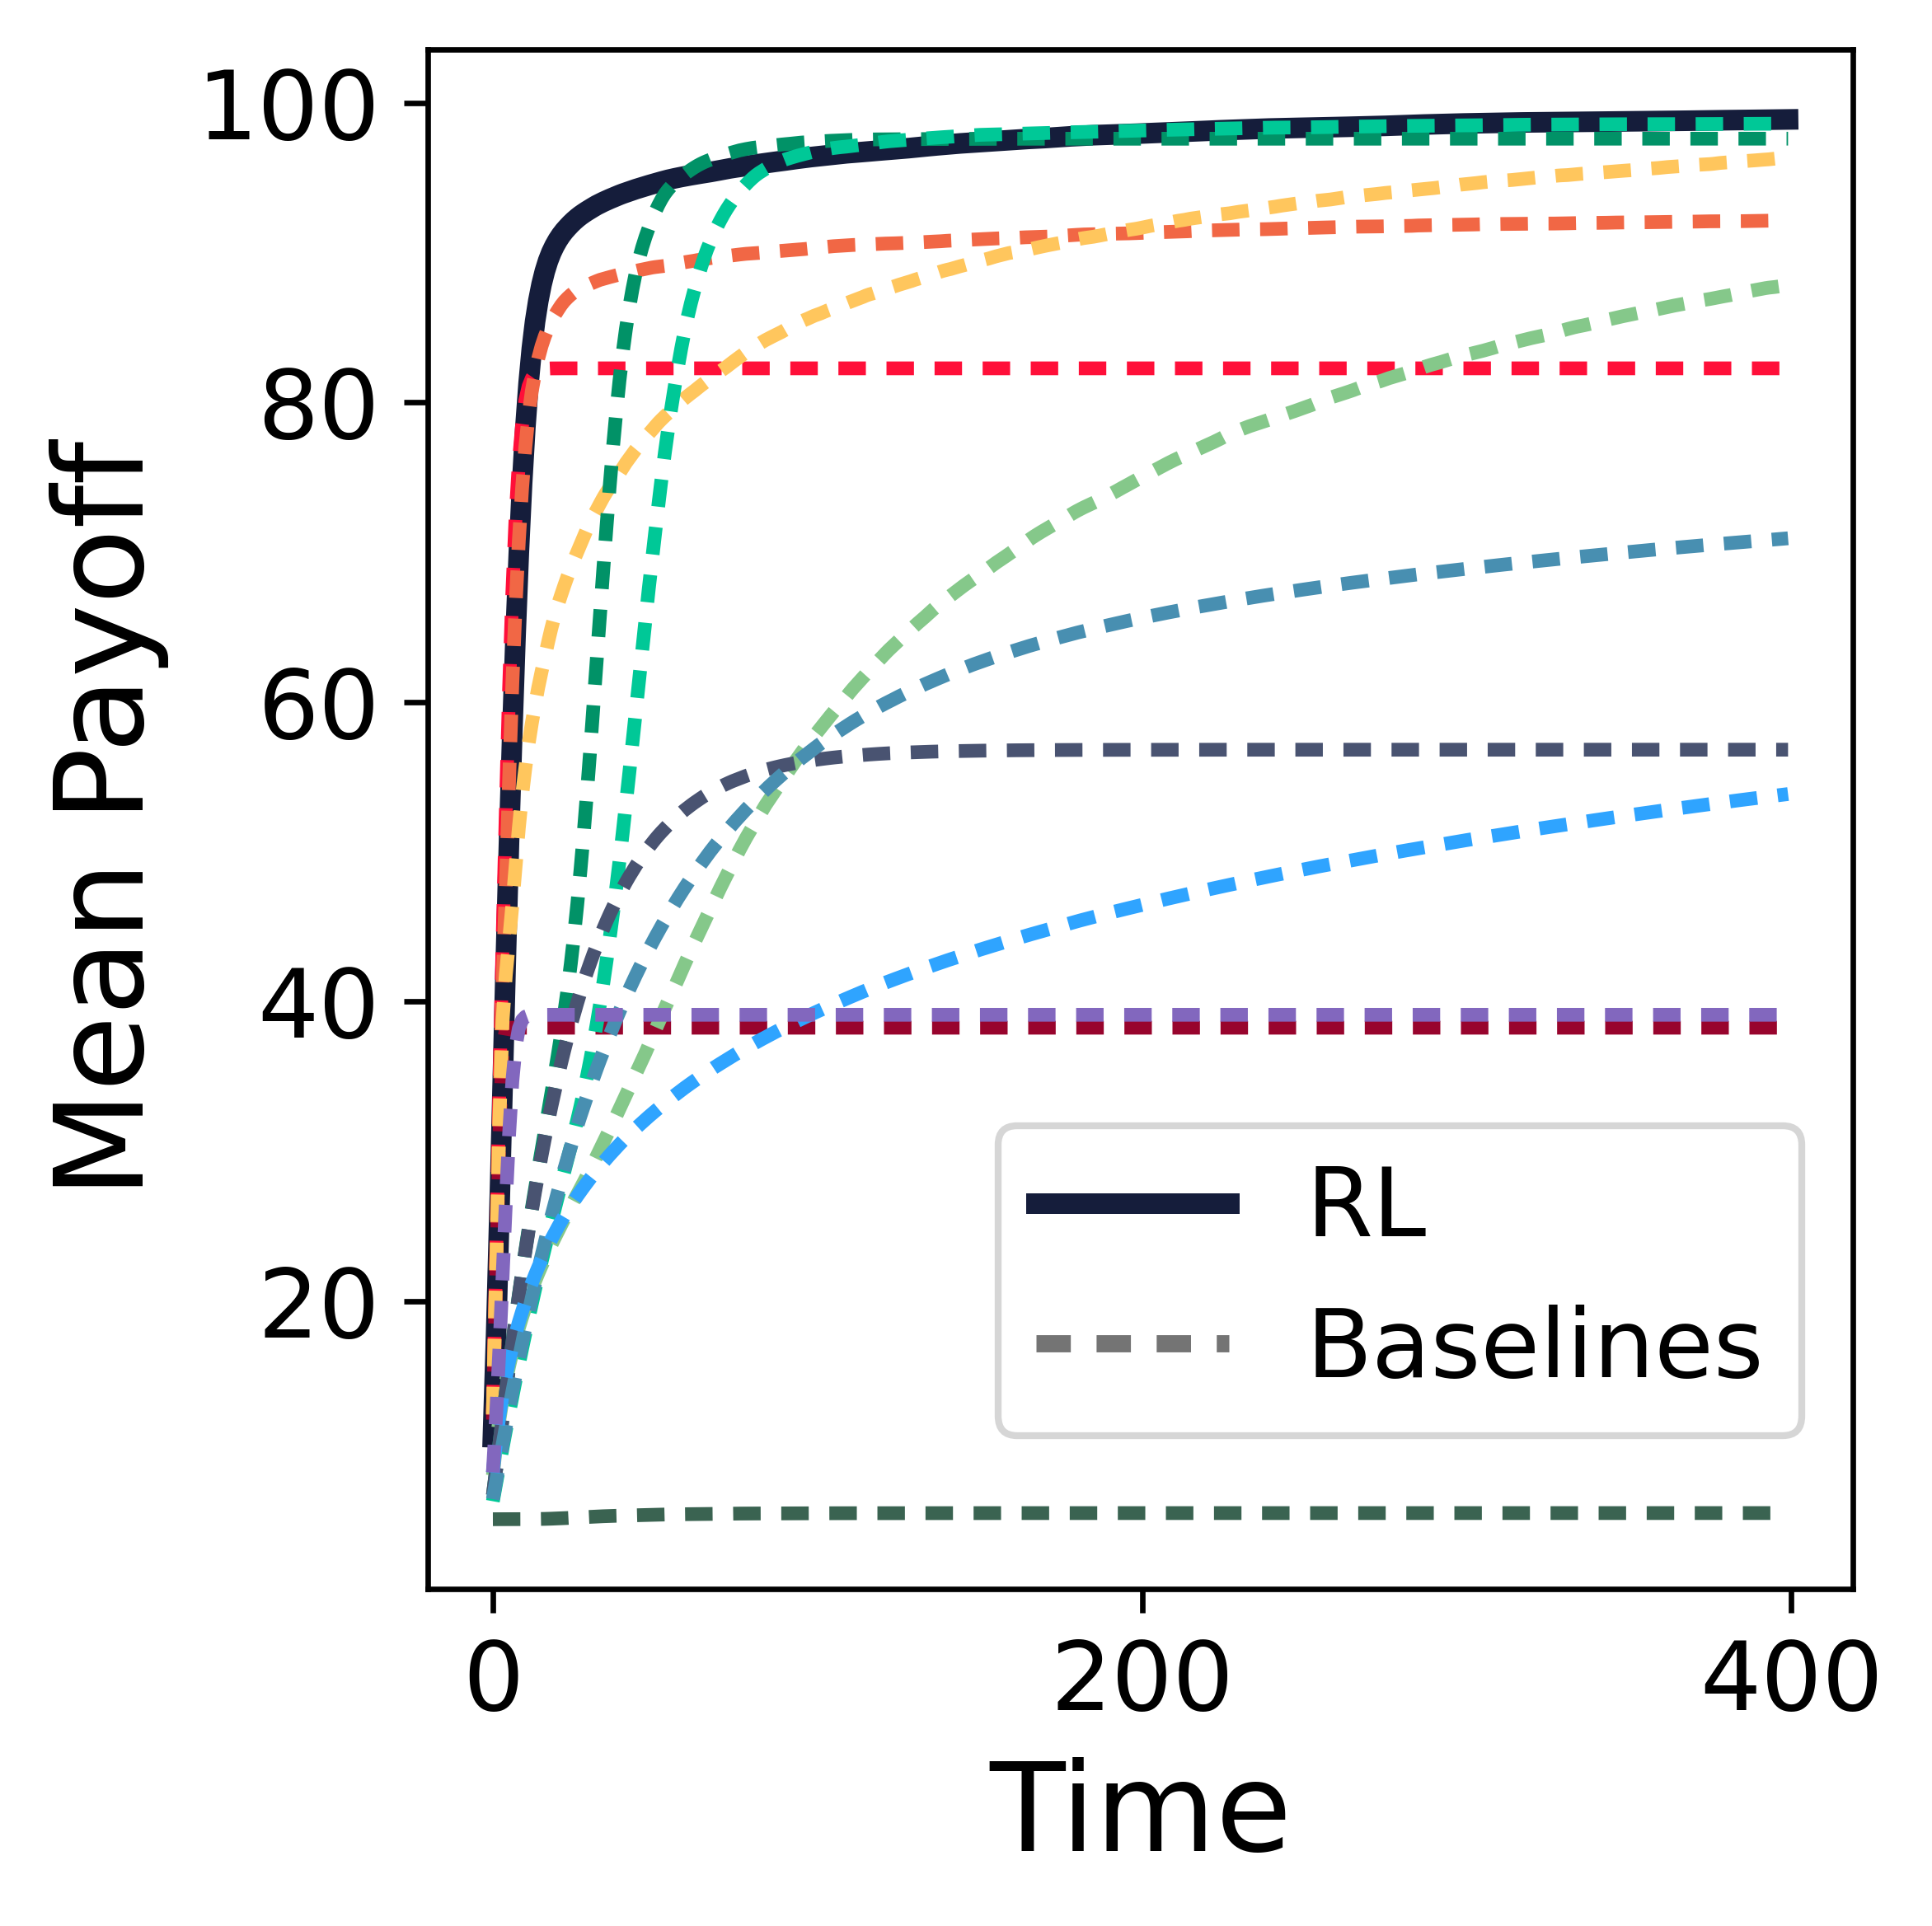

In [73]:
# Figure drawing
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(111)
color_list = ['#151D3B', 
              '#98042D', '#FF0F39', '#F16745', '#FFC65D',  
              '#3A6351', '#019267', '#00C897', '#85C88A',  
              '#495371', '#488FB1', '#2FA4FF',  
              '#8267BE', '#747474'] 
counter=0
order_dict = ['RL', 'BI', 'BI-I', 'BI-P', 'BI-R', 'CF', 'CF-I', 'CF-P', 'CF-R',  'PI-I', 'PI-P', 'PI-R', 'RI']
for baseline_name in order_dict:
    if baseline_name == 'RL':
        x = np.array([inspection_complete_dict['scr_buf_list'][i]*100 for i in range(len(inspection_complete_dict['scr_buf_list']))])
        ls = '-'
        lw = 3
    else:
        x = baseline_complete_dict[conversion_dict2[baseline_name]]['scr_buf']*100
        ls = (0, (2, 1.5))
        lw = 2
    avg_pf = np.mean(x, axis=tuple(range(0, len(x.shape) - 1)))
    std_pf = np.std(x, axis=tuple(range(0, len(x.shape) - 1)))
    ax.plot(np.arange(x.shape[-1]), avg_pf, c=color_list[counter], label=baseline_name, ls=ls, lw=lw)
    #ax.fill_between(np.arange(x.shape[-1]), avg_pf-std_pf, avg_pf+std_pf, facecolor=color_list[counter], alpha=0.2)
    counter+=1

ax.plot(np.arange(0), np.arange(0), ls=(0, (2, 1.5)), lw=2.5, c=color_list[counter], label='Baselines')

ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Mean Payoff', fontsize=18)
ax.tick_params(axis = 'both', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
order = [0, -1]
#ax.legend(loc='lower right', fontsize=11, ncol=2)
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=(0.4, 0.1), fontsize=14, ncol=1)
plt.tight_layout()
plt.savefig('Fig5c_1.svg', transparent=True, dpi=300)

## Fig. 5-2

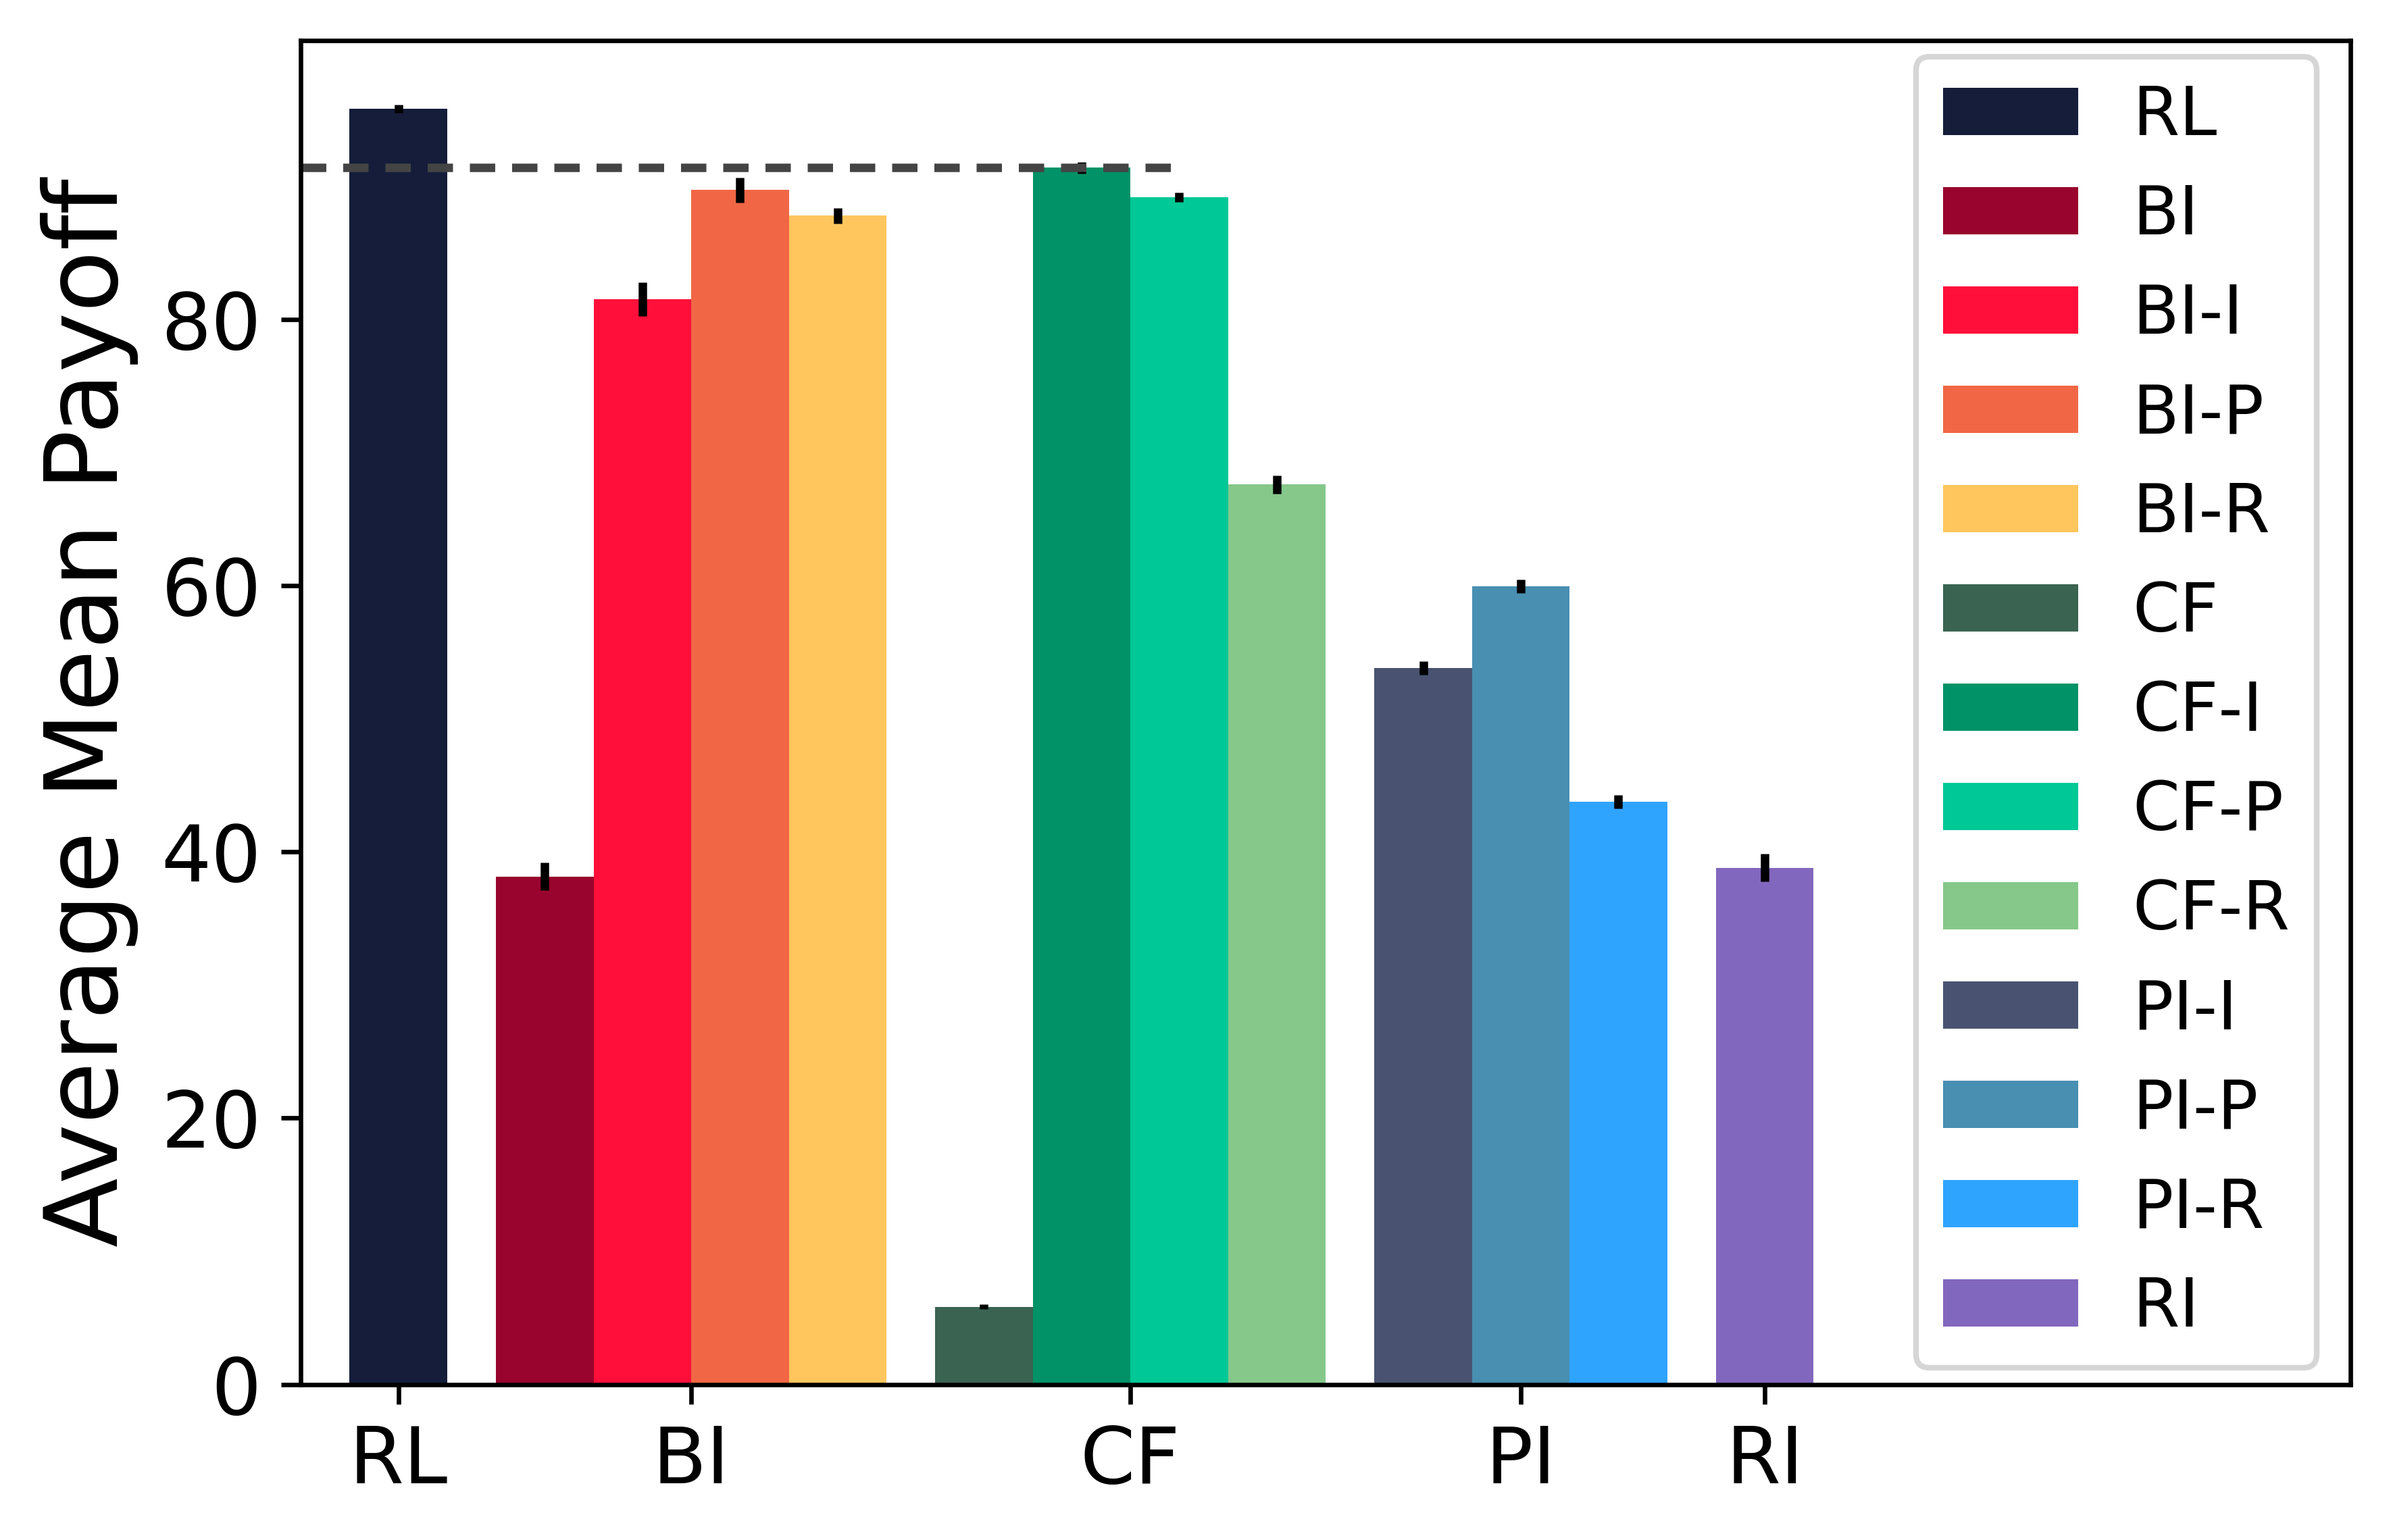

In [74]:
%matplotlib inline
fig = plt.figure(figsize=(6,4), dpi=300)
ax = fig.add_subplot(111)

labels = ['Average', 'Final']
color_list = ['#151D3B', 
              '#98042D', '#FF0F39', '#F16745', '#FFC65D',  
              '#3A6351', '#019267', '#00C897', '#85C88A',  
              '#495371', '#488FB1', '#2FA4FF',  
              '#8267BE', '#747474']
f = 0  # 0 : mean, 1 : final
width = 0.1
length = len(complete_dict)

if length%2: 
    start = -(length//2)*width
else: 
    start = -((length//2)-0.5)*width
offset = [start + i * width for i in range(length)]

offset[0] -= width/2

for i in range(5):
    offset[i] -= width/2

for i in range(9, length):
    offset[i] += width/2
    
offset[-1] += width/2

order_dict = ['RL', 'BI', 'BI-I', 'BI-P', 'BI-R', 'CF', 'CF-I', 'CF-P', 'CF-R',  'PI-I', 'PI-P', 'PI-R', 'RI']

for i, key in enumerate(order_dict):
    ax.bar(offset[i], complete_dict[key][f], width, label=key, color = color_list[i], yerr = 5 * np.array(complete_sem_dict[key])[f])

ax.set_ylabel('Average Mean Payoff', fontsize=18)
ax.set_xticks([-width * 7, -width * 4, width / 2, width * 4.5, width * 7])
ax.set_xticklabels(['RL', 'BI', 'CF', 'PI', 'RI'], fontsize=14)
ax.set_yticks([0, 20, 40, 60, 80])
ax.set_yticklabels(['0', '20', '40', '60', '80'], fontsize=14)
#ax.set_xlim(-1, 2)
#ax.legend(loc='lower right', ncol=3, fontsize=10)
ax.set_xlim(-0.8, 1.3)
ax.legend(loc='center right', ncol=1, fontsize=12)
best_baseline = 'CF-I'
ax.hlines(complete_dict[best_baseline][f], offset[0]-width, offset[7], ls=(0, (3, 2)), color='#444444', lw=1.5)

plt.tight_layout()
plt.savefig('Fig5c_2.svg', transparent=True, dpi=300)

## Fig.5-3

In [ ]:
# self score, SIRF
max_s = 100
s_list = [50]
%matplotlib inline

graph_type = 'complete'
#exp_name = 'SIRF_TT_gene_ent_EC0.003_N15K7NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98_L50R4'
exp_name = 'SIRF_TT_gene_ent_EC0.003_N15K3NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98_L400'
#exp_name = 'test_test'
#epoch = 5200
epoch = 4300
label = ''
rescale = False
extra_type = 'SIRF'
offset = 4
ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs = load_model(exp_name, epoch)
neighbor_num = env_kwargs['neighbor_num']

template = template_a1
template = np.c_[template, np.array([[-1, 0], [-1, 1 / neighbor_num], [-1, 1 / neighbor_num], [-1, 1 / neighbor_num]])]

for s in s_list:
    print(s)
    tc = coord_triplet(max_s+1)
    data = np.repeat(template.reshape(1, 4, 19), len(tc), axis=0).astype(np.float)
    tc = np.c_[np.ones(tc.shape[0])*s, tc]
    if rescale:
        data[:, :, -offset] = tc
    else:
        data[:, :, -offset] = tc / 100.
        
    score_rank = rankdata(tc, axis=-1, method='min') / (neighbor_num + 1)
    data[:, :, -2] = score_rank
    pi_list = []
    ent = 0
    for i in range((data.shape[0]//10000)+1):
        a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
        x = pi.probs[..., 1].detach().cpu().numpy()
        ent += pi.entropy().sum()
        pi_list.append(x)
        #print(x, pi.entropy().sum())
    pi_list = np.concatenate(pi_list, axis=0)
    ent /= data.shape[0] * 15
    print(ent)
    sp = template[0][:-offset]
    cp = template[-2][:-offset]
    hp = template[-1][:-offset]
    facecolors, sp_dist, cp_dist, hp_dist = assign_facecolors(pi_list, sp, cp, hp, True, True, True, max_s+1)
    stride = 5
    assert max_s%stride == 0
    facecolors = facecolors[::stride, ::stride, ::stride]
    #plot_cube(facecolors, stride = stride, angle=-75, name = f'{graph_type}_e{epoch}_s{s}_{label}', save=False)
    #plt.savefig(f'./Fig5b_3.svg', transparent=True, dpi=300)

## Fig.5-4

In [ ]:
fig = plt.figure(figsize=(3.5, 4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(pi_list, aspect='auto', vmin=0, vmax=1, cmap='viridis', origin='lower')

ax.set_xticks([])

ax.set_xticks([1, 5, 9, 13])
ax.set_xticklabels(['Self', 'Best', 'Second', 'Third'], fontsize=14)

ax.set_yticks([])
#ax.set_yticks([0, 83140, 176851])
#ax.set_yticklabels(['(50, 0, \n0, 0)', '(50, 20, \n20, 20)', '(50, 100, \n100, 100)',], fontsize=14)
#ax.set_yticklabels(['', '', ''])

#ax.set_ylabel('Average Mean Payoff', fontsize=18)

#ax.tick_params(axis = 'both', labelsize=14)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
#plt.savefig('Fig5c_4.svg', transparent=True, dpi=300)

In [ ]:
# small version

fig = plt.figure(figsize=(4, 2), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(pi_list[:101], aspect='auto', vmin=0, vmax=1.0, cmap='viridis', origin='lower')
#im = ax.imshow(pi_list, aspect='auto', vmin=0, vmax=1, cmap='plasma')

ax.set_xticks([])
ax.set_yticks([0, 50, 100])
ax.set_ylim(0, 100)
#plt.axis('off')
ax.hlines(50, -0.5, 10, lw=3, ls='--', color='w')
ax.tick_params(axis = 'both', labelsize=20)
plt.tight_layout()
#plt.savefig('Fig4c_2.svg', transparent=True, dpi=300)

In [ ]:
# small version

fig = plt.figure(figsize=(2, 2), dpi=150)
ax = fig.add_subplot(111)

im = ax.imshow(pi_list[:100], aspect='auto', vmin=0, vmax=1.0, cmap='viridis', origin='lower')
#im = ax.imshow(pi_list, aspect='auto', vmin=0, vmax=1, cmap='plasma')

ax.set_xticks([])
ax.set_yticks([0, 50, 100])
ax.set_ylim(0, 100)
#plt.axis('off')
ax.hlines(50, -0.5, 10, lw=3, ls='--', color='w')
ax.tick_params(axis = 'both', labelsize=20)
plt.tight_layout()
#plt.savefig('Fig4c_2.svg', transparent=True, dpi=300)

### props

In [ ]:
import networkx as nx
from utils.utils import max_mean_clustering_network

In [ ]:
G = nx.complete_graph(100)
fig = plt.figure(figsize=(4, 4), dpi=150)
ax = fig.add_subplot(111)
nx.draw_networkx(G, pos = nx.nx_pydot.graphviz_layout(G), ax = ax, with_labels=False, 
                 node_size=30, node_color = '#0476D0',
                width=1, edge_color='#0476D0', edgecolors='k')
plt.axis('off')
plt.savefig('complete_network.png', dpi=150, transparent=True)

In [ ]:
G = max_mean_clustering_network(100)
fig = plt.figure(figsize=(4, 4), dpi=150)
ax = fig.add_subplot(111)
nx.draw_networkx(G, pos = nx.nx_pydot.graphviz_layout(G), ax = ax, with_labels=False, 
                 node_size=30, node_color = '#43B0F1',
                width=1, edge_color='#43B0F1', edgecolors='k')
plt.axis('off')
plt.savefig('maxmc_network.png', dpi=150, transparent=True)
# '#041F60', '#0476D0', 

In [ ]:
np.zeros((10, 3))

# Figure 6

In [ ]:
# self score, SIRF
max_s = 100
%matplotlib inline

graph_type = 'complete'
exp_list = [('SIRF_TT_gene_ent_EC0.003_N15K7NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98_cp_E5400', 550),
           ('maxmc_SIRF_TT_gene_ent_EC0.003_N15K7NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98', 6400),
           ('SIRF_TT_gene_ent_EC0.003_N15K7NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98_L50R4', 5200),
           ('SIRF_TT_gene_ent_EC0.003_N15K3NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98_L400', 4300)]

zoom_list_dict = {'SIRF_TT_gene_ent_EC0.003_N15K7NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98_cp_E5400': np.zeros((101, 101, 15)),
                 'maxmc_SIRF_TT_gene_ent_EC0.003_N15K7NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98': np.zeros((101, 101, 15)),
                 'SIRF_TT_gene_ent_EC0.003_N15K7NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98_L50R4': np.zeros((101, 101, 15)),
                 'SIRF_TT_gene_ent_EC0.003_N15K3NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98_L400': np.zeros((101, 101, 15))}

for exp_name, epoch in exp_list:
    print(exp_name)
    label = ''
    rescale = False
    extra_type = 'SIRF'
    offset = 4
    ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs = load_model(exp_name, epoch)
    neighbor_num = env_kwargs['neighbor_num']

    template = template_a1
    template = np.c_[template, np.array([[-1, 0], [-1, 1 / neighbor_num], [-1, 1 / neighbor_num], [-1, 1 / neighbor_num]])]
    
    for s in range(0, 101):
        print(s)
        tc = coord_triplet(max_s+1)
        data = np.repeat(template.reshape(1, 4, 19), len(tc), axis=0).astype(np.float)
        tc = np.c_[np.ones(tc.shape[0])*s, tc]
        if rescale:
            data[:, :, -offset] = tc
        else:
            data[:, :, -offset] = tc / 100.

        score_rank = rankdata(tc, axis=-1, method='min') / (neighbor_num + 1)
        data[:, :, -2] = score_rank
        ent = 0
        a, v, logp, pi = ac.step(torch.as_tensor(data[:101], dtype=torch.float32, device='cuda'), return_pi=True)
        zoom_list_dict[exp_name][s] = pi.probs[..., 1].detach().cpu().numpy()
        
with open('zoom_list_dict.pkl', 'wb') as f:
    pickle.dump(zoom_list_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
zoom_list_dict['SIRF_TT_gene_ent_EC0.003_N15K7NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98_cp_E5400'].shape

In [ ]:
zoom_data = np.zeros((4, 4))
for c, key in enumerate(zoom_list_dict):
    zoom_list = zoom_list_dict[key]
    lo, lb, uo, ub = 0., 0., 0., 0.
    c1 = 5050 * 12.
    c2 = 5050 * 3
    for s in range(101):
        if s != 0:
            lo += np.sum(zoom_list[s, :s][..., [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14]])
            lb += np.sum(zoom_list[s, :s][..., [4, 5, 6]])
        if s != 100:
            uo += np.sum(zoom_list[s, s:][..., [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14]])
            ub += np.sum(zoom_list[s, s:][..., [4, 5, 6]])
        
    zoom_data[c] = [lo/c1, lb/c2, uo/c1, ub/c2]

In [ ]:
zoom_data

# Figure 6

In [18]:
# a1
zoom_data = np.array([[0.40586082, 0.52620681, 0.06327645, 0.95621061],
       [0.46419271, 0.52527308, 0.0420202 , 0.98633699],
       [0.41291709, 0.51331983, 0.05412487, 0.9940865 ],
       [0.46855582, 0.51602802, 0.065714  , 0.92687745]])

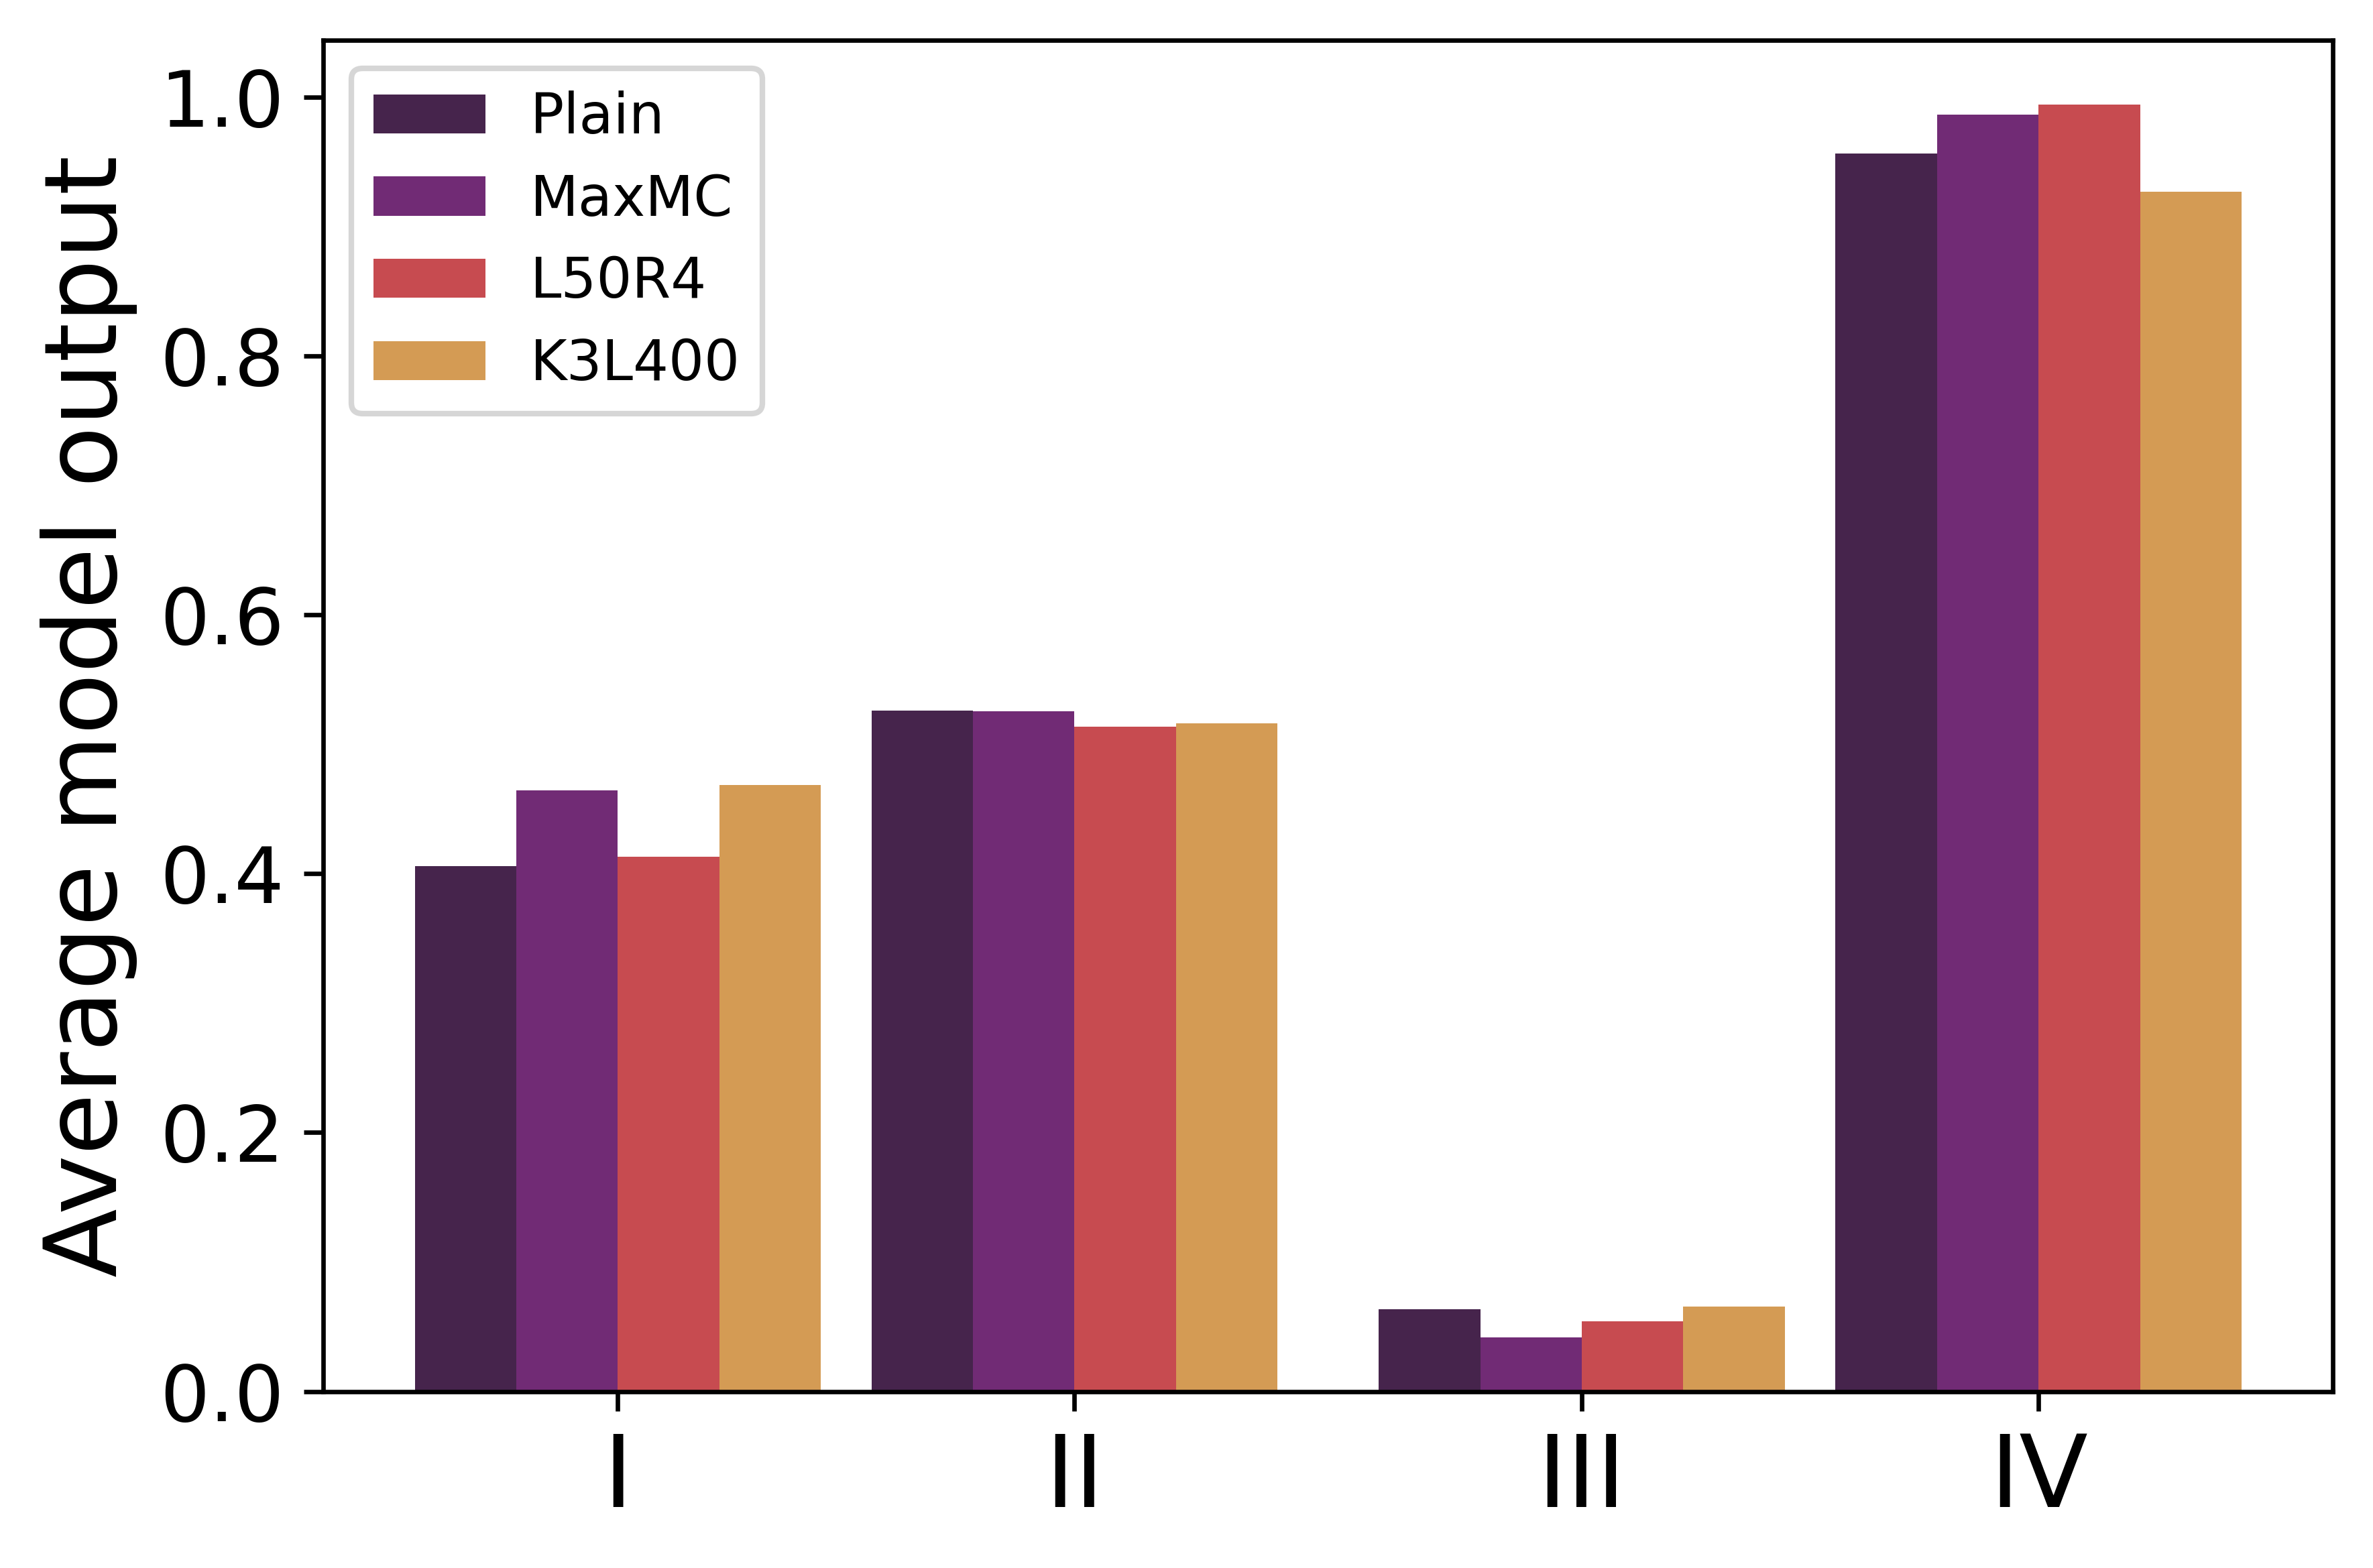

In [20]:
%matplotlib inline
fig = plt.figure(figsize=(6,4), dpi=300)
ax = fig.add_subplot(111)

color_list = ['#46244C', '#712B75', '#C74B50', '#D49B54']

width = 0.1
length = 16

if length%2: 
    start = -(length//2)*width
else: 
    start = -((length//2)-0.5)*width
    
offset = [start + i * width for i in range(length)]

for i in range(4, length):
    offset[i] += width/2
    
for i in range(8, length):
    offset[i] += width
    
for i in range(12, length):
    offset[i] += width/2
    
offset = np.array(offset).reshape(4, 4).T
    
order_dict = ['Plain', 'MaxMC', 'L50R4', 'K3L400']

for i, key in enumerate(order_dict):
    ax.bar(offset[i], zoom_data[i], width, label=key, color = color_list[i], )
    
ax.legend(loc='upper left', ncol=1, fontsize=10)
ax.set_ylabel('Average model output', fontsize=18)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=14)

ax.set_xticks([-width * 6, -width * 1.5, width * 3.5, width * 8])
ax.set_xticklabels(['I', 'II', 'III', 'IV'], fontsize=18)

plt.tight_layout()
plt.savefig('Fig6a_1.svg', transparent=True, dpi=300)

In [ ]:
fig = plt.figure(figsize=(2,2), dpi=300)
ax = fig.add_subplot(111)

for i, key in enumerate(order_dict):
    ax.bar([i], zoom_data[i, -1], 1, label=key, color = color_list[i])

color_list = ['#46244C', '#712B75', '#C74B50', '#D49B54']
ax.set_ylim(0.9, 1.0)
ax.set_yticks([0.9, 1.0])
ax.set_yticklabels(['0.9', '1.0'], fontsize=14)
ax.set_xticks([])
plt.tight_layout()

In [ ]:
# small version

fig = plt.figure(figsize=(4, 2), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(pi_list_list[2][:100], aspect='auto', vmin=0, vmax=1.0, cmap='viridis', origin='lower')
#im = ax.imshow(pi_list, aspect='auto', vmin=0, vmax=1, cmap='plasma')

ax.set_xticks([])
ax.set_yticks([0, 50, 100])
ax.set_ylim(0, 100)
#plt.axis('off')
ax.hlines(50, -0.5, 14.5, lw=3, ls='--', color='w')

ax.vlines(3.5, 0, 100, lw=3, ls='--', color='w')
ax.vlines(6.5, 0, 100, lw=3, ls='--', color='w')
ax.tick_params(axis = 'both', labelsize=20)
plt.tight_layout()
#plt.savefig('Fig4c_2.svg', transparent=True, dpi=300)

In [ ]:
with open('./result/inspection_dict/inspection_dict_basic_E550_L50R4.pkl', 'rb') as f:
    inspection_complete_dict = pickle.load(f)
complete_dict = {}
complete_sem_dict = {}
Ret_list = []
FinalScore_list = []

for i in range(len(inspection_complete_dict['scr_buf_list'])):
    Ret_list.append(inspection_complete_dict['scr_buf_list'][i])
    FinalScore_list.append(inspection_complete_dict['scr_buf_list'][i][:, :, -1])
    
Ret_list = np.array(Ret_list)
FinalScore_list = np.array(FinalScore_list)

complete_dict['RL'] = [np.mean(Ret_list), 
                       np.mean(FinalScore_list)]
complete_sem_dict['RL'] = [np.std(np.mean(Ret_list, axis=(-2, -1)))/np.sqrt(5000), 
                           np.std(np.mean(FinalScore_list, axis=-1))/np.sqrt(5000)]
complete_dict, complete_sem_dict

In [ ]:
basic basic : 83.01
maxmc basic : 81.4
L50 basic : 81.78
L400 basic : 82.7

maxmc maxmc : 78.60
basic maxmc : 77.73608
L50 maxmc : 80.56
L400 maxmc : 79.7

basic L50 : 65.31
maxmc L50 : 64.62
L50 L50 : 65.144
L400 L50 : 63.87
    
basic L400 : 95.3809
maxmc L400 : 95.3043
L50 L400 : 94.6618
L400 L400 : 95.80624

In [26]:
L50_data = np.array([[65.31], [64.62], [65.144], [63.877]])
L50_sem_data = np.array([0.0009821489591534552, 0.0009412244746164983, 0.0009540506035553335, 0.0010379409552368722]) * 5 * 100
L400_data = np.array([[95.3809], [95.3043], [94.6618], [95.80624]])
L400_sem_data = np.array([0.0007140659212986966, 0.0008333406596475564, 0.000869253146326719, 0.0006401335001477053]) * 5 * 100

In [ ]:
Ret_list_1 = []
Ret_list_2 = []
with open('./result/inspection_dict/inspection_dict_L400_E4300_L50R4.pkl', 'rb') as f:
    inspection_complete_dict = pickle.load(f)
    
for i in range(len(inspection_complete_dict['scr_buf_list'])):
    Ret_list_1.append(inspection_complete_dict['scr_buf_list'][i])

Ret_list_1 = np.array(Ret_list_1)

with open('./result/inspection_dict/inspection_dict_SIRF_TT_gene_ent_EC0.003_N15K7NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98_L50R4_E5200.pkl', 'rb') as f:
    inspection_complete_dict = pickle.load(f)
    
for i in range(len(inspection_complete_dict['scr_buf_list'])):
    Ret_list_2.append(inspection_complete_dict['scr_buf_list'][i])

Ret_list_2 = np.array(Ret_list_2)

scipy.stats.ttest_ind(Ret_list_1.flatten(), Ret_list_2.flatten())  # p vlaue less than 0.001 (near zero)

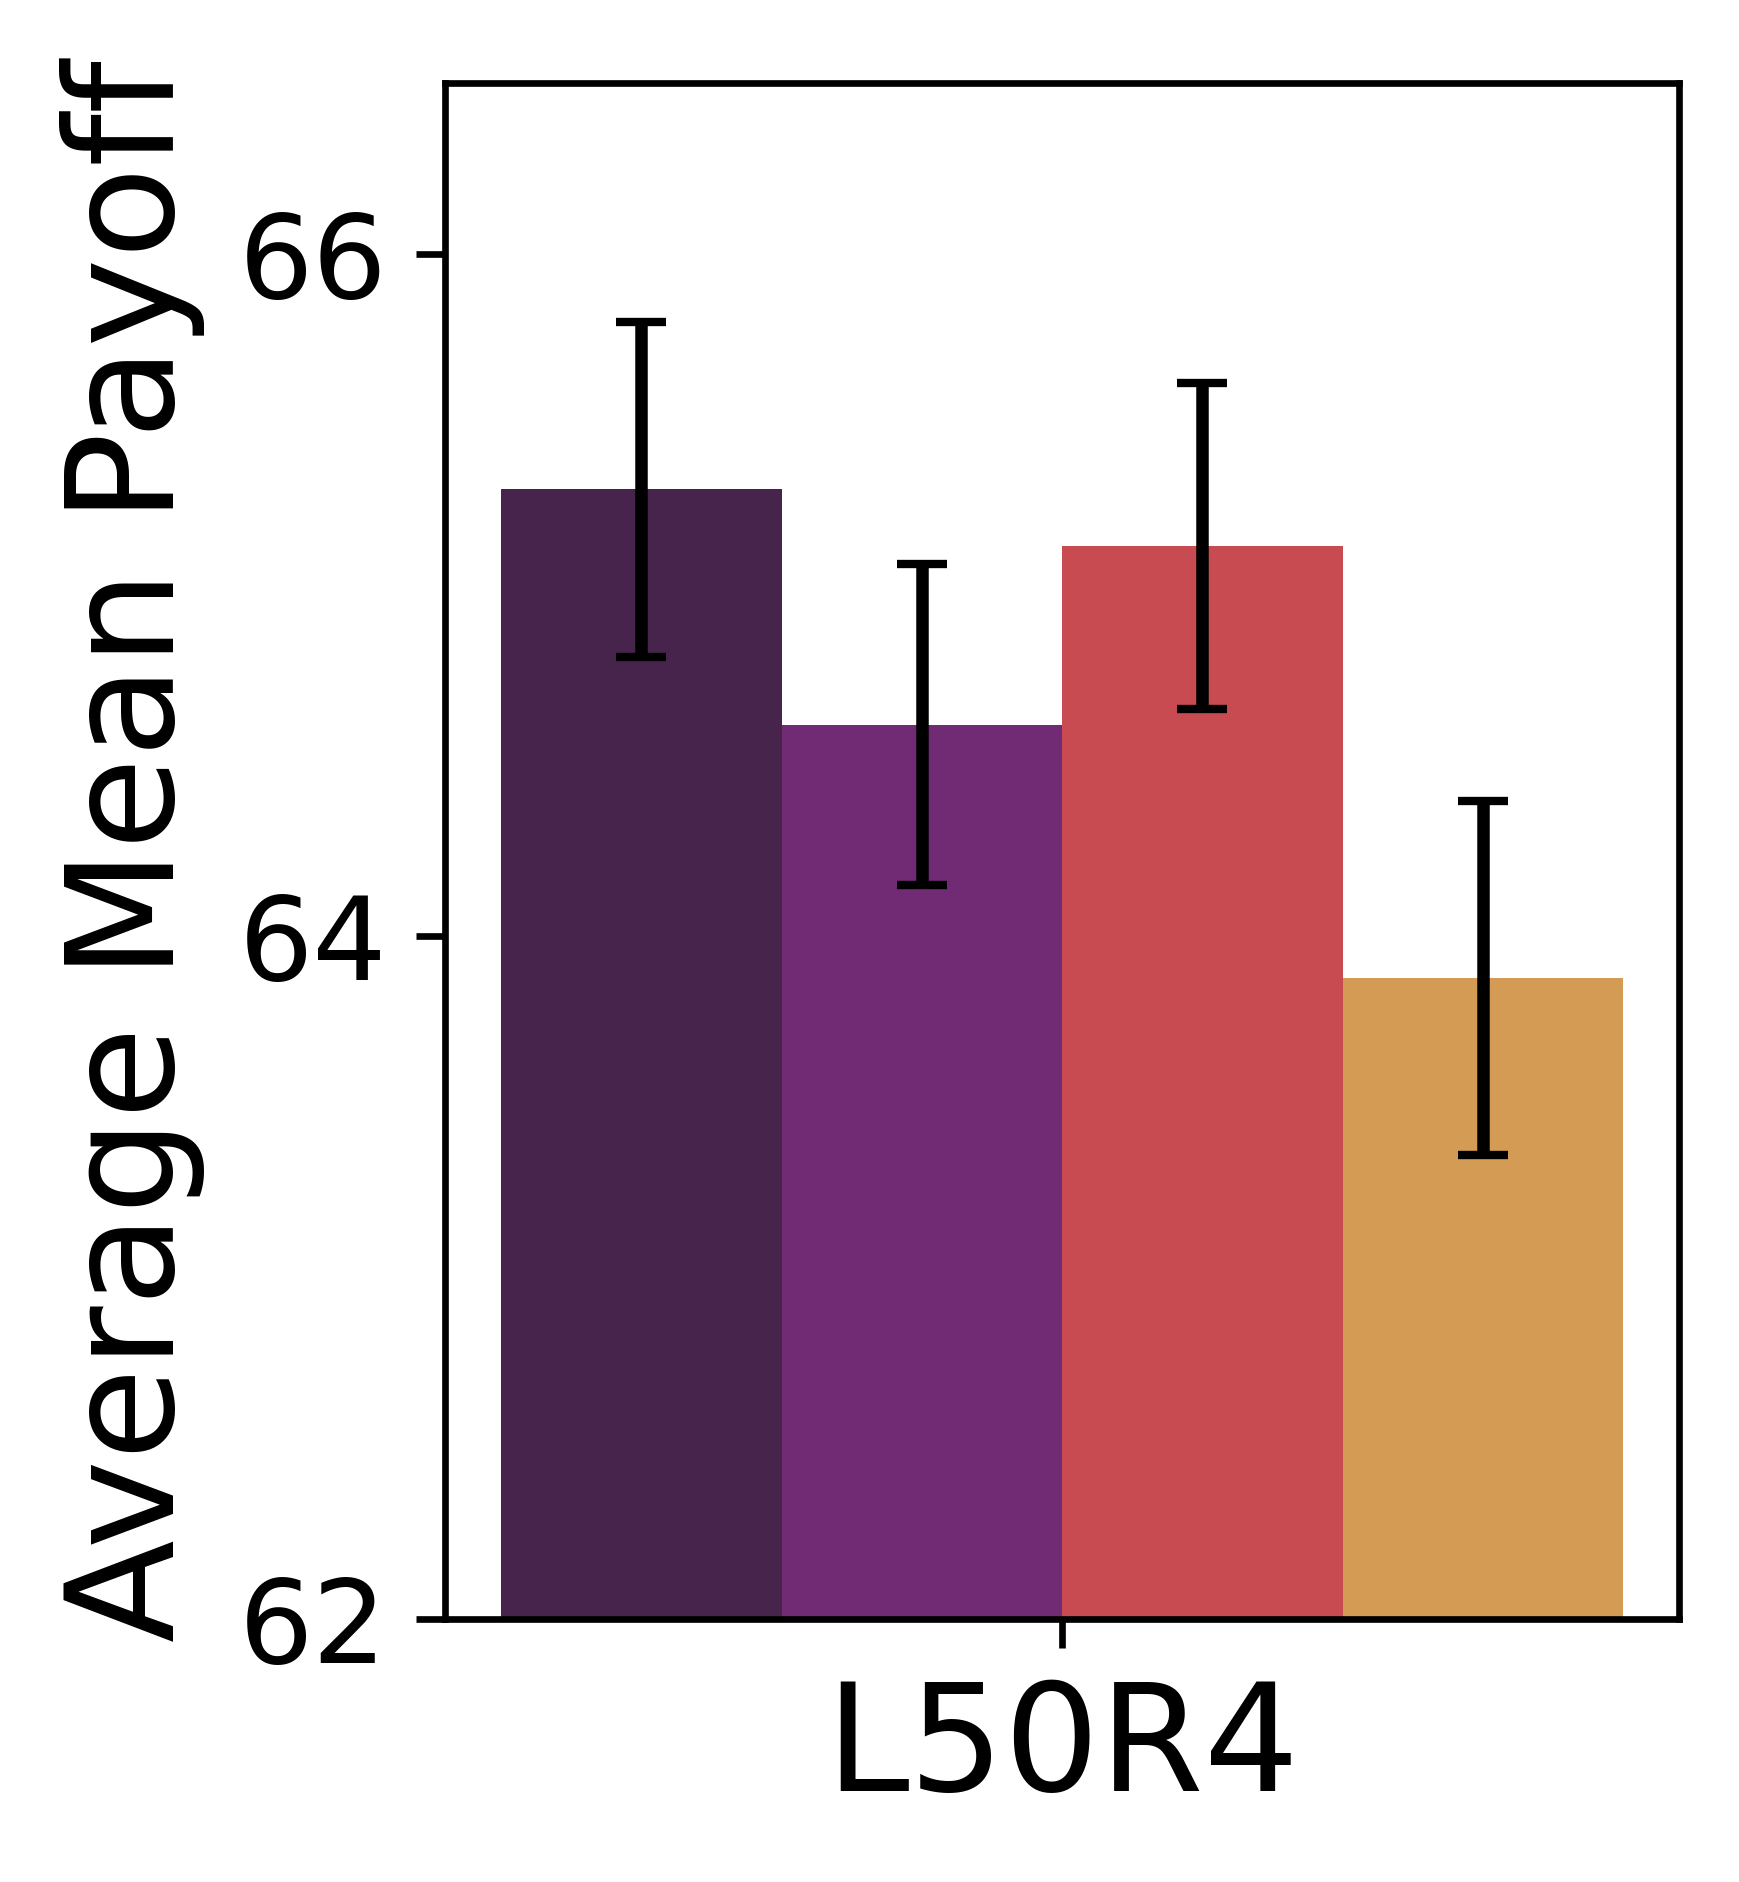

In [27]:
%matplotlib inline
fig = plt.figure(figsize=(3, 3.2), dpi=300)
ax = fig.add_subplot(111)

color_list = ['#46244C', '#712B75', '#C74B50', '#D49B54']

width = 0.1
length = 4

if length%2: 
    start = -(length//2)*width
else: 
    start = -((length//2)-0.5)*width
    
offset = [start + i * width for i in range(length)]

offset = np.array(offset).reshape(1, 4).T

for i, key in enumerate(order_dict):
    ax.bar(offset[i], L50_data[i], width, color = color_list[i], yerr = L50_sem_data[i], capsize=3.0)
    
ax.set_ylabel('Average Mean Payoff', fontsize=18)
ax.set_yticks([62, 64, 66])
ax.set_yticklabels(['62', '64', '66'], fontsize=14)
ax.set_ylim(62, 66.5)

ax.set_xticks([0])
ax.set_xticklabels(['L50R4'], fontsize=18)

plt.tight_layout()
plt.savefig('Fig6b.svg', transparent=True, dpi=300)

In [ ]:
Ret_list_1 = []
Ret_list_2 = []
with open('./result/inspection_dict/inspection_dict_L50R4_E5200_L400.pkl', 'rb') as f:
    inspection_complete_dict = pickle.load(f)
    
for i in range(len(inspection_complete_dict['scr_buf_list'])):
    Ret_list_1.append(inspection_complete_dict['scr_buf_list'][i])

Ret_list_1 = np.array(Ret_list_1)

with open('./result/inspection_dict/inspection_dict_SIRF_TT_gene_ent_EC0.003_N15K3NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98_L400_E4300.pkl', 'rb') as f:
    inspection_complete_dict = pickle.load(f)
    
for i in range(len(inspection_complete_dict['scr_buf_list'])):
    Ret_list_2.append(inspection_complete_dict['scr_buf_list'][i])

Ret_list_2 = np.array(Ret_list_2)

scipy.stats.ttest_ind(Ret_list_1.flatten(), Ret_list_2.flatten())

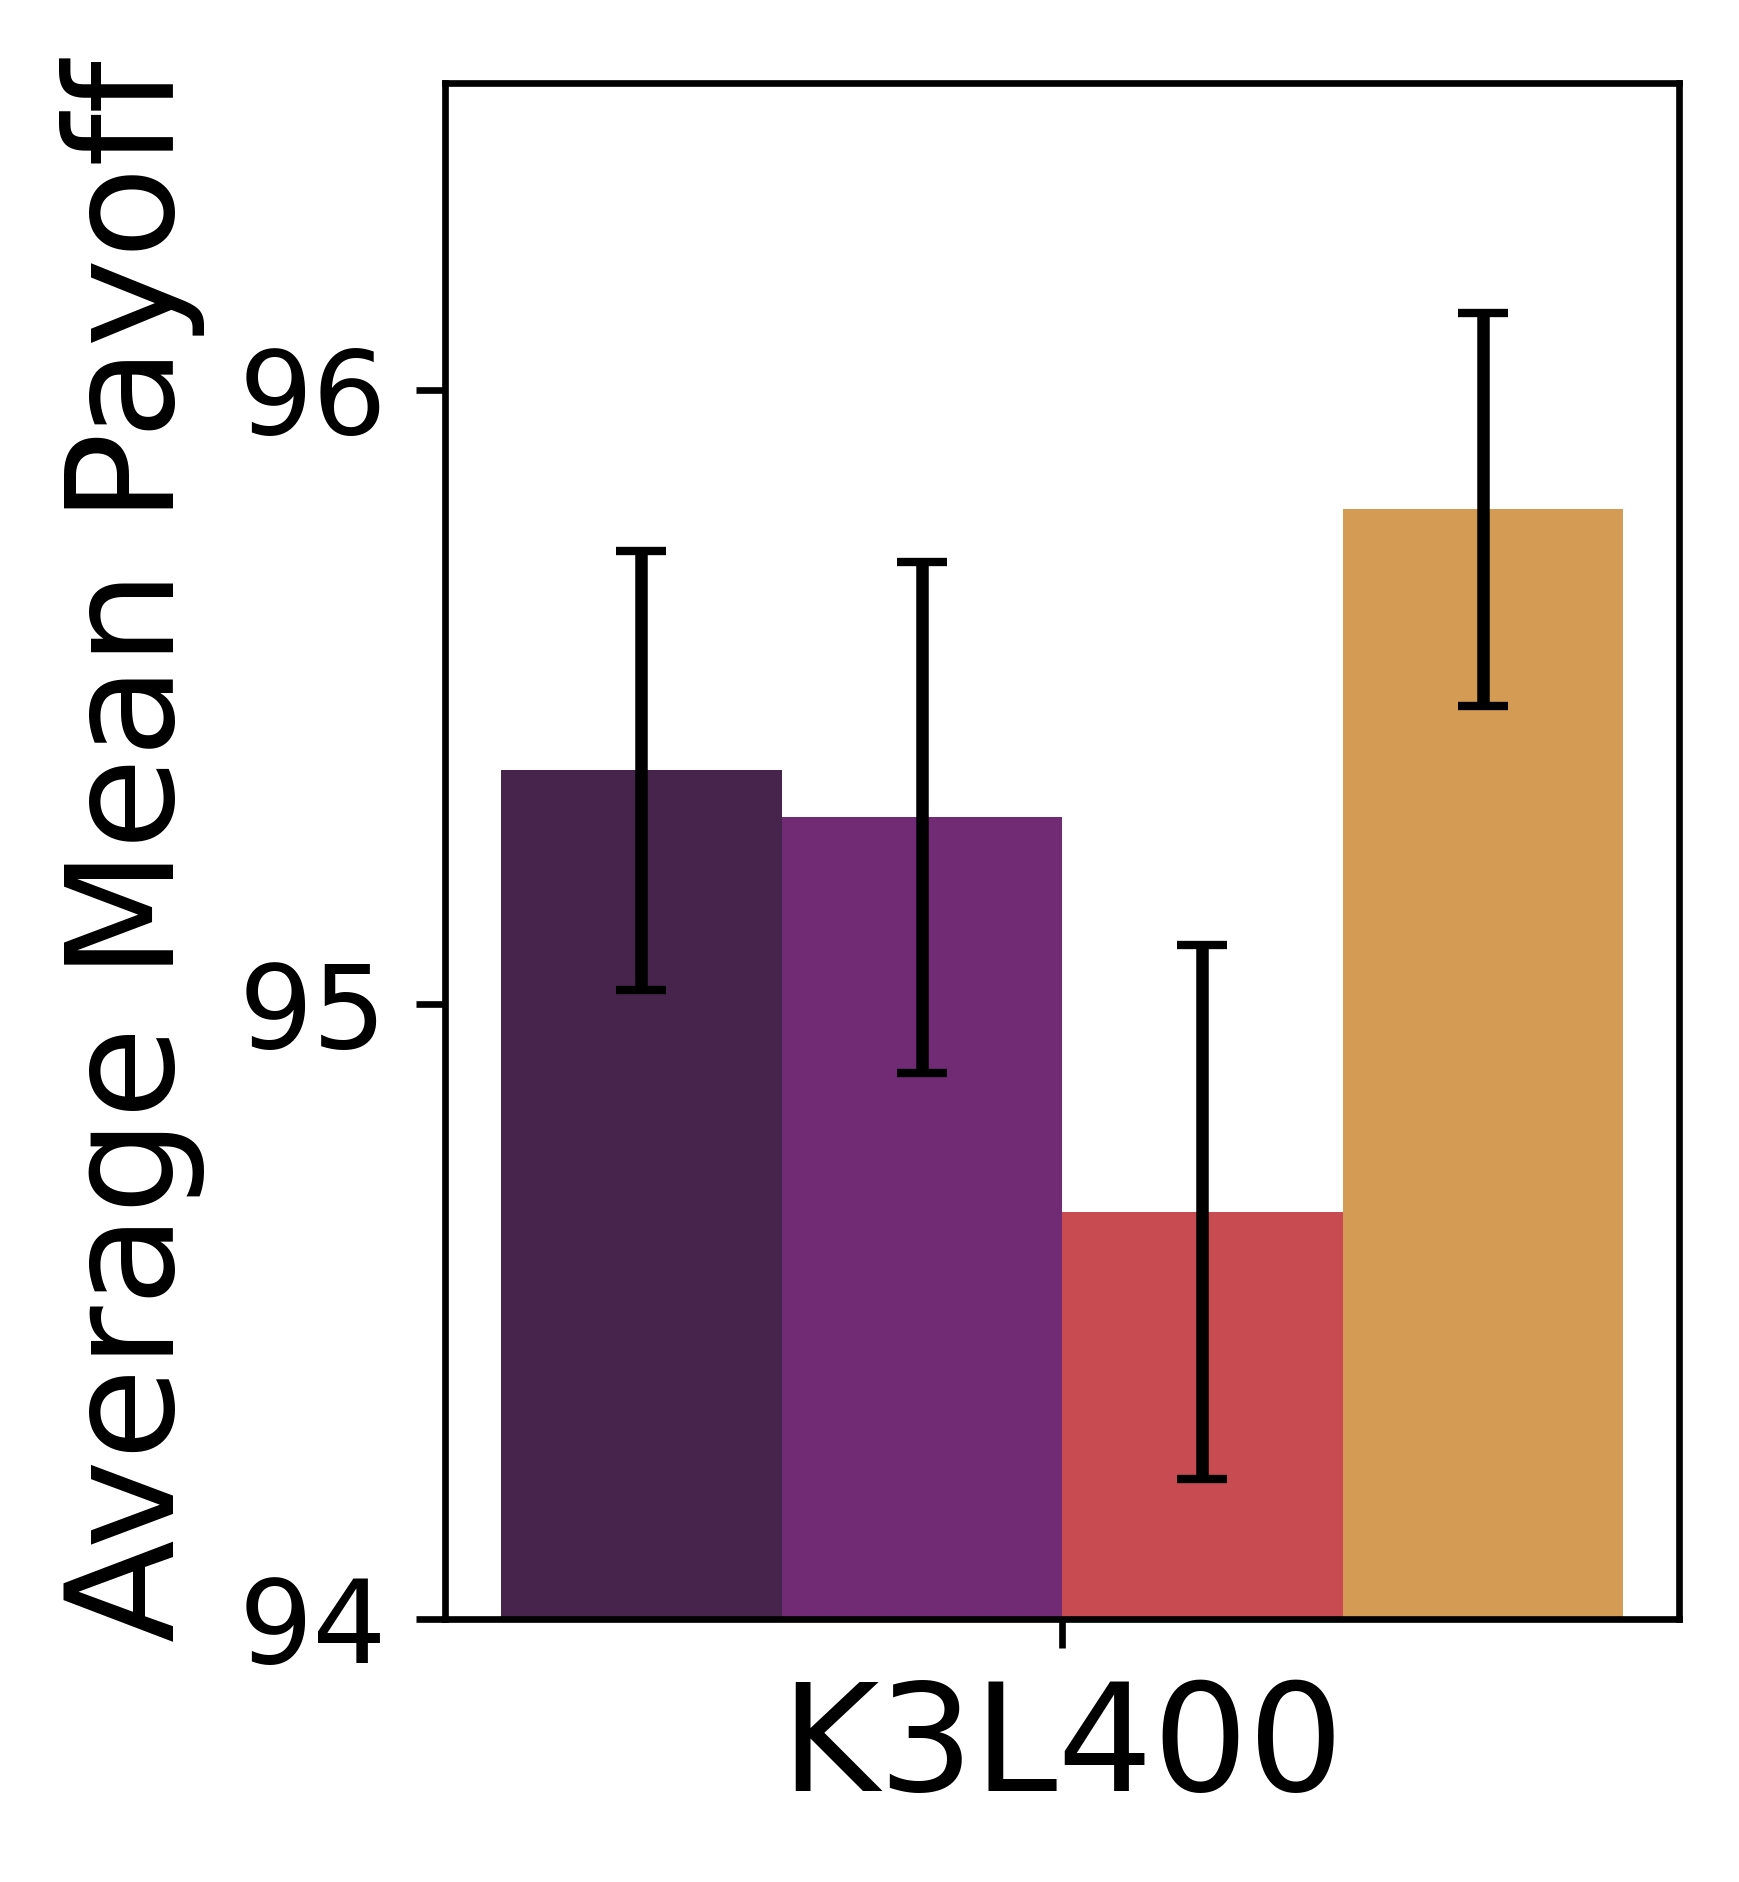

In [29]:
%matplotlib inline
fig = plt.figure(figsize=(3, 3.2), dpi=300)
ax = fig.add_subplot(111)

color_list = ['#46244C', '#712B75', '#C74B50', '#D49B54']

width = 0.1
length = 4

if length%2: 
    start = -(length//2)*width
else: 
    start = -((length//2)-0.5)*width
    
offset = [start + i * width for i in range(length)]

offset = np.array(offset).reshape(1, 4).T

for i, key in enumerate(order_dict):
    ax.bar(offset[i], L400_data[i], width, color = color_list[i], yerr = L400_sem_data[i], capsize=3.0)
    
ax.set_ylabel('Average Mean Payoff', fontsize=18)
ax.set_yticks([94, 95, 96])
ax.set_yticklabels(['94', '95', '96'], fontsize=14)
ax.set_ylim(94, 96.5)

ax.set_xticks([0])
ax.set_xticklabels(['K3L400'], fontsize=18)

plt.tight_layout()
plt.savefig('Fig6c.svg', transparent=True, dpi=300)

# Figure S1

50
tensor(0.0407, device='cuda:0')


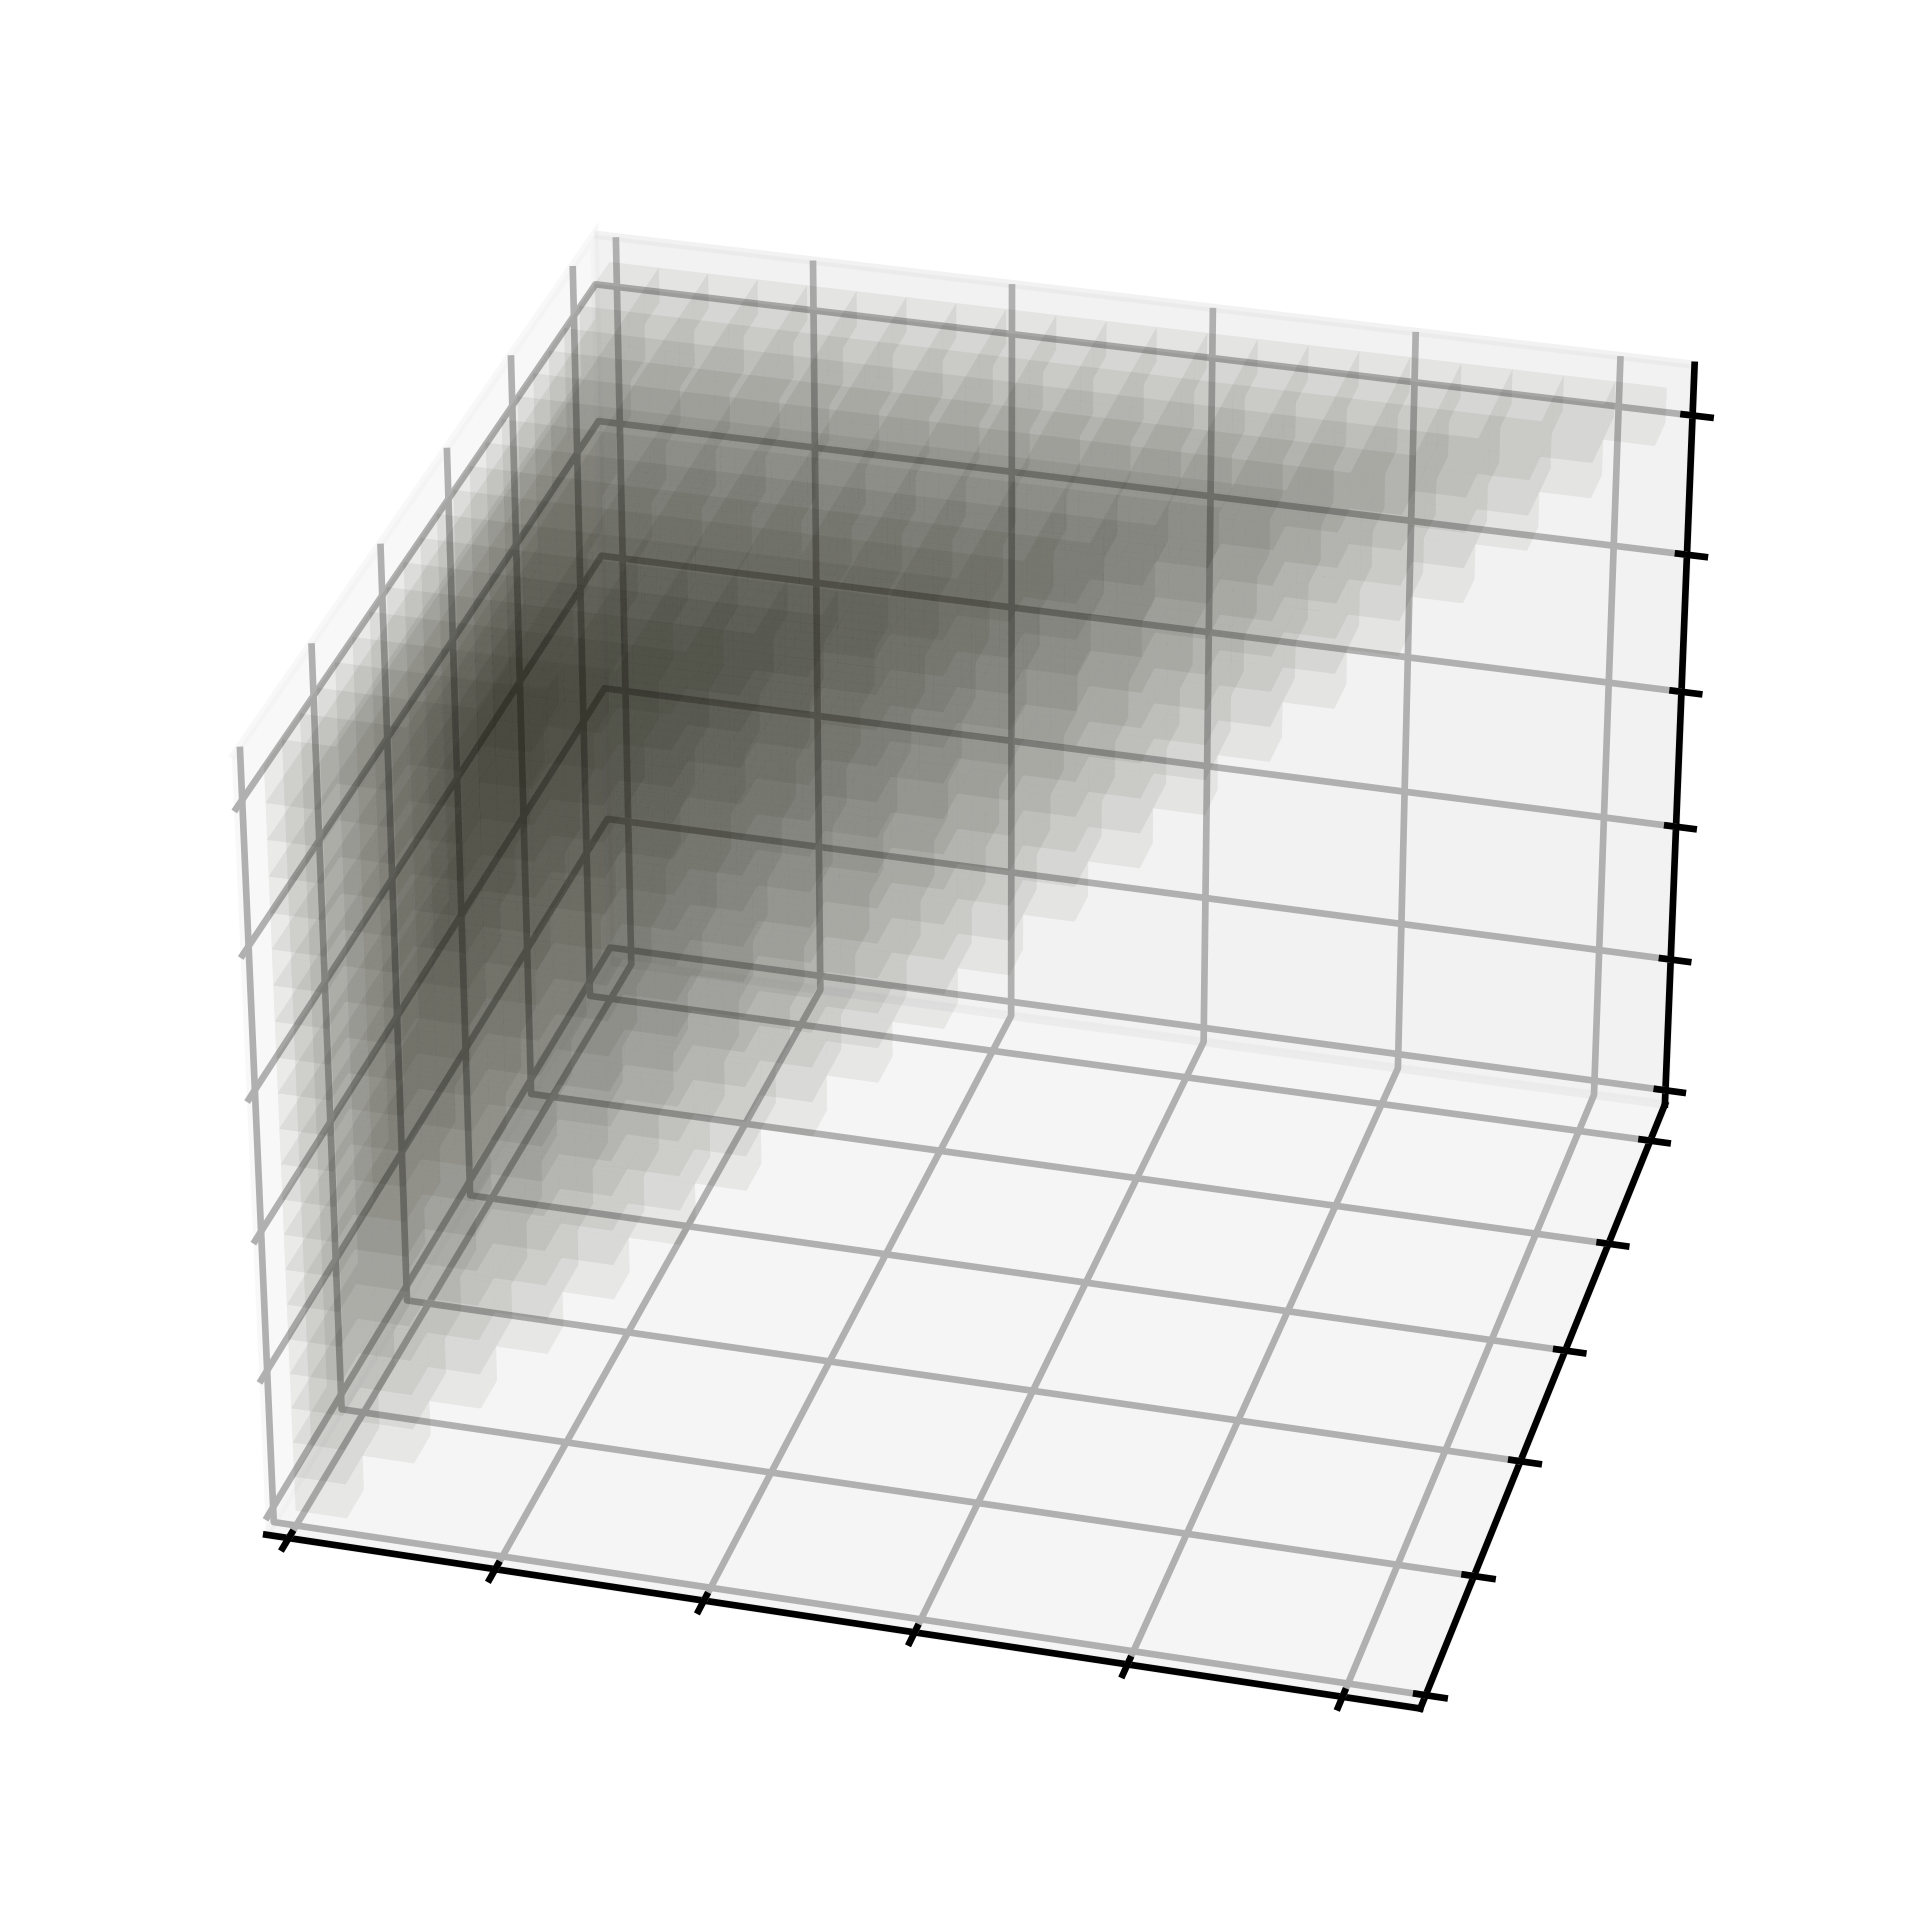

In [97]:
# self score, SIRF
max_s = 100
s_list = [50]
%matplotlib inline

graph_type = 'complete'
#exp_name = 'SIRF_TT_gene_ent_EC0.003_N15K7NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98'
exp_name = 'test_test'
epoch = 600
label = ''
rescale = False
extra_type = 'SIRF'
offset = 4
ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs = load_model(exp_name, epoch)
neighbor_num = env_kwargs['neighbor_num']

template = template_a1
template = np.c_[template, np.array([[-1, 0], [-1, 1 / neighbor_num], [-1, 1 / neighbor_num], [-1, 1 / neighbor_num]])]

for s in s_list:
    print(s)
    tc = coord_triplet(max_s+1)
    data = np.repeat(template.reshape(1, 4, 19), len(tc), axis=0).astype(np.float)
    tc = np.c_[np.ones(tc.shape[0])*s, tc]
    if rescale:
        data[:, :, -offset] = tc
    else:
        data[:, :, -offset] = tc / 100.
        
    score_rank = rankdata(tc, axis=-1, method='min') / (neighbor_num + 1)
    data[:, :, -2] = score_rank
    pi_list = []
    ent = 0
    for i in range((data.shape[0]//10000)+1):
        a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
        x = pi.probs[..., 1].detach().cpu().numpy()
        ent += pi.entropy().sum()
        pi_list.append(x)
        #print(x, pi.entropy().sum())
    pi_list = np.concatenate(pi_list, axis=0)
    ent /= data.shape[0] * 15
    print(ent)
    sp = template[0][:-offset]
    cp = template[-2][:-offset]
    hp = template[-1][:-offset]
    facecolors, sp_dist, cp_dist, hp_dist = assign_facecolors(pi_list, sp, cp, hp, True, True, True, max_s+1)

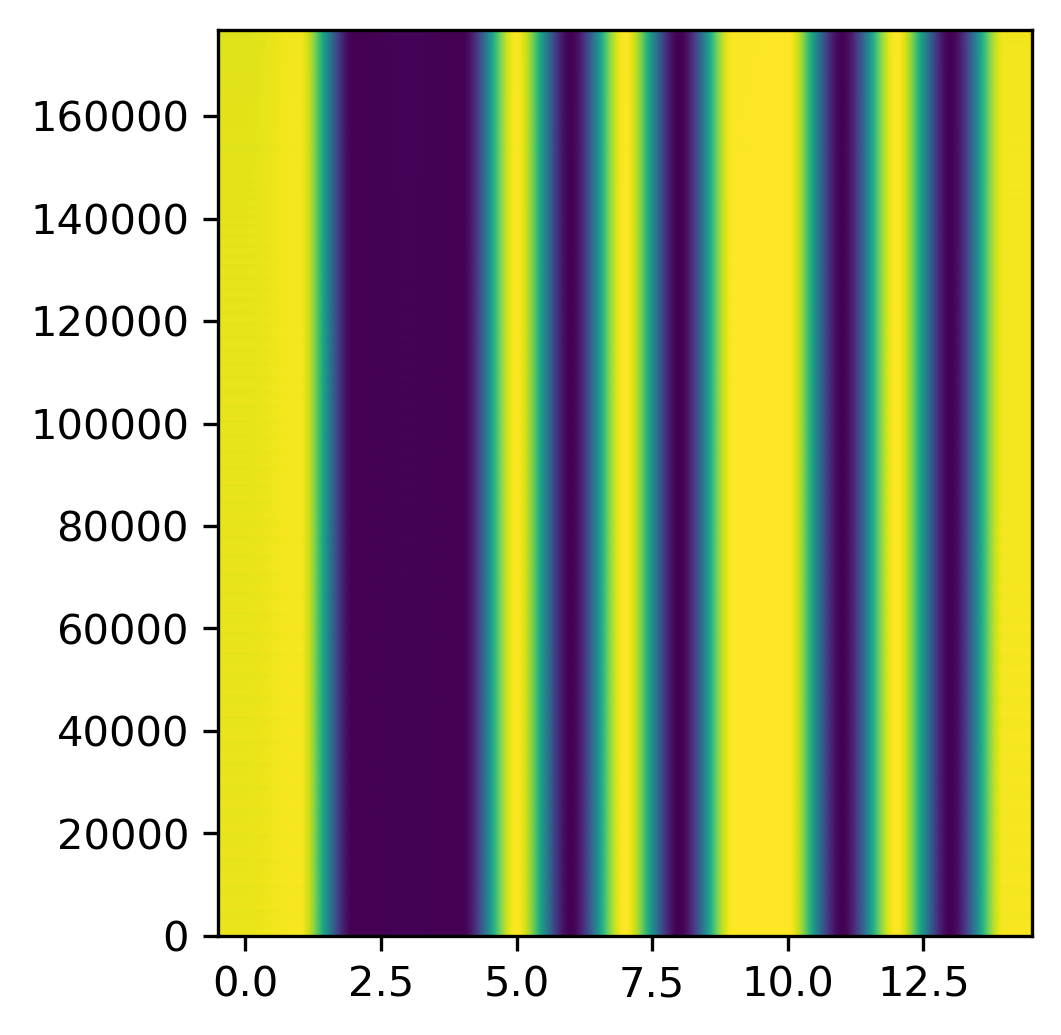

In [98]:
fig = plt.figure(figsize=(3.5, 4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(pi_list, aspect='auto', cmap='viridis', origin='lower')

ax.set_xticks([])

ax.set_xticks([1, 5, 9, 13])
ax.set_xticklabels(['Self', 'Best', 'Second', 'Third'], fontsize=14)

ax.set_yticks([])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('FigS1b1.svg', transparent=True, dpi=300)

# Figure S2

# Figure S3

# Figure S4

In [85]:
data_1 = pd.read_csv('./result/progress/progress_SI.txt', sep = "\t")
y1_1 = ema(data_1['AvgRet'].values, 0.99) * 100
y2_1 = ema(data_1['Entropy'].values, 0.99)
data_2 = pd.read_csv('./result/progress/progress_default.txt', sep = "\t")
y1_2 = ema(data_2['AvgRet'].values, 0.99) * 100
y2_2 = ema(data_2['Entropy'].values, 0.99)

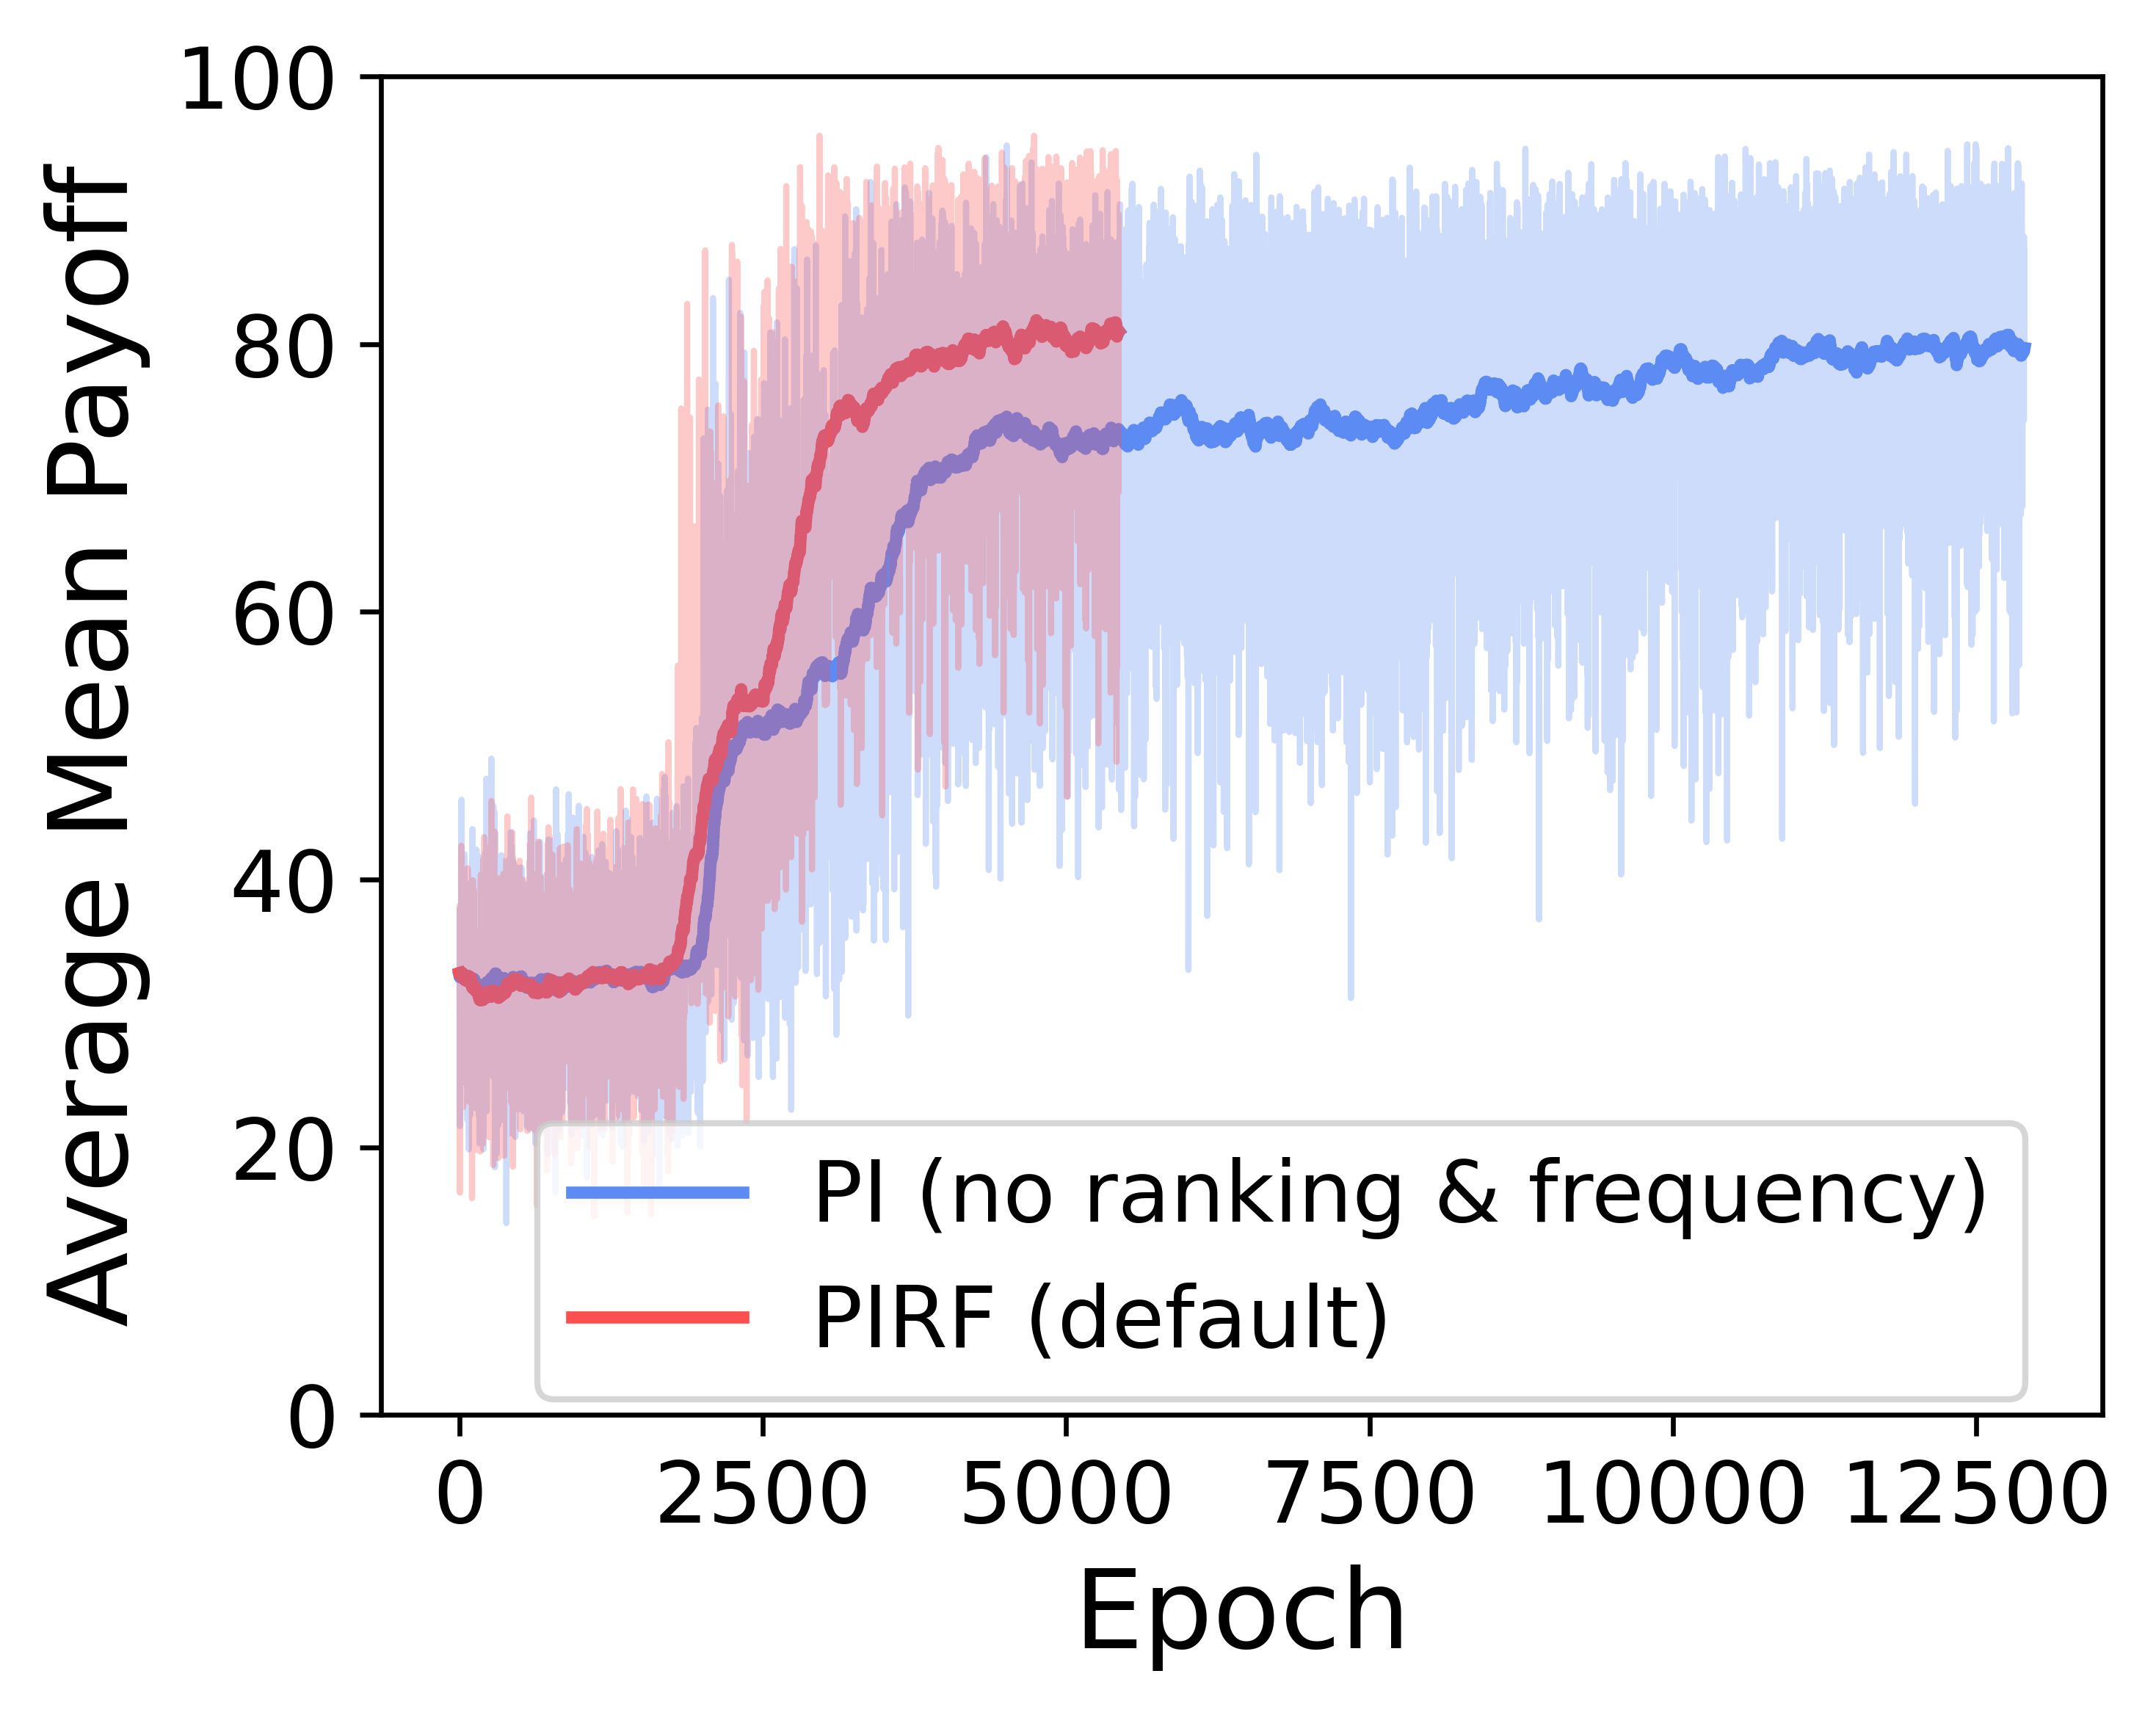

In [95]:
fig = plt.figure(figsize=(5, 4), dpi=300)
ax1 = fig.add_subplot(111)
ax1.plot(y1_1, lw=2, c='#5D8BF4', label='PI (no ranking & frequency)')
ax1.plot(y1_2, lw=2, c='#FC4F4F', label='PIRF (default)')
ax1.plot(data_1['AvgRet'].values*100, lw=1, alpha=0.3, c='#5D8BF4')
ax1.plot(data_2['AvgRet'].values*100, lw=1, alpha=0.3, c='#FC4F4F')

ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('Average Mean Payoff', fontsize=18)
ax1.set_ylim(0, 100)
ax1.tick_params(axis = 'both', labelsize=14)

fig.legend(loc="upper right", bbox_to_anchor=(0.98, 0.25), bbox_transform=ax1.transAxes, fontsize=14)
plt.tight_layout()
plt.savefig('FigS4a.svg', transparent=True, dpi=300)

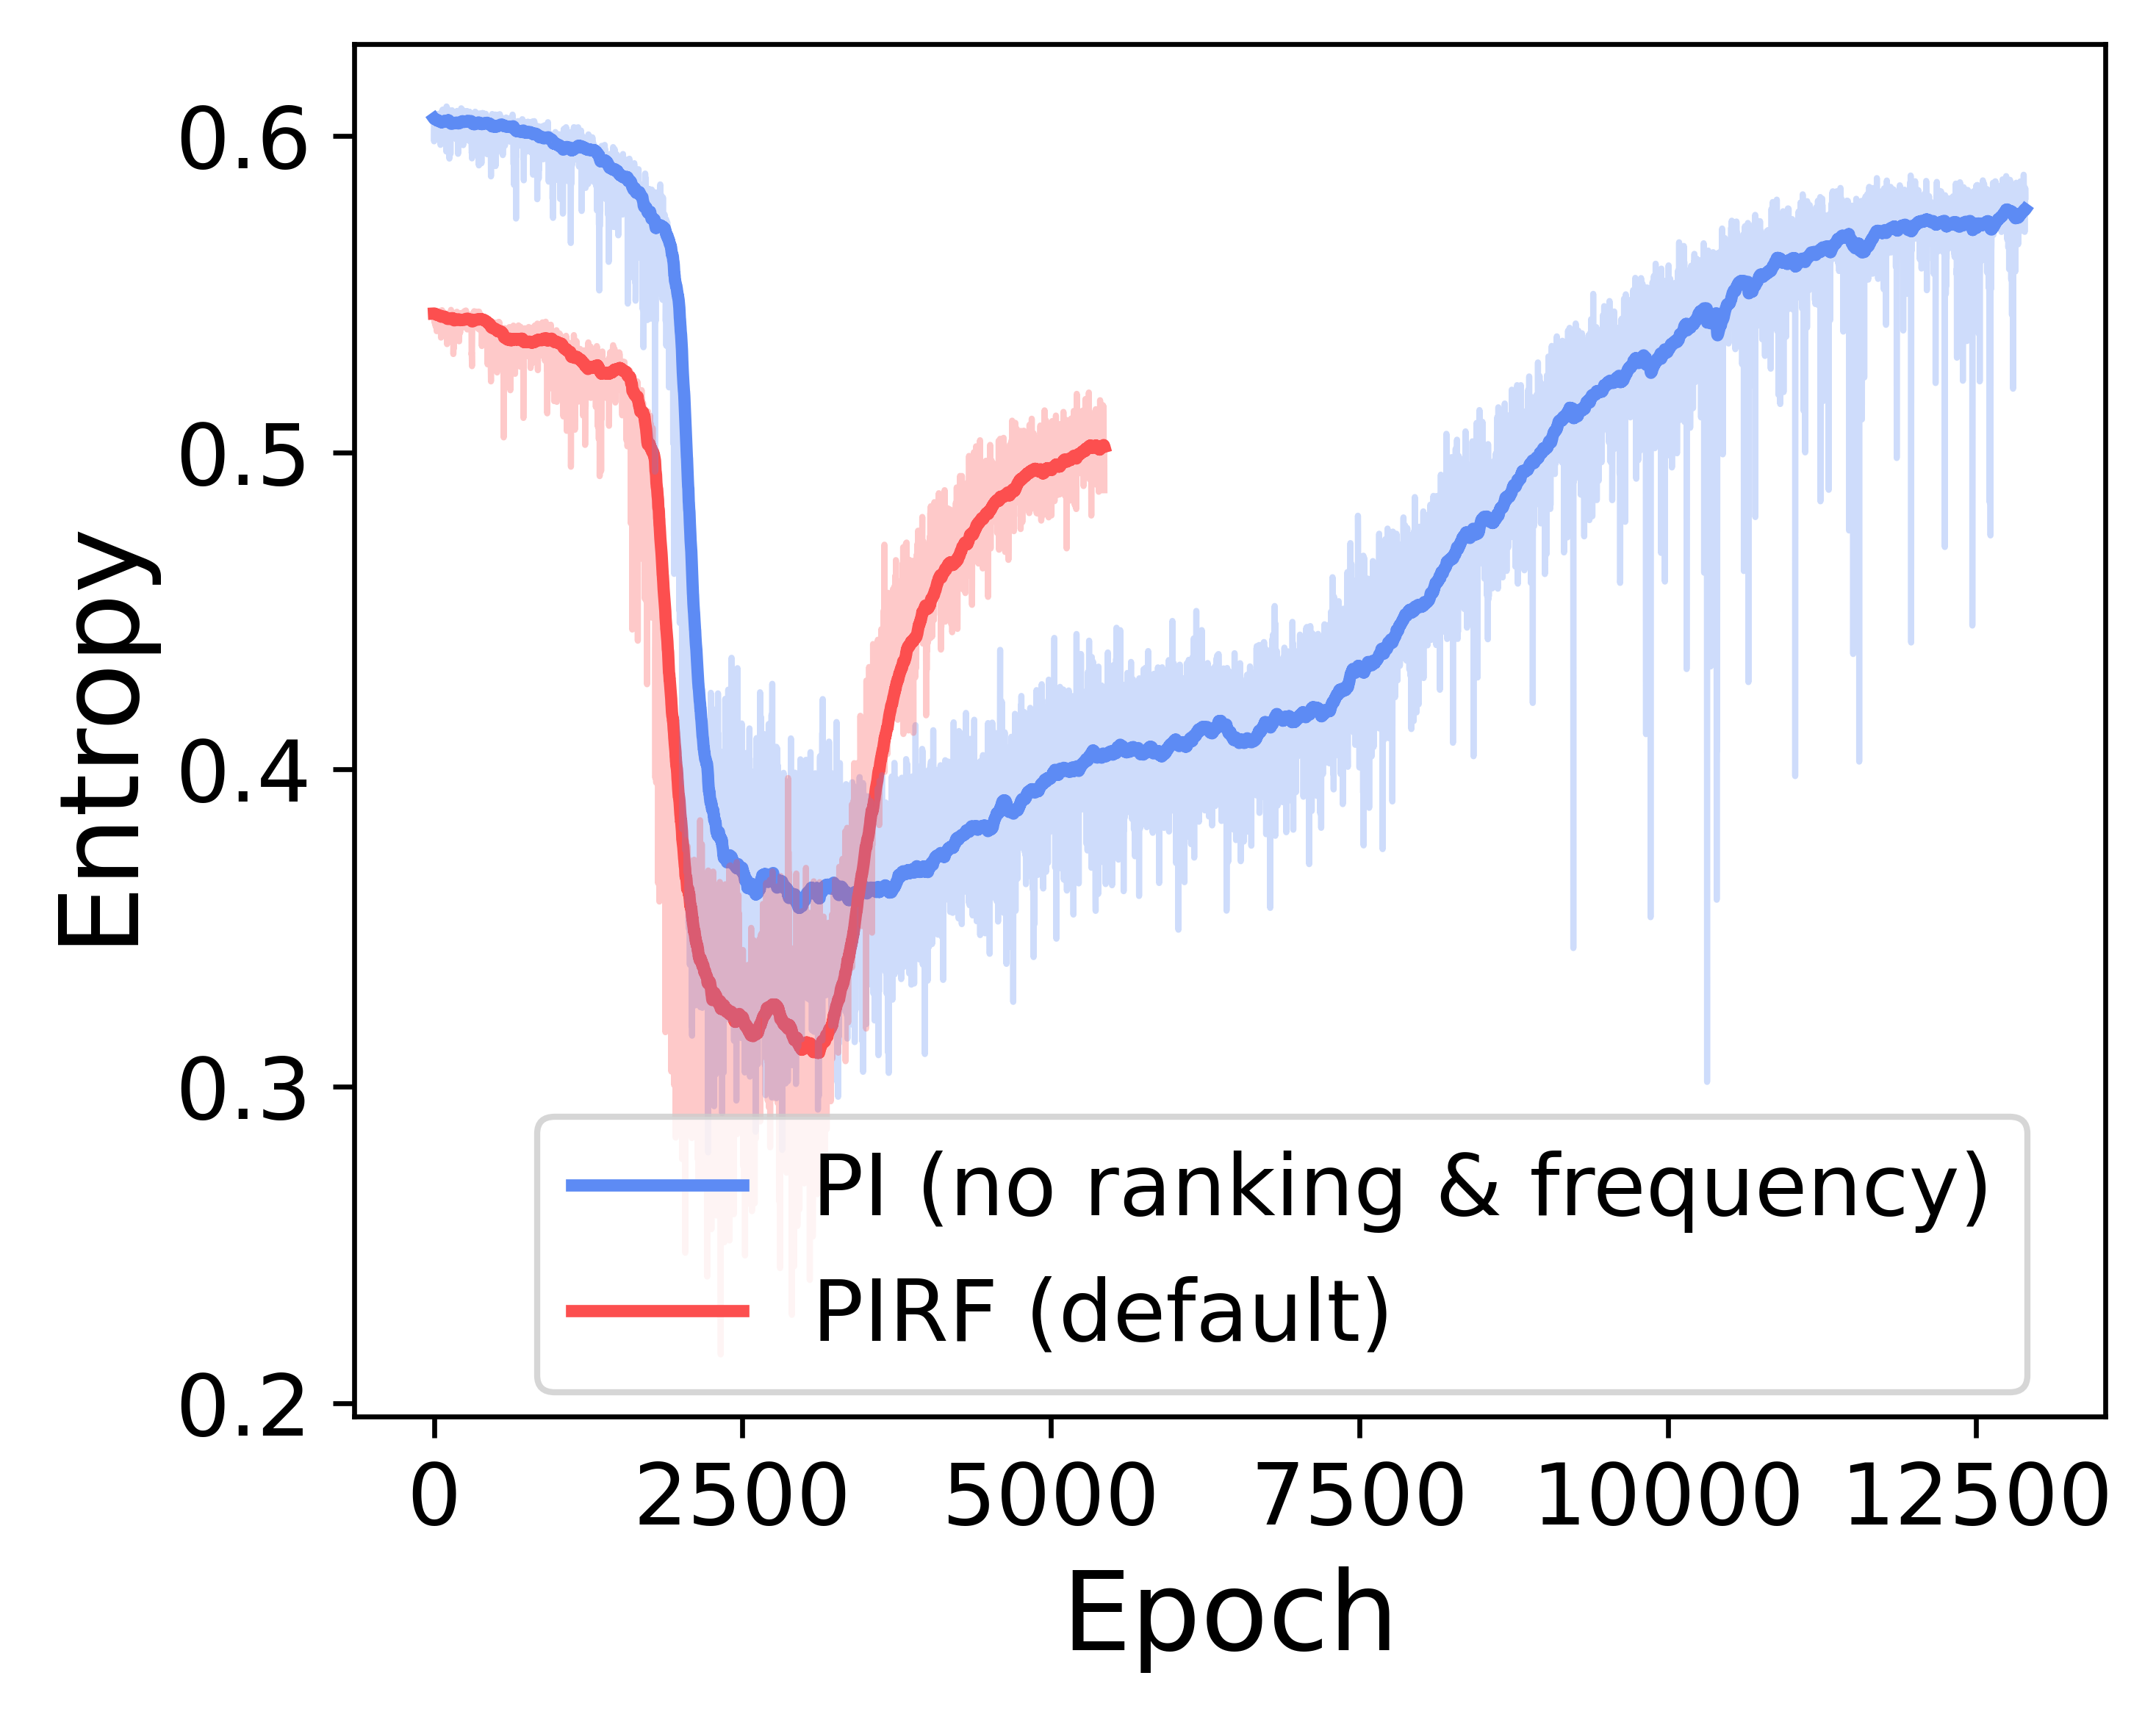

In [96]:
fig = plt.figure(figsize=(5, 4), dpi=300)
ax1 = fig.add_subplot(111)
ax1.plot(y2_1, lw=2, c='#5D8BF4', label='PI (no ranking & frequency)')
ax1.plot(y2_2, lw=2, c='#FC4F4F', label='PIRF (default)')
ax1.plot(data_1['Entropy'].values, lw=1, alpha=0.3, c='#5D8BF4')
ax1.plot(data_2['Entropy'].values, lw=1, alpha=0.3, c='#FC4F4F')

ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('Entropy', fontsize=18)
#ax1.set_ylim(0, 100)
ax1.tick_params(axis = 'both', labelsize=14)

fig.legend(loc="upper right", bbox_to_anchor=(0.98, 0.25), bbox_transform=ax1.transAxes, fontsize=14)
plt.tight_layout()
plt.savefig('FigS4b.svg', transparent=True, dpi=300)

# Figure S5

In [ ]:
data = pd.read_csv('./result/progress/progress_default.txt', sep = "\t")
y1 = ema(data['AvgRet'].values, 0.99) * 100
y1_max = ema(data['MaxRet'].values, 0.999)
y1_min = ema(data['MinRet'].values, 0.999)
y2 = ema(data['Entropy'].values, 0.99)
fig = plt.figure(figsize=(5, 4), dpi=300)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx() 
ax1.plot(y1, lw=2, c='#FC4F4F', label='Payoff')
#ax1.plot(y1_max, lw=2, ls=(0, (5, 5)), c='#FC4F4F', alpha=0.5)
#ax1.plot(y1_min, lw=2, ls=(0, (5, 5)), c='#FC4F4F', alpha=0.5)
ax1.plot(data['AvgRet'].values*100, lw=1, alpha=0.3, c='#FC4F4F')
ax2.plot(y2, lw=2, c='#5D8BF4', label='Entropy')
ax2.plot(data['Entropy'].values, lw=1, alpha=0.3, c='#5D8BF4')

ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('Average Mean Payoff', fontsize=18)
ax1.set_ylim(0, 100)
ax2.set_ylabel('Entropy', fontsize=18)

ax1.tick_params(axis = 'both', labelsize=14)
ax2.tick_params(axis = 'both', labelsize=14)

fig.legend(loc="upper right", bbox_to_anchor=(0.98, 0.25), bbox_transform=ax1.transAxes, fontsize=14)
plt.tight_layout()
plt.savefig('Fig3a.svg', transparent=True, dpi=300)

# Figure S6

In [7]:
with open('./result/OLP_updated.pickle', 'rb') as f:
    real_network = pickle.load(f)

candidate = {}
max_node_threshold = 1200

for network_index in (real_network.network_index):
    graph = nx.Graph()
    graph.add_edges_from([tuple(x) for x in real_network[real_network['network_index']==network_index]['edges_id'].values[0]]) # add weights to the edges
    graph2 = nx.k_core(graph, k=3)
    if graph2.number_of_nodes() > 0:
        if nx.is_connected(graph2) and graph2.number_of_nodes()/graph.number_of_nodes() > 0.95:
            candidate[network_index] = graph2.number_of_nodes()

network_data = real_network[np.isin(real_network['network_index'], list(candidate.keys()))]
network_filter = np.logical_and(network_data['networkDomain'] == 'Social', network_data['number_nodes'].values < max_node_threshold )
network_data = network_data[network_filter]
network_index = network_data.network_index.values
network_nodes = [candidate[i] for i in network_index]


In [8]:
network_diameter = []
for i in network_index:
    print(i)
    graph = nx.Graph()
    graph.add_edges_from([tuple(x) for x in real_network[real_network['network_index']==i]['edges_id'].values[0]]) # add weights to the edges
    graph2 = nx.k_core(graph, k=3)
    network_diameter.append(nx.algorithms.distance_measures.diameter(graph2))

80.0
81.0
116.0
142.0
143.0
144.0
145.0
146.0
147.0
148.0
149.0
150.0
151.0
152.0
153.0
154.0
155.0
156.0
157.0
158.0
159.0
160.0
161.0
162.0
163.0
164.0
165.0
166.0
167.0
168.0
169.0
170.0
171.0
172.0
173.0
174.0
175.0
176.0
177.0
178.0
179.0
180.0
181.0
182.0
183.0
184.0
185.0
186.0
187.0
188.0
189.0
190.0
191.0
192.0
193.0
194.0
195.0
196.0
197.0
198.0
199.0
200.0
201.0
202.0
203.0
204.0
205.0
206.0
207.0
208.0
209.0
210.0
226.0
227.0
228.0
229.0
230.0
231.0
232.0
233.0
234.0
235.0
236.0
237.0
238.0
239.0
241.0
242.0


In [ ]:
# dict merger
for i in range(51):
    with open(f'./result/real_network_{i}_base.pkl', 'rb') as f:
        data1 = pickle.load(f)
    with open(f'./result/real_network_{i}_base2.pkl', 'rb') as f:
        data2 = pickle.load(f)

    data1.pop('50SF', None)
    data1.pop('50SF80', None)
    with open(f'./result/real_network_{i}.pkl', 'wb') as f:
        pickle.dump({**data1, **data2}, f, pickle.HIGHEST_PROTOCOL)

In [12]:
import os

for i in range(39, 51):
    os.rename(f'./result/real_network_{i}-DESKTOP-ML3251C.pkl', f'./result/real_network_{i}.pkl')

In [17]:
data.keys()

dict_keys(['keys', 'FollowBest', 'FollowBest_indv', 'FollowMajor', 'FollowMajor_indv', 'IndvLearning', 'RandomCopy', 'FollowBest_random', 'FollowBest_prob', 'FollowMajor_random', 'FollowMajor_prob', 'IndvRandom', 'IndvProb'])

In [15]:
cutoff = 53
baseline_names = ['BI', 'BI-I', 'BI-P', 'BI-R', 'CF', 'CF-I', 'CF-P', 'CF-R',  'PI-I', 'PI-P', 'PI-R', 'RI']

avg_pf_dict = {names:np.zeros(200) for names in baseline_names}
avg_pf_dict['RL'] = np.zeros(200)
mean_dict = {}
sem_dict = {}

for ci in range(cutoff):
    if ci != 38:
        print(ci)
        mean_dict[ci] = {}
        sem_dict[ci] = {}
        with open(f'./result/real_network_{ci}.pkl', 'rb') as f:
            data = pickle.load(f)
            data_RL = data['RL']
        for baseline_name in baseline_names:
            x = data[conversion_dict2[baseline_name]]['scr_buf']
            avg_pf_dict[baseline_name] += np.mean(x, axis=tuple(range(0, len(x.shape) - 1)))
            mean_dict[ci][baseline_name] = [np.mean(x), np.mean(x[..., -1])]
            sem_dict[ci][baseline_name] = [np.std(x, axis=(-2, -1))/np.sqrt(100), np.std(x[..., -1], axis=-1)/np.sqrt(100)]

        x = np.array([data_RL['scr_buf_list'][i] for i in range(len(data_RL['scr_buf_list']))])
        avg_pf_dict['RL'] += np.mean(x, axis=tuple(range(0, len(x.shape) - 1)))

        Ret_list = []
        FinalScore_list = []

        for i in range(len(inspection_complete_dict['scr_buf_list'])):
            Ret_list.append(inspection_complete_dict['scr_buf_list'][i])
            FinalScore_list.append(inspection_complete_dict['scr_buf_list'][i][:, :, -1])

        Ret_list = np.array(Ret_list)
        FinalScore_list = np.array(FinalScore_list)

        mean_dict[ci]['RL'] = [np.mean(Ret_list), 
                               np.mean(FinalScore_list)]
        sem_dict[ci]['RL'] = [np.std(np.mean(Ret_list, axis=(-2, -1)))/np.sqrt(100), 
                                   np.std(np.mean(FinalScore_list, axis=-1))/np.sqrt(100)]
        del data, data_RL

for key in avg_pf_dict:
    avg_pf_dict[key] /= (cutoff-1)

0


KeyError: 'RL'

In [ ]:
data_RL['scr_buf_list'].shape

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(8,4), dpi=300)
ax = fig.add_subplot(111)

labels = ['Average', 'Final']
color_list = ['#FF0F39', '#0476D0', '#F16745', '#FFC65D', '#7BC8A4', '#4CC3D9', '#93648D', '#747474'] 
center  = np.array([0., 3.])
width = 0.175
length = len(avg_pf_dict)

if length%2: 
    start = -(length//2)*width
else: 
    start = -((length//2)-0.5)*width
offset = [start + i * width for i in range(length)]
offset[0] -= width/2
offset[1] -= width/2

order_dict = ['RL', 'BI', 'BI-I', 'BI-P', 'BI-R', 'CF', 'CF-I', 'CF-P', 'CF-R',  'PI-I', 'PI-P', 'PI-R', 'RI']

for i, key in enumerate(order_dict):
    ax.bar(center+offset[i], complete_dict[key], width, label=key, color = color_list[i], yerr = 2*np.array(complete_sem_dict[key]))
#BI_rect = ax.bar(x - width/2, con, width, label='CN', color = 'salmon')
#BI_rect = ax.bar(x + width/2, siam, width, label='SNN', color = 'skyblue')

ax.set_ylabel('Mean Payoff', fontsize=18)
ax.set_xticks(center-width/2)
ax.set_xticklabels(labels, fontsize=18)
ax.tick_params(axis = 'y', labelsize=12)
ax.legend(loc=8, ncol=2, fontsize=10) #8
best_baseline = 'BI-I'
ax.hlines(complete_dict[best_baseline][0], center[0] + offset[0]-width, center[0] + offset[5], ls=(0, (3, 2)), color='#444444', lw=1.5)
ax.hlines(complete_dict[best_baseline][1], center[1] + offset[0]-width, center[1] + offset[5], ls=(0, (3, 2)), color='#444444', lw=1.5)
fig.tight_layout()
plt.savefig('Fig7a.svg', transparent=True, dpi=300)

In [ ]:
complete_dict = {}
for baseline_name in baseline_names:
    result = []
    for i in stat_dict.keys():
        if stat_dict[i]:
            result.append(stat_dict[i][baseline_name])
    result = np.mean(np.array(result), axis=0)
    complete_dict[baseline_name] = list(result)

In [ ]:
env_kwargs

### props

In [ ]:
import networkx as nx
from utils.utils import max_mean_clustering_network

In [ ]:
real_network(network_data, network_index=80)

In [ ]:
G = real_network(network_data, network_index=network_index.flatten()[1])
c = [*list(np.array([139, 205, 80])/256), 0.5]
fig = plt.figure(figsize=(4, 4), dpi=150)
ax = fig.add_subplot(111)
nx.draw_networkx(G, pos = nx.nx_pydot.graphviz_layout(G, prog='neato'), ax = ax, with_labels=False, 
                 node_size=30, node_color=c,
                width=1, edge_color=c, edgecolors='k', linewidths=1)
plt.axis('off')
plt.savefig('Fig4p1.png', dpi=150, transparent=True)

In [ ]:
with open('OLP_updated.pickle', 'rb') as f:
    real_network_data = pickle.load(f)

In [ ]:
len(real_network_data[real_network_data['networkDomain']=='Social']['network_name'].values)

In [ ]:
G = real_network(network_data, network_index=network_index[0][1])
nx.diameter(G)

In [ ]:
G = max_mean_clustering_network(100)
fig = plt.figure(figsize=(4, 4), dpi=150)
ax = fig.add_subplot(111)
nx.draw_networkx(G, pos = nx.nx_pydot.graphviz_layout(G), ax = ax, with_labels=False, 
                 node_size=30, node_color = '#43B0F1',
                width=1, edge_color='#43B0F1', edgecolors='k')
plt.axis('off')
plt.savefig('maxmc_network.png', dpi=150, transparent=True)
# '#041F60', '#0476D0', 

# ETC

In [ ]:
# CEtest
s = 50
max_s = 100
epoch = ''

exp_name = 'st_complete_total_FollowBest_SI_N15K7NN3_CE_sptest'
seed=42
rel_path = f'data/runs/{exp_name}/{exp_name}_s{seed}/'
checkpoint = torch.load(rel_path+f'pyt_save/model{epoch}.pth')
ac_kwargs = {}
ac_kwargs['activation'] = nn.Tanh()
ac = core.ActorCritic(obs_dim, act_dim, 'st', **ac_kwargs)

print(epoch)

template = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1], 
          [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0]])

tc = coord_triplet(max_s)
data = np.repeat(template.reshape(1, 4, 17), len(tc), axis=0)
tc = np.c_[np.ones(tc.shape[0])*s, tc]
data[:, :, -2] = tc
pi_list = []

for i in range((data.shape[0]//10000)+1):
    a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
    x = pi.probs[..., 1].detach().cpu().numpy()
    pi_list.append(x)
pi_list = np.concatenate(pi_list, axis=0)
fp = fixed_point(ac)
sp = template[0][:-2]
hp = template[-1][:-2]
facecolors, fp_dist, sp_dist, hp_dist = assign_facecolors(pi_list, fp, sp, hp, True, False, True, max_s)
stride = 5
assert max_s%stride == 0
facecolors = facecolors[::stride, ::stride, ::stride]
#plot_cube(facecolors, stride = stride, angle=-75, name = f'complete_e{epoch}_s{s}', save=False)

In [ ]:
# self score, SI

max_s = 100
s_list = [30]
%matplotlib inline

graph_type = 'maxmc'
exp_name = 'test_test'
epoch = 5400
label = ''
rescale = False
extra_type = 'SI'
ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs = load_model(exp_name, epoch)

template = template_a1
print(template)

for s in s_list:
    print(s)
    tc = coord_triplet(max_s)
    data = np.repeat(template.reshape(1, 4, 17), len(tc), axis=0).astype(np.float)
    tc = np.c_[np.ones(tc.shape[0])*s, tc]
    if rescale:
        data[:, :, -2] = tc
    else:
        data[:, :, -2] = tc / 100.
    pi_list = []
    ent = 0
    for i in range((data.shape[0]//10000)+1):
        a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
        x = pi.probs[..., 1].detach().cpu().numpy()
        ent += pi.entropy().sum()
        pi_list.append(x)
        #print(x, pi.entropy().sum())
    pi_list = np.concatenate(pi_list, axis=0)
    ent /= data.shape[0] * 15
    print(ent)
    sp = template[0][:-2]
    cp = template[-2][:-2]
    hp = template[-1][:-2]
    facecolors, sp_dist, cp_dist, hp_dist = assign_facecolors(pi_list, sp, cp, hp, True, True, True, max_s)
    stride = 5
    assert max_s%stride == 0
    facecolors = facecolors[::stride, ::stride, ::stride]
    #plot_cube(facecolors, stride = stride, angle=-75, name = f'{graph_type}_e{epoch}_s{s}_{label}', save=False)

In [ ]:
# Merger of two dictionary
score_list = ['Ret', 'FinalScore']
for i in range(2,15):
    print(i)
    with open(f'./result/baseline_complete_N15K{i}NN3.pkl', 'rb') as f:
        baseline_complete_dict = pickle.load(f)
    with open(f'./result/baseline_complete_N15K{i}NN3_exp8_add.pkl', 'rb') as f:
        baseline_complete_dict2 = pickle.load(f)
    for key1 in baseline_complete_dict.keys():
        if key1 != 'keys':
            print(key1)
            for key2 in baseline_complete_dict[key1]:
                if key2 in score_list:
                    baseline_complete_dict[key1][key2] = baseline_complete_dict[key1][key2] * 0.4 + baseline_complete_dict2[key1][key2] * 0.6
                    print(f'{key2}:{baseline_complete_dict[key1][key2]}')
                else:
                    baseline_complete_dict[key1][key2] = np.r_[baseline_complete_dict[key1][key2], baseline_complete_dict2[key1][key2]]
                    
    with open(f'./result/baseline_complete_N15K{i}NN3_tot.pkl', 'wb') as f:
        pickle.dump(baseline_complete_dict, f, pickle.HIGHEST_PROTOCOL)
        
    del baseline_complete_dict, baseline_complete_dict2

In [ ]:
## p1/p2

fig = plt.figure(figsize=(4, 4), dpi=200)
ax = fig.add_subplot(111)
im_data = facecolors[0].transpose(1, 0, 2)
#im_data[..., -1] *= 2
ax.imshow(im_data, origin='lower', extent=[0, 100, 0, 100])
ax.set_xlabel(r'$p_2$', fontsize=30, labelpad=-70)
ax.set_ylabel(r'$p_1$', fontsize=30, labelpad=-85)
ax.set_xticks([0, 50, 100])
ax.set_yticks([0, 50, 100])
#ax.set_yticks(np.arange(0, 100, 10))
ax.tick_params(axis = 'x', labelsize=24)
ax.tick_params(axis = 'y', labelsize=24)
#ax.vlines(50, 30, 100, lw=2, color='r', ls='--')
#ax.hlines(80, 0, 70, lw=2, color='darkblue', ls='--')
#ax.annotate(r'$\alpha = 50$', (55, 35), fontsize=24, color='r')
#ax.annotate(r'$\beta = 80$', (5, 87), fontsize=24, color='darkblue')
plt.tight_layout()
#plt.savefig('Fig2f_1.svg', dpi=300)

In [ ]:
# Figure drawing
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(111)
color_list = ['#F16745', '#FFC65D', '#7BC8A4', '#4CC3D9', '#93648D', '#747474', '#FF0F39', '#0476D0']  
counter=0
order_dict = ['CF-I', 'BI-I', 'PI', 'RI', 'BI', 'CF', 'RLI-C', 'RLI-M']
for baseline_name in order_dict:
    result = []
    for i in avg_pf_dict.keys():
        result.append(avg_pf_dict[i][baseline_name])
    x = np.mean(np.array(result), axis=0)
    avg_pf = np.mean(x, axis=tuple(range(0, len(x.shape) - 1)))
    if baseline_name == 'RLI-C' or baseline_name== 'RLI-M':
        ls = '-'
        lw = 3
    else:
        ls = (0, (2, 1.5))
        lw = 2
    ax.plot(np.arange(x.shape[-1]), avg_pf, c=color_list[counter], label=baseline_name, lw=lw, ls=ls)
    #ax.fill_between(np.arange(x.shape[-1]), avg_pf-std_pf, avg_pf+std_pf, facecolor=color_list[counter], alpha=0.1)
    counter+=1

ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Mean Payoff', fontsize=18)
ax.tick_params(axis = 'both', labelsize=12)

handles, labels = ax.get_legend_handles_labels()
order = [6, 7, 0, 1, 2, 3, 4, 5]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=10, ncol=2,loc=4)
plt.tight_layout()
plt.savefig('Fig4b.svg', transparent=True, dpi=300)

In [ ]:
complete_dict = {}
for baseline_name in baseline_names:
    result = []
    for i in stat_dict.keys():
        result.append(stat_dict[i][baseline_name])
    result = np.mean(np.array(result), axis=0)
    complete_dict[baseline_name] = list(result)

In [ ]:
# Figure drawing
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(111)
color_list = ['#F16745', '#0476D0', '#FFC65D']
order_dict = ['RLI-C', 'RLI-M', 'BI-I']

for c, baseline_name in enumerate(order_dict):
    result = []
    for i in mean_dict.keys():
        result.append(mean_dict[i][baseline_name][0])
    ax.scatter(list(diameter_dict.values()), result, c=color_list[c], label=baseline_name, alpha=0.7)
    
ax.set_xlabel('Diameter', fontsize=18)
ax.set_ylabel('Mean Average Payoff', fontsize=18)
ax.vlines(9, 50, 90, lw=1, ls=(1, (3, 2)), color='gray')
ax.tick_params(axis = 'both', labelsize=12)


ax.legend(fontsize=10, loc=4)
plt.tight_layout()
plt.savefig('Fig4c.svg', transparent=True, dpi=300)

In [ ]:
# Short diameter bar plot
fig = plt.figure(figsize=(1, 1), dpi=300)
ax = fig.add_subplot(111)
color_list = ['#F16745', '#0476D0', '#FFC65D']
order_dict = ['RLI-C', 'RLI-M', 'BI-I']
bar_data = []

for c, baseline_name in enumerate(order_dict):
    result = []
    for i in mean_dict.keys():
        if diameter_dict[i] < 10:
            result.append(mean_dict[i][baseline_name][0])
    print(len(result))
    bar_data.append([np.mean(np.array(result)), np.std(np.array(result))/np.sqrt(len(result))])
        
bar_data = np.array(bar_data)
ax.bar(np.arange(3), bar_data[:, 0], color = color_list, yerr = 2*bar_data[:, 1])
#ax.set_xlabel('Diameter', fontsize=18)
#ax.set_ylabel('Mean Average Payoff', fontsize=18)
ax.set_ylim(50, 100)
ax.set_xticks([])
ax.tick_params(axis = 'both', labelsize=8)


#ax.legend(fontsize=10, loc=4)
plt.tight_layout()
plt.savefig('Fig4c1.svg', transparent=True, dpi=300)

In [ ]:
## p2 / p3

fig = plt.figure(figsize=(4, 4), dpi=200)
ax = fig.add_subplot(111)
im_data = facecolors[:, :, -1].transpose(1, 0, 2)
#im_data[..., -1] *= 2
ax.imshow(im_data, origin='lower', extent=[0, 100, 0, 100])
ax.set_xlabel(r'$p_3$', fontsize=30, labelpad=-70)
ax.set_ylabel(r'$p_2$', fontsize=30, labelpad=-85)
ax.set_xticks([0, 50, 100])
ax.set_yticks([0, 50, 100])
ax.tick_params(axis = 'x', labelsize=24)
ax.tick_params(axis = 'y', labelsize=24)
plt.tight_layout()
#plt.savefig('Fig2f_2.svg', dpi=300)

In [ ]:
# animation
import matplotlib.animation as manimation

try:
    # self score
    max_s = 100
    s = 50
    epoch_list = np.arange(0, 12850, 50)
    graph_type = 'complete'
    exp_name = 'EC0.003_N15K7NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98'
    label = 'EC0.003_N15K7NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98'
    name = f'{graph_type}_s{s}_{label}'
    rescale = False
    
    fig = plt.figure(figsize=(4, 4), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(30, -75)
    FFMpegWriter = manimation.writers['ffmpeg']
    metadata = dict(title=f'test_{name}.mp4', artist='Matplotlib', comment='SocialNet')
    writer = FFMpegWriter(fps=10, metadata=metadata)
    writer.setup(fig, f'test_{name}.mp4', dpi=200)

    for epoch in epoch_list:
        ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs = load_model(exp_name, epoch)
        print(epoch)
        template = template_a1
        
        tc = coord_triplet(max_s)
        data = np.repeat(template.reshape(1, 4, 17), len(tc), axis=0).astype(np.float)
        tc = np.c_[np.ones(tc.shape[0])*s, tc]
        if rescale:
            data[:, :, -2] = tc
        else:
            data[:, :, -2] = tc / 100.
        pi_list = []

        for i in range((data.shape[0]//10000)+1):
            a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
            x = pi.probs[..., 1].detach().cpu().numpy()
            pi_list.append(x)
        pi_list = np.concatenate(pi_list, axis=0)
        sp = template[0][:-2]
        cp = template[-2][:-2]
        hp = template[-1][:-2]
        facecolors, sp_dist, cp_dist, hp_dist = assign_facecolors(pi_list, sp, cp, hp, True, True, True, max_s)
        stride = 5
        assert max_s%stride == 0
        facecolors = facecolors[::stride, ::stride, ::stride]
        
        IMG_DIM = len(facecolors)
        facecolors = explode(facecolors)
        filled = facecolors[:,:,:,-1] != 0
        #print(filled.shape)
        #print(np.indices(np.array(filled.shape) + 1).shape)
        x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

        ax.set_xlim(right=IMG_DIM*stride)
        ax.set_ylim(top=IMG_DIM*stride)
        ax.set_zlim(top=IMG_DIM*stride)

        ax.set_xlabel(r'$p_3$', fontsize=18)
        ax.set_ylabel(r'$p_2$', fontsize=18)
        ax.set_zlabel(r'$p_1$', fontsize=18)
        #ax.set_xticklabels([])
        #ax.set_yticklabels([])
        #ax.set_zticklabels([])
        #ax.set_xticks([0, 50, 100])
        #ax.set_yticks([0, 50, 100])
        #ax.set_zticks([0, 50, 100])
        #ax.tick_params(axis = 'x', labelsize=12)
        #ax.tick_params(axis = 'y', labelsize=12)
        #ax.tick_params(axis = 'z', labelsize=12)

        ax.voxels(x/2*stride, y/2 * stride, z/2 * stride, filled, facecolors=facecolors, shade=False)
        ax.text(20, 30, 5, f'Epoch {epoch}')
        writer.grab_frame(facecolor='w')
        ax.clear()
    writer.finish()
    
except KeyboardInterrupt:
    writer.finish()

In [ ]:
# animation, SIRF
import matplotlib.animation as manimation

try:
    # self score
    max_s = 100
    s = 50
    epoch_list = np.arange(0, 5450, 50)
    graph_type = 'complete'
    exp_name = 'SIRF_TT_gene_ent_EC0.003_N15K7NN3RSFTMT_Z_adam_cr-1_lr1e-5_g98'
    label = exp_name
    name = f'{graph_type}_s{s}_{label}'
    rescale = False
    
    fig = plt.figure(figsize=(4, 4), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(30, -75)
    FFMpegWriter = manimation.writers['ffmpeg']
    metadata = dict(title=f'test_{name}.mp4', artist='Matplotlib', comment='SocialNet')
    writer = FFMpegWriter(fps=10, metadata=metadata)
    writer.setup(fig, f'test_{name}.mp4', dpi=200)

    for epoch in epoch_list:
        ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs = load_model(exp_name, epoch)
        print(epoch)
        template = template_a1
        neighbor_num = 3
        offset = 4
        template = np.c_[template, np.array([[-1, 0], [-1, 1 / neighbor_num], [-1, 1 / neighbor_num], [-1, 1 / neighbor_num]])]
        
        tc = coord_triplet(max_s)
        data = np.repeat(template.reshape(1, 4, 19), len(tc), axis=0).astype(np.float)
        tc = np.c_[np.ones(tc.shape[0])*s, tc]
        if rescale:
            data[:, :, -offset] = tc
        else:
            data[:, :, -offset] = tc / 100.

        score_rank = rankdata(tc, axis=-1, method='min') / (neighbor_num + 1)
        data[:, :, -2] = score_rank
        pi_list = []
        ent = 0
        for i in range((data.shape[0]//10000)+1):
            a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
            x = pi.probs[..., 1].detach().cpu().numpy()
            ent += pi.entropy().sum()
            pi_list.append(x)
            #print(x, pi.entropy().sum())
        pi_list = np.concatenate(pi_list, axis=0)
        ent /= data.shape[0] * 15
        sp = template[0][:-offset]
        cp = template[-2][:-offset]
        hp = template[-1][:-offset]
        facecolors, sp_dist, cp_dist, hp_dist = assign_facecolors(pi_list, sp, cp, hp, True, True, True, max_s)
        stride = 5
        assert max_s%stride == 0
        facecolors = facecolors[::stride, ::stride, ::stride]
        
        IMG_DIM = len(facecolors)
        facecolors = explode(facecolors)
        filled = facecolors[:,:,:,-1] != 0
        #print(filled.shape)
        #print(np.indices(np.array(filled.shape) + 1).shape)
        x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

        ax.set_xlim(right=IMG_DIM*stride)
        ax.set_ylim(top=IMG_DIM*stride)
        ax.set_zlim(top=IMG_DIM*stride)

        ax.set_xlabel(r'$p_3$', fontsize=18)
        ax.set_ylabel(r'$p_2$', fontsize=18)
        ax.set_zlabel(r'$p_1$', fontsize=18)
        #ax.set_xticklabels([])
        #ax.set_yticklabels([])
        #ax.set_zticklabels([])
        #ax.set_xticks([0, 50, 100])
        #ax.set_yticks([0, 50, 100])
        #ax.set_zticks([0, 50, 100])
        #ax.tick_params(axis = 'x', labelsize=12)
        #ax.tick_params(axis = 'y', labelsize=12)
        #ax.tick_params(axis = 'z', labelsize=12)

        ax.voxels(x/2*stride, y/2 * stride, z/2 * stride, filled, facecolors=facecolors, shade=False)
        ax.text(20, 30, 5, f'Epoch {epoch}')
        writer.grab_frame(facecolor='w')
        ax.clear()
    writer.finish()
    
except KeyboardInterrupt:
    writer.finish()

In [ ]:
N = 15
K = 14
with open(f'./baseline_complete_N{N}K{K}NN3.pkl', 'rb') as f:
    baseline_data_dict = pickle.load(f)

# Figure drawing
fig = plt.figure(figsize=(4,4), dpi=200)
ax = fig.add_subplot(111)
color_list = ['red', 'blue', 'orange', 'yellow', 'black', 'gray', 'limegreen', 'darkgreen','deepskyblue', 'royalblue', 'purple', 'gold']
label_dict = {'FollowBest':'BI', 'FollowBest_indv':'BI-I', 'FollowBest_random':'BI-R', 'FollowBest_prob':'BI-P',
              'FollowMajor':'CF', 'FollowMajor_indv':'CF-I', 'FollowMajor_random':'CF-R', 'FollowMajor_prob':'CF-P',
             'IndvLearning':'PI', 'IndvRandom':'PI-R', 'IndvProb':'PI-P', 'RandomCopy':'RI'}
counter=0

for baseline_name in label_dict.keys():
    x = baseline_data_dict[baseline_name]['scr_buf']
    avg_pf = np.mean(x, axis=tuple(range(0, len(x.shape) - 1)))
    std_pf = np.std(x, axis=tuple(range(0, len(x.shape) - 1)))
    ax.plot(np.arange(x.shape[-1]), avg_pf, c=color_list[counter], ls=(0, (3, 2)), label=label_dict[baseline_name])
    #ax.fill_between(np.arange(x.shape[-1]), avg_pf-std_pf, avg_pf+std_pf, facecolor=color_list[counter], alpha=0.2)
    counter+=1

#ax.fill_between(np.arange(x.shape[-1]), avg_pf-std_pf, avg_pf+std_pf, facecolor=color_list[counter], alpha=0.2)
ax.set_xlabel('Time')
ax.set_ylabel('Average Payoff')
ax.legend(fontsize=8, loc=4)
#fig_name = 'st_complete_indv_raw_full_total_random_SI_TT_N15K7NN3_disc_g99_I100_L200_RST_TMT'
#plt.savefig(f'./result/figure/{fig_name}.png')

In [ ]:
N=15
max_K=15

ret_complete_list = {K: {} for K in range(max_K)}
final_complete_list = {K: {} for K in range(max_K)}

color_list = ['red', 'blue', 'orange', 'yellow', 'black', 'gray', 'limegreen', 'darkgreen','deepskyblue', 'royalblue', 'purple', 'gold']
marker_list = ['o', 'x', 's', 'p', '*', '<', '>', 'd', 'v']
label_dict = {'FollowBest':'BI', 'FollowBest_indv':'BI-I', 'FollowBest_random':'BI-R', 'FollowBest_prob':'BI-P',
              'FollowMajor':'CF', 'FollowMajor_indv':'CF-I', 'FollowMajor_random':'CF-R', 'FollowMajor_prob':'CF-P',
             'IndvLearning':'PI', 'IndvRandom':'PI-R', 'IndvProb':'PI-P', 'RandomCopy':'RI'}


for K in range(max_K):
    with open(f'./result/baseline_complete_N{N}K{K}NN3.pkl', 'rb') as f:
        baseline_data_dict = pickle.load(f)
    for i, baseline_name in enumerate(label_dict.keys()):
        ret_complete_list[K][baseline_name] = baseline_data_dict[baseline_name]['Ret']
        final_complete_list[K][baseline_name] = baseline_data_dict[baseline_name]['FinalScore']

In [ ]:
N=15
max_K=15

ret_maxmc_list = {K: {} for K in range(max_K)}
final_maxmc_list = {K: {} for K in range(max_K)}

color_list = ['red', 'blue', 'orange', 'yellow', 'black', 'gray', 'limegreen', 'darkgreen','deepskyblue', 'royalblue', 'purple', 'gold']
marker_list = ['o', 'x', 's', 'p', '*', '<', '>', 'd', 'v']
label_dict = {'FollowBest':'BI', 'FollowBest_indv':'BI-I', 'FollowBest_random':'BI-R', 'FollowBest_prob':'BI-P',
              'FollowMajor':'CF', 'FollowMajor_indv':'CF-I', 'FollowMajor_random':'CF-R', 'FollowMajor_prob':'CF-P',
             'IndvLearning':'PI', 'IndvRandom':'PI-R', 'IndvProb':'PI-P', 'RandomCopy':'RI'}


for K in range(max_K):
    with open(f'./baseline_maxmc_N{N}K{K}NN3.pkl', 'rb') as f:
        baseline_data_dict = pickle.load(f)
    for i, baseline_name in enumerate(label_dict.keys()):
        ret_maxmc_list[K][baseline_name] = baseline_data_dict[baseline_name]['Ret']
        final_maxmc_list[K][baseline_name] = baseline_data_dict[baseline_name]['FinalScore']

In [ ]:
N=15
max_K=15

ret_complete4_list = {K: {} for K in range(max_K)}
final_complete4_list = {K: {} for K in range(max_K)}

color_list = ['red', 'blue', 'orange', 'yellow', 'black', 'gray', 'limegreen', 'darkgreen','deepskyblue', 'royalblue', 'purple', 'gold']
marker_list = ['o', 'x', 's', 'p', '*', '<', '>', 'd', 'v']
label_dict = {'FollowBest':'BI', 'FollowBest_indv':'BI-I', 'FollowBest_random':'BI-R', 'FollowBest_prob':'BI-P',
              'FollowMajor':'CF', 'FollowMajor_indv':'CF-I', 'FollowMajor_random':'CF-R', 'FollowMajor_prob':'CF-P',
             'IndvLearning':'PI', 'IndvRandom':'PI-R', 'IndvProb':'PI-P', 'RandomCopy':'RI'}


for K in range(max_K):
    with open(f'./baseline_complete_N{N}K{K}NN3_exp4.pkl', 'rb') as f:
        baseline_data_dict = pickle.load(f)
    for i, baseline_name in enumerate(label_dict.keys()):
        ret_complete4_list[K][baseline_name] = baseline_data_dict[baseline_name]['Ret']
        final_complete4_list[K][baseline_name] = baseline_data_dict[baseline_name]['FinalScore']

In [ ]:
fig = plt.figure(figsize=(6,6), dpi=200)
ax = fig.add_subplot(111)
fig_list = ['FollowBest_indv', 'FollowBest_prob', 'FollowBest_random', 'FollowMajor_indv', 'FollowMajor_prob', 'FollowMajor_prob'] 
for K in range(max_K):
    for i, baseline_name in enumerate(fig_list):
        ax.scatter(ret_list[K][baseline_name], final_list[K][baseline_name], c=color_list[K], marker=marker_list[i], s=10)

In [ ]:
fig = plt.figure(figsize=(6,6), dpi=200)
ax = fig.add_subplot(111)
fig_list = ['FollowBest_indv', 'FollowBest_prob', 'FollowBest_random', 'FollowMajor_indv', 'FollowMajor_prob', 'FollowMajor_prob'] 
for K in range(max_K):
    for i, baseline_name in enumerate(fig_list):
        ax.scatter(ret_list[K][baseline_name], final_list[K][baseline_name], c=color_list[i], s=(1/(K+1))*50)

In [ ]:
fig = plt.figure(figsize=(6,6), dpi=200)
ax = fig.add_subplot(111)
fig_list = ['FollowBest_indv', 'FollowBest_prob', 'FollowBest_random', 'FollowMajor_indv', 'FollowMajor_prob', 'FollowMajor_prob'] 
K=7
for i, baseline_name in enumerate(fig_list):
    ax.scatter(ret_list[K][baseline_name], final_list[K][baseline_name], c=color_list[K], marker=marker_list[i], s=10)

In [ ]:
fig = plt.figure(figsize=(4,4), dpi=200)
ax = fig.add_subplot(111)
fig_list = label_dict.keys()

for i, baseline_name in enumerate(fig_list):
    x_list = []
    y_list = []
    for K in range(15):
        x_list.append(ret_complete_list[K][baseline_name])
        y_list.append(final_complete_list[K][baseline_name])
    ax.plot(list(range(15)), x_list, c=color_list[i], label=baseline_name)
    
ax.legend(fontsize=6, loc=3)

In [ ]:
fig = plt.figure(figsize=(4, 4), dpi=200)
ax = fig.add_subplot(111)
fig_list = label_dict.keys()

for i, baseline_name in enumerate(fig_list):
    x_list = []
    y_list = []
    for K in range(15):
        x_list.append(ret_maxmc_list[K][baseline_name])
        y_list.append(final_maxmc_list[K][baseline_name])
    ax.plot(list(range(15)), x_list, c=color_list[i], label=baseline_name)
    
ax.legend(fontsize=6, loc=3)

In [ ]:
fig = plt.figure(figsize=(4, 4), dpi=200)
ax = fig.add_subplot(111)
fig_list = label_dict.keys()

for i, baseline_name in enumerate(fig_list):
    x_list = []
    y_list = []
    for K in range(max_K):
        x_list.append(ret_complete4_list[K][baseline_name])
        y_list.append(final_complete4_list[K][baseline_name])
    ax.plot(list(range(max_K)), x_list, c=color_list[i], label=baseline_name)
    
ax.legend(fontsize=6, loc=3)